Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data colon
url = "https://raw.githubusercontent.com/jamessaldo/final-task/master/colonTumor.data"
data_colon = pd.read_csv(url, header=None)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data colon Tumor:',data_colon.isnull().sum().sum())

Total Missing Value pada Data colon Tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data colon
data_new_colon = data_colon.drop([2000],axis=1)
scaler = MinMaxScaler()
data_new_colon = scaler.fit_transform(data_new_colon)
data_new_colon = DataFrame(data_new_colon)
data_new_colon['label'] = list(data_colon[2000])
dic = {'negative':1,'positive':0}
data_new_colon.replace(dic,inplace=True)

# 2. Define Reusable Function

## FLNN Classifier

In [5]:
def FLNN_Classifier(data_train, data_test, cancer_name, orde):
    start = timeit.default_timer()
    
    x_data_train = data_train.drop(['label'],axis=1)
    y_data_train = data_train['label']
    x_data_test = data_test.drop(['label'],axis=1)
    y_data_test = data_test['label']
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for x in range(1, orde+1):
        pn = legendre(x)
        y_orde = pn(x_data_train)
        df_train = pd.concat([df_train, y_orde], axis=1)
        
        pn = legendre(x)
        y_orde = pn(x_data_test)
        df_test = pd.concat([df_test, y_orde], axis=1)

    df_train.columns = ["Attribut"+str(i) for i in range(len(df_train.columns))]
    df_train['label'] = y_data_train.reset_index().label
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1].values
    y_train = df_train.iloc[:, len(df_train.columns)-1].values
    
    df_test.columns = ["Attribut"+str(i) for i in range(len(df_test.columns))]
    df_test['label'] = y_data_test.reset_index().label
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1].values
    y_test = df_test.iloc[:, len(df_test.columns)-1].values

    # Melakukan proses klasifikasi FLNN
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_train.columns)-1, kernel_initializer = 'uniform', input_dim = len(df_train.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    akurasi = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')

    print("Akurasi : ", akurasi)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

    stop = timeit.default_timer()
    print('Running Time: ', stop - start) 
    return akurasi, F1, stop-start

## Genetic Algorithm

In [6]:
# define parameters
mutationRate = 0.01
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, data_train, data_test, orde): #using Entropy as fitness
  datasetGA_train = pd.DataFrame()
  datasetGA_test = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(data_train.columns)-1):
    if indv[i] == 1:
      datasetGA_train[idxDatasetGA] = data_train[i]
      datasetGA_test[idxDatasetGA] = data_test[i]
      idxDatasetGA += 1
  datasetGA_train['label'] = data_train['label']
  datasetGA_test['label'] = data_test['label']
  Acc_score, F1_score, rt = FLNN_Classifier(datasetGA_train, datasetGA_test, "colon cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [7]:
def GeneticAlgorithm(data_train, data_test, orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(data_train.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(data_train.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], data_train, data_test, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(data_train.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(data_train.columns[i])
  dataset_GA_train = data_train.drop(listDrop, axis = 1)
  dataset_GA_test = data_test.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return bestAcc, bestF1, bestNFeature, stop-start

# 3. Feature Selection with IG

## colon

In [8]:
# Feature Selection using Mutual Information
def InformationGain(data_train, data_test):
    start = timeit.default_timer()
    data_X_train = data_train.drop(['label'],axis=1)
    data_Y_train = data_train['label']
    
    data_X_test = data_test.drop(['label'],axis=1)
    data_Y_test = data_test['label']

    sel_k_best = SelectKBest(mutual_info_classif, k=100)
    sel_k_best.fit(data_X_train, data_Y_train)
    data_train_X_new = sel_k_best.transform(data_X_train)
    data_test_X_new = sel_k_best.transform(data_X_test)

    colon_IG_train = pd.DataFrame(data_train_X_new)
    colon_IG_train['label'] = data_Y_train
    colon_IG_test = pd.DataFrame(data_test_X_new)
    colon_IG_test['label'] = data_Y_test
    
    print("train: ",colon_IG_train.shape)
    print("test: ",colon_IG_test.shape)
    stop = timeit.default_timer()
    print("Running Time: ", stop-start)
    return colon_IG_train, colon_IG_test, stop-start

# 4. Classification

Train :  [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test :  [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
train:  (49, 101)
test:  (13, 101)
Running Time:  4.264843991999999
colon + IG Orde 2
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



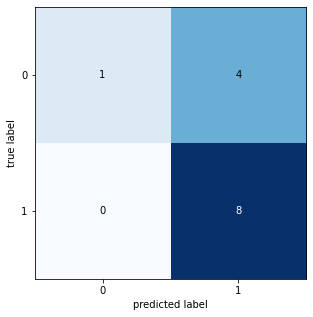

Running Time:  3.342812812000002
colon + IG Orde 3
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



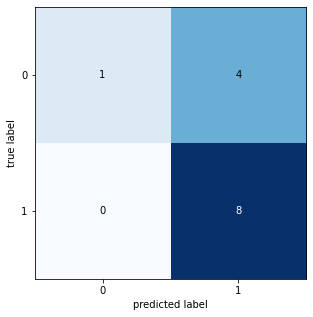

Running Time:  2.786551539999998
colon + IG Orde 4
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



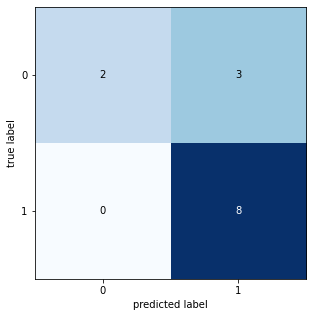

Running Time:  2.8152731559999964
colon + IG + GA Orde 2
Generation : 0
gene : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



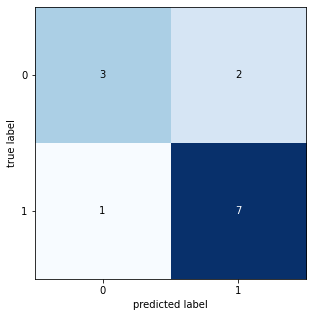

Running Time:  2.746899035999995
gene : [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



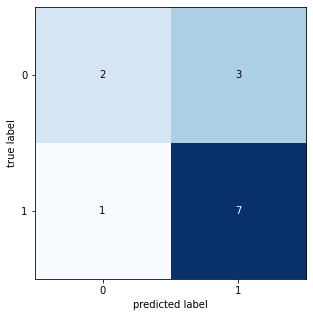

Running Time:  2.6602189250000023
gene : [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



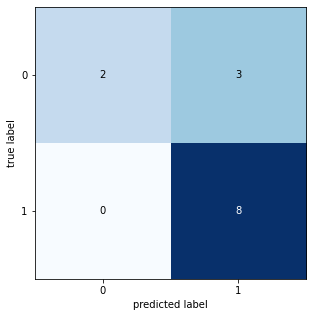

Running Time:  2.841569548999999
gene : [0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



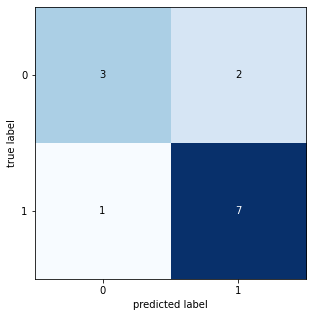

Running Time:  2.650075817000001
gene : [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



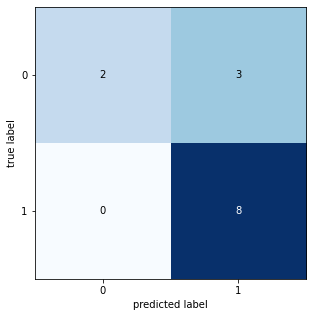

Running Time:  2.703973058999999
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6153846153846154
F1_Score :  0.5112781954887218
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



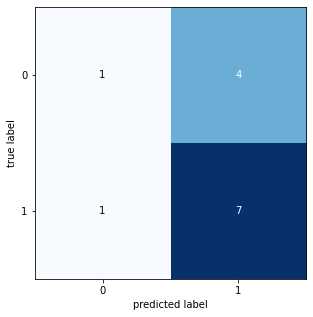

Running Time:  2.6532123909999967
gene : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



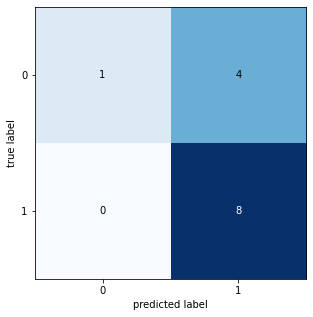

Running Time:  2.6179245539999982
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



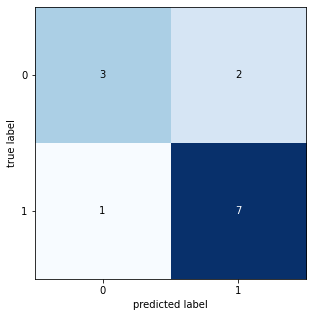

Running Time:  2.590566378999995
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



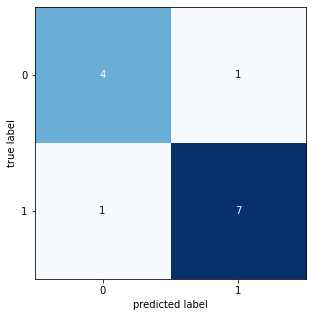

Running Time:  2.623221088000001
gene : [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



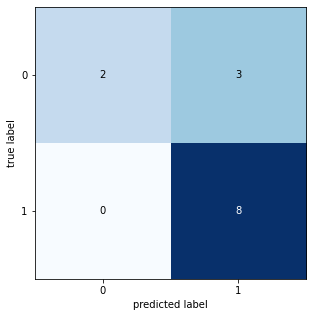

Running Time:  2.6186274089999984
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 1
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pr

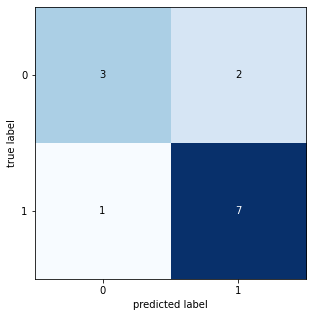

Running Time:  2.8438265990000033
gene : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



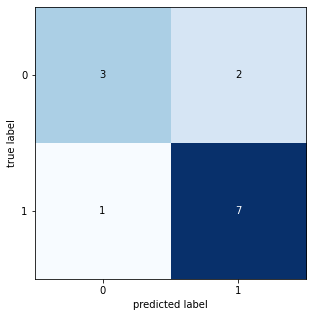

Running Time:  2.674875361000005
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



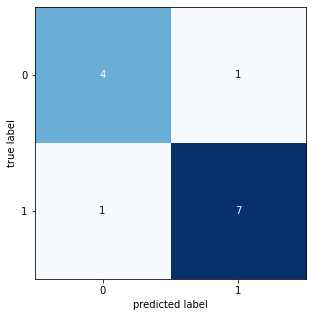

Running Time:  2.5878348159999973
gene : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



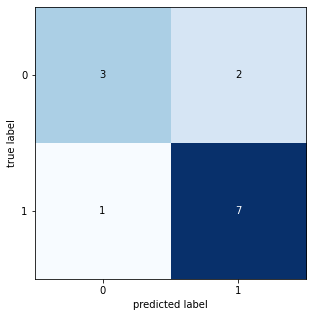

Running Time:  2.635504385999994
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



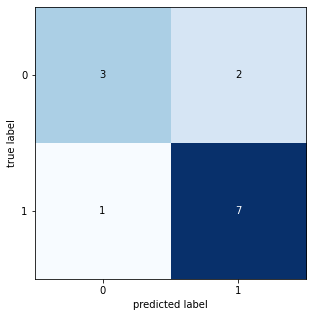

Running Time:  2.66390539599999
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



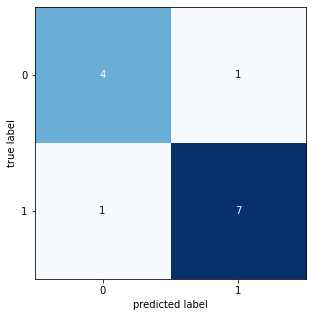

Running Time:  2.637225141000002
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



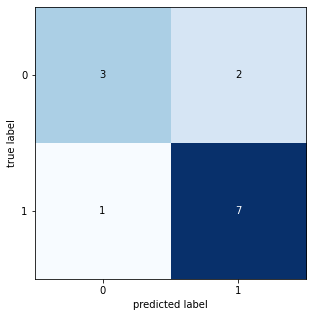

Running Time:  2.6916900540000057
gene : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



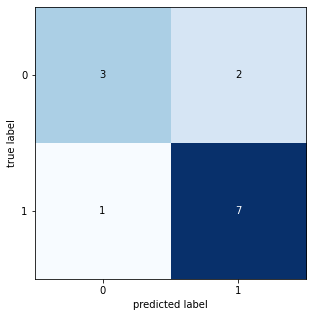

Running Time:  2.9158020869999888
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



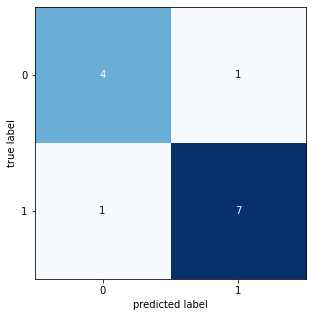

Running Time:  2.8910342320000098
gene : [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



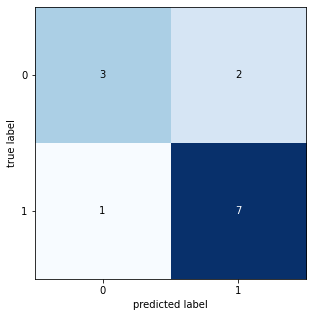

Running Time:  2.669961606000001
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 2
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pre

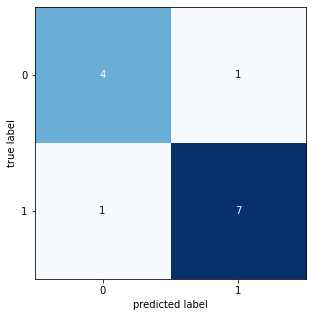

Running Time:  2.6647658820000117
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



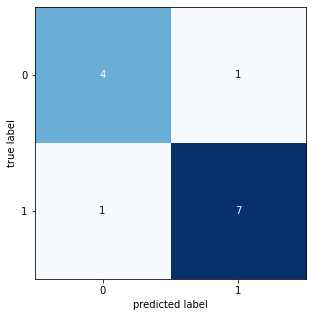

Running Time:  2.6032317850000055
gene : [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



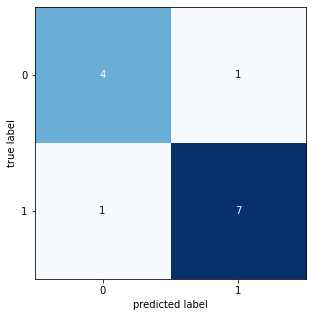

Running Time:  2.632597474999997
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



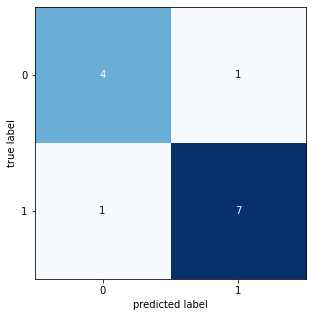

Running Time:  2.648982865999997
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



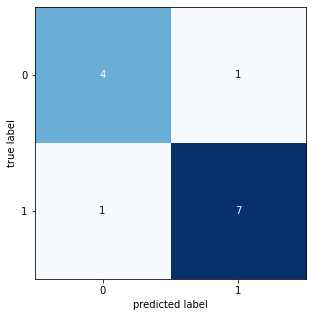

Running Time:  2.6193214470000044
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



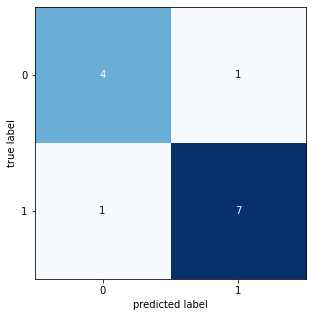

Running Time:  2.9280194340000065
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



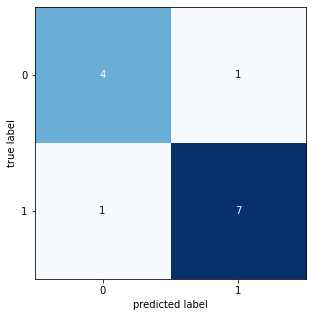

Running Time:  2.661974153999992
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



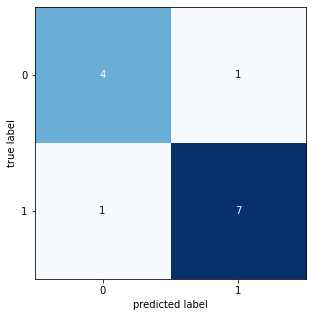

Running Time:  2.6493583599999937
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



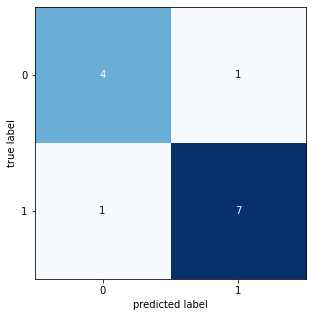

Running Time:  2.652363023999996
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



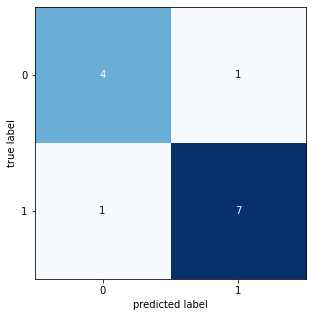

Running Time:  2.584355336999991
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 53

Generation : 3
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pre

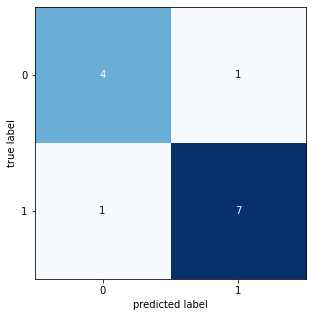

Running Time:  2.7510726579999982
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



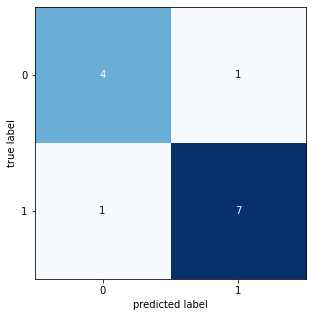

Running Time:  2.666507598999999
gene : [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



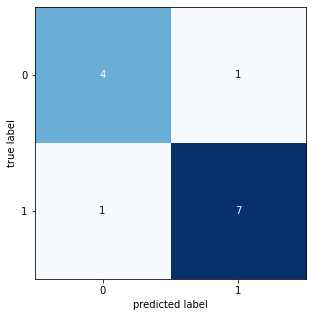

Running Time:  2.983713203999997
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



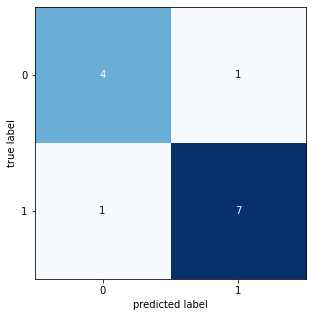

Running Time:  2.7737595339999928
gene : [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



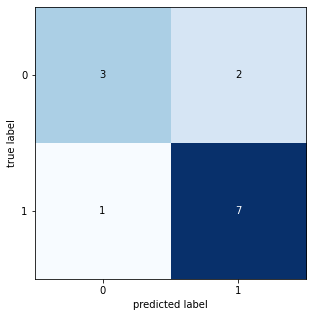

Running Time:  2.8843081549999994
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



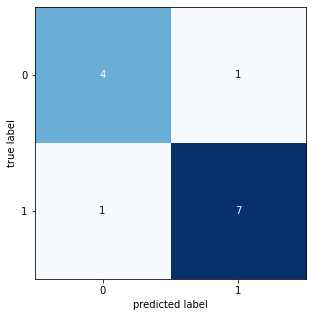

Running Time:  2.6426524149999864
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



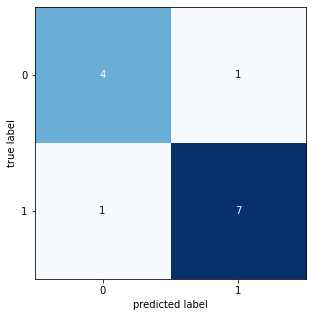

Running Time:  2.594768760999983
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



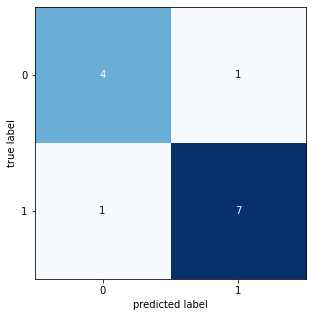

Running Time:  2.6506172779999986
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



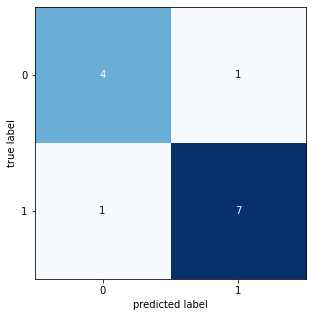

Running Time:  2.650727622000005
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



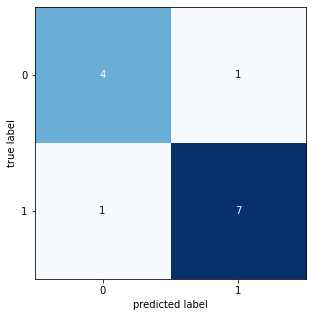

Running Time:  2.645517213000005
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 52

Generation : 4
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pre

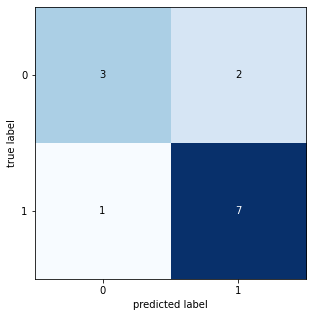

Running Time:  2.9101856670000075
gene : [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



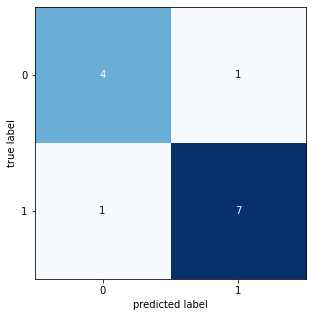

Running Time:  2.688303540000021
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



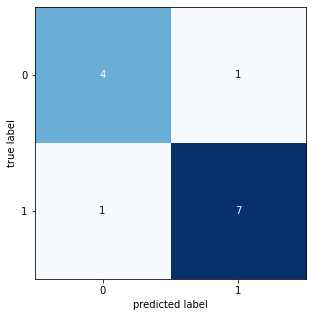

Running Time:  2.6812637449999954
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



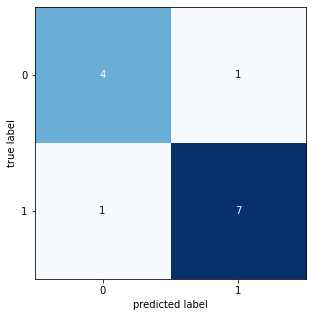

Running Time:  2.636426919999991
gene : [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



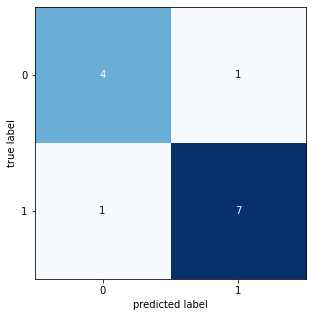

Running Time:  2.7148786529999995
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



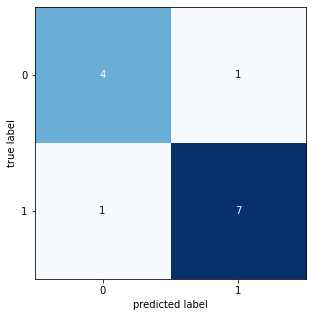

Running Time:  2.5644500250000135
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



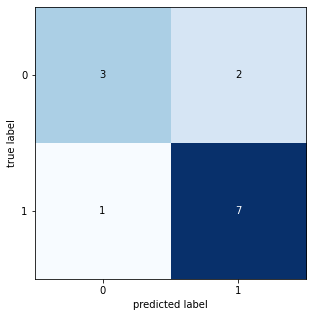

Running Time:  2.601901919999989
gene : [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



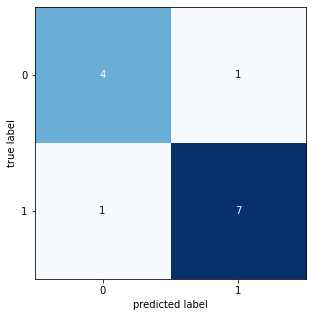

Running Time:  2.9287222149999934
gene : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



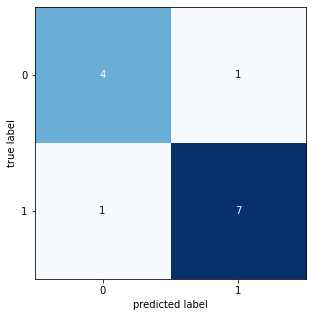

Running Time:  2.6671752580000145
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



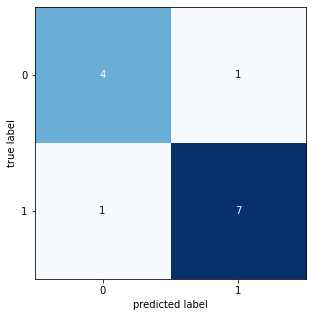

Running Time:  2.637143543999997
gen terbaik : [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 50

Running Time:  137.663166873
colon + IG + GA Orde 3
Generation : 0
gene : [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307

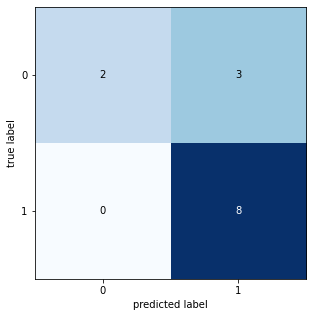

Running Time:  2.6594733560000066
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



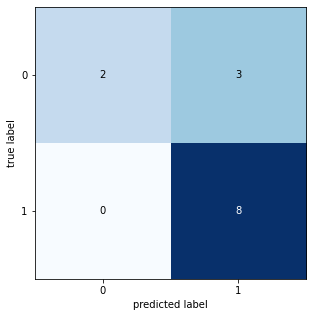

Running Time:  2.692649366999973
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



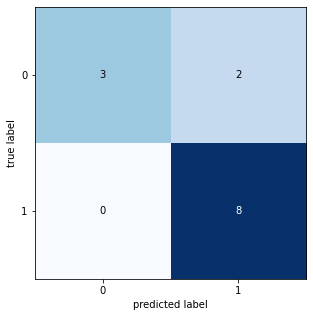

Running Time:  2.6803993030000015
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



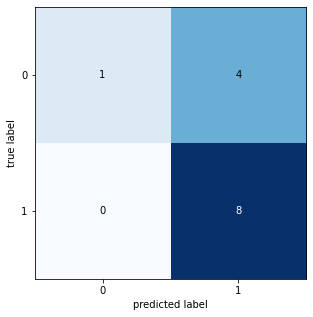

Running Time:  2.663664033999993
gene : [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



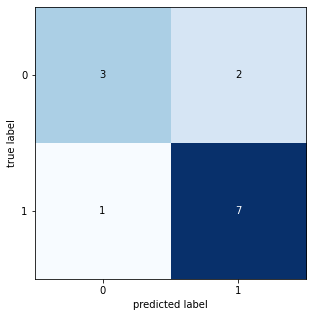

Running Time:  2.926074930999988
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



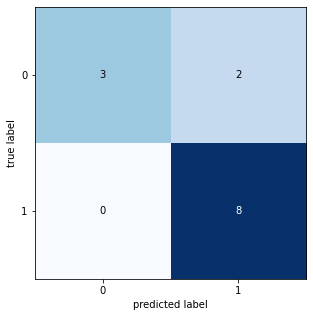

Running Time:  2.736742518
gene : [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



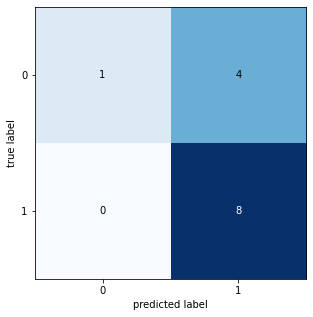

Running Time:  2.6396643599999834
gene : [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6153846153846154
F1_Score :  0.5112781954887218
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



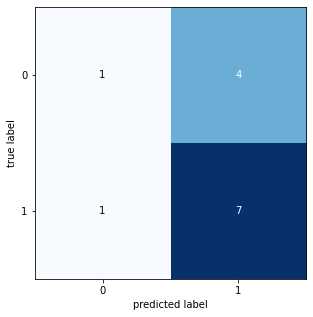

Running Time:  2.6533050219999836
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



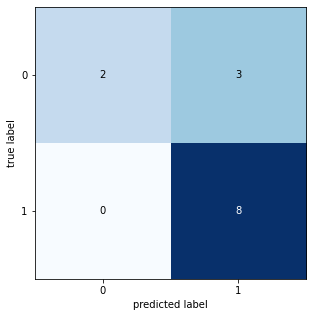

Running Time:  2.696371900999992
gene : [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



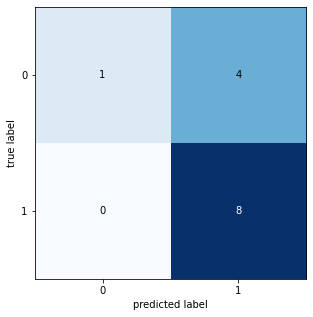

Running Time:  2.618460760000005
gen terbaik : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.8194444444444444  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 53

Generation : 1
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pre

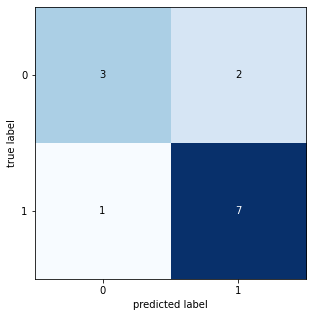

Running Time:  2.673212049
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



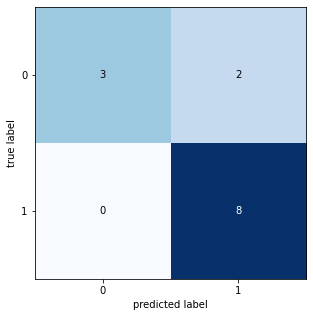

Running Time:  2.6679607990000136
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



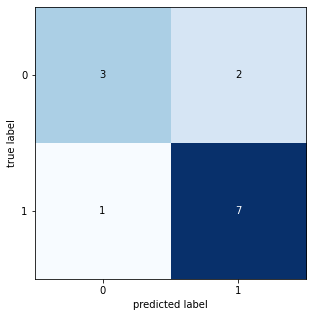

Running Time:  2.9470191460000024
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



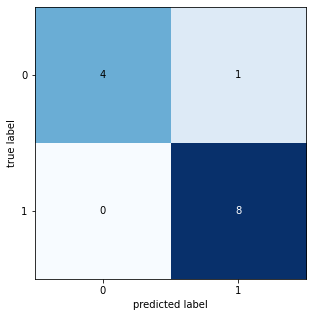

Running Time:  2.699526213000013
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



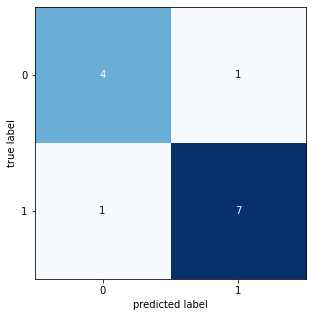

Running Time:  2.650859693000001
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



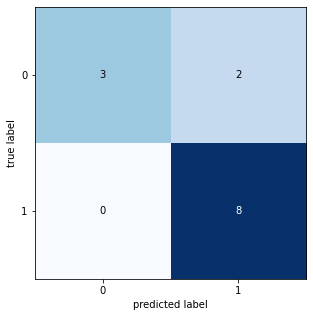

Running Time:  2.640942583999987
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



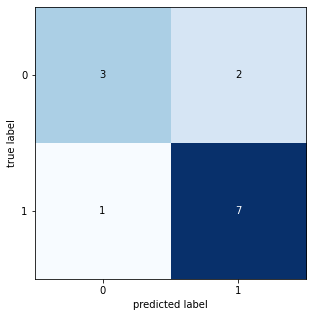

Running Time:  2.7486005469999952
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



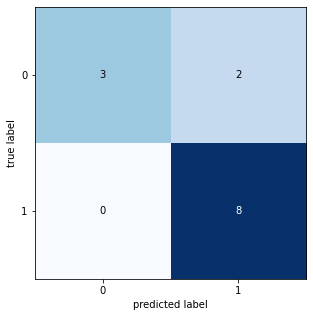

Running Time:  2.6350763530000165
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



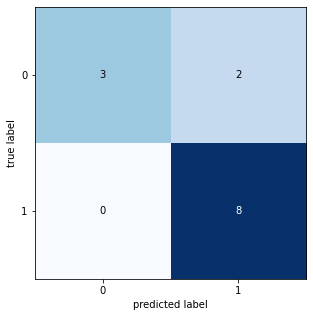

Running Time:  2.6198573530000147
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



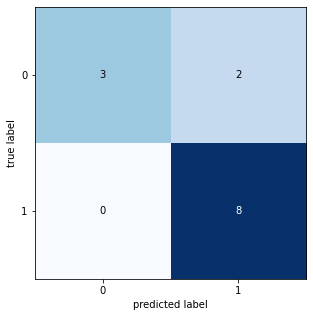

Running Time:  2.678804020000001
gen terbaik : [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.9150326797385622  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 46

Running Time:  55.01156587099999
colon + IG + GA Orde 4
Generation : 0
gene : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.692307692

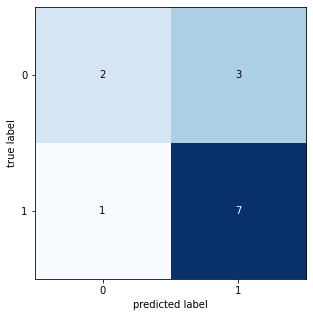

Running Time:  2.724034359000001
gene : [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



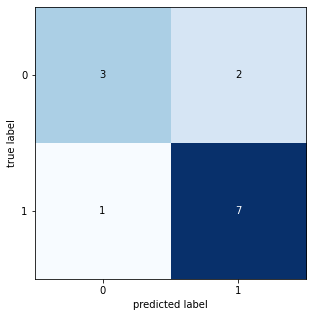

Running Time:  2.7320415430000082
gene : [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



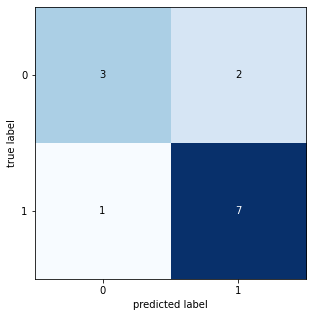

Running Time:  2.625857494999991
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



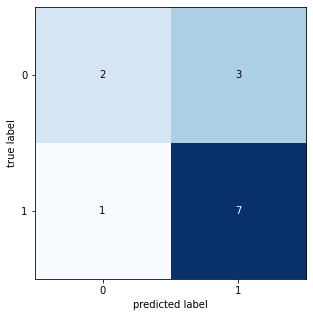

Running Time:  2.81090790799999
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



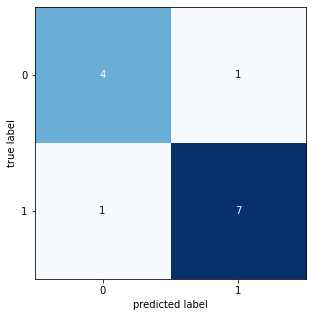

Running Time:  2.8483050039999966
gene : [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



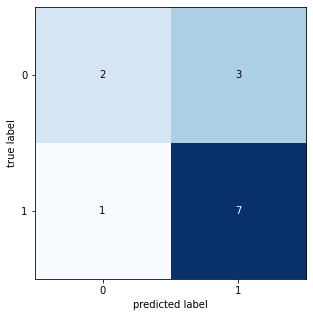

Running Time:  2.8387856650000174
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



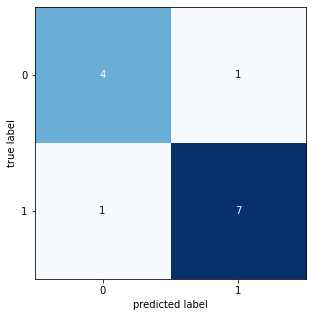

Running Time:  2.8755870939999966
gene : [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



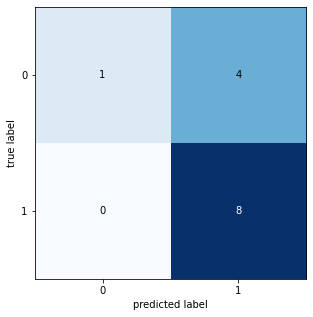

Running Time:  2.9468344869999896
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



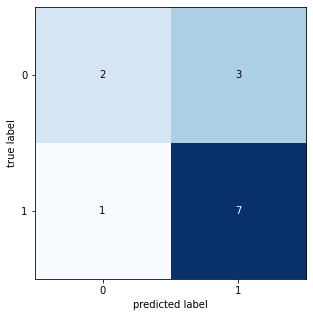

Running Time:  2.6756870609999908
gene : [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



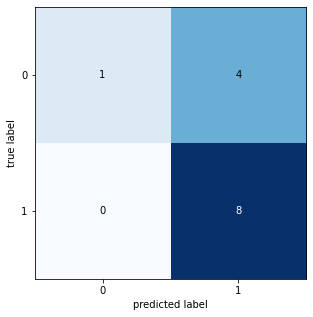

Running Time:  2.631829238000023
gen terbaik : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 51

Generation : 1
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9212121212121211
              pre

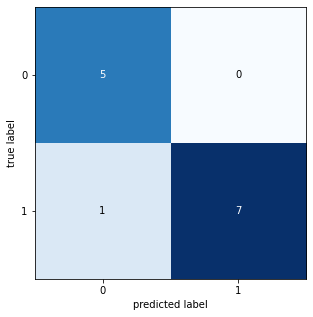

Running Time:  2.7256408639999847
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



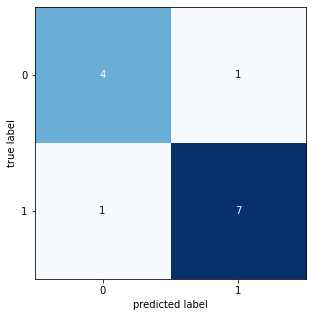

Running Time:  2.708329596999988
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



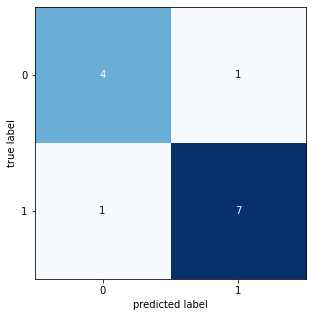

Running Time:  2.6721598839999956
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



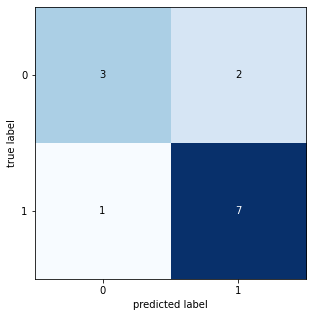

Running Time:  2.6456999899999687
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



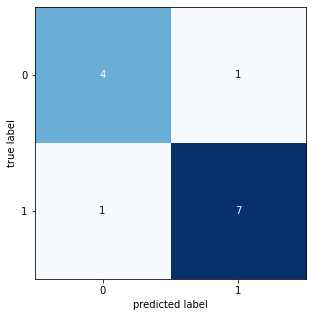

Running Time:  2.947167334000028
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



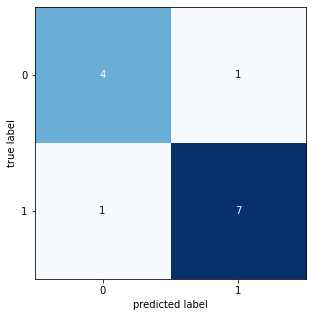

Running Time:  2.652171091000014
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9212121212121211
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13



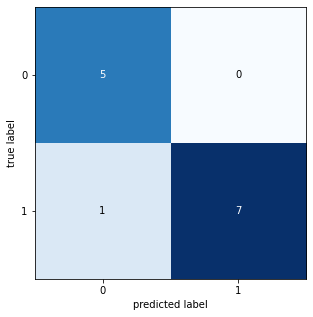

Running Time:  2.686082481000028
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



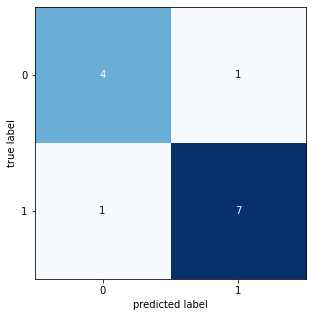

Running Time:  2.7308306740000035
gene : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



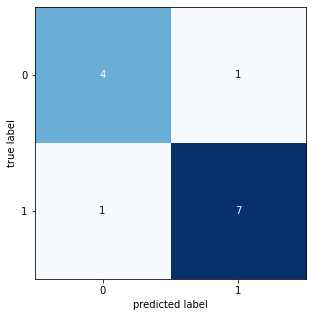

Running Time:  2.661978457000032
gene : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0]
Y_Test : [1 0 1 0 1 0 1 1 1 1 0 0 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



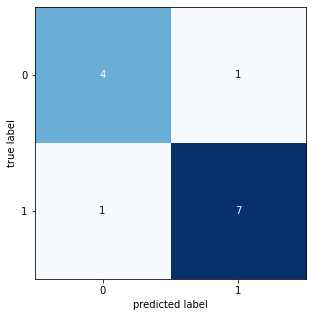

Running Time:  2.6618764399999577
gen terbaik : [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.9212121212121211  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 54

Running Time:  56.206586346999984
Train :  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test :  [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
train:  (49, 101)
test:  (13, 101)
Running Time:  4.093288658000006
colon + IG Orde 2
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
          

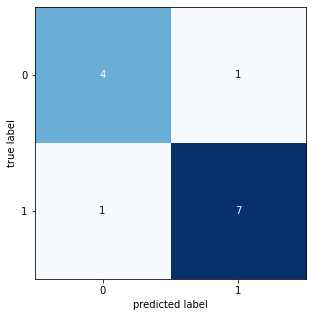

Running Time:  2.719847315000038
colon + IG Orde 3
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



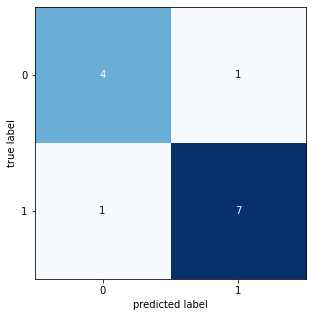

Running Time:  2.7649864699999966
colon + IG Orde 4
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



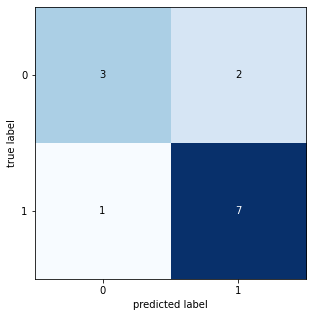

Running Time:  2.9679417870000293
colon + IG + GA Orde 2
Generation : 0
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



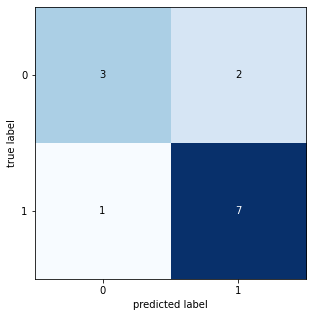

Running Time:  2.651302189999967
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



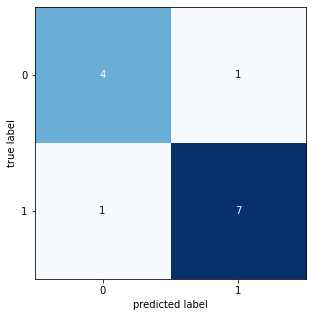

Running Time:  2.669760604999965
gene : [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



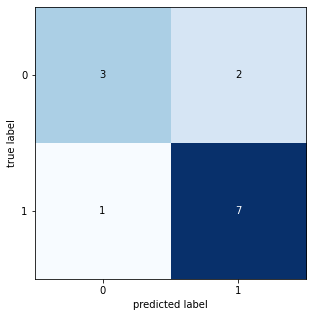

Running Time:  2.657341119000023
gene : [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



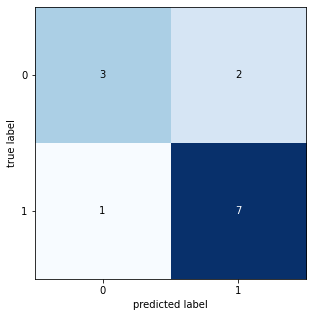

Running Time:  2.6806027380000046
gene : [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



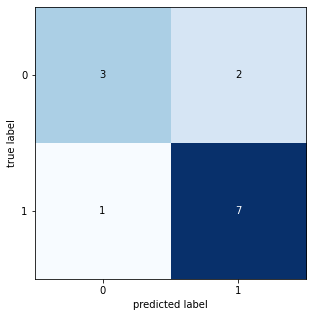

Running Time:  2.7841613189999634
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



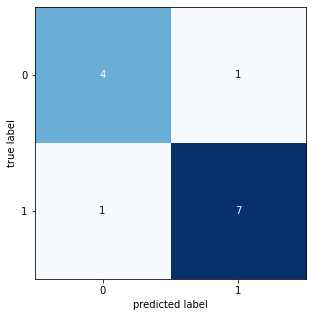

Running Time:  3.049298057000044
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



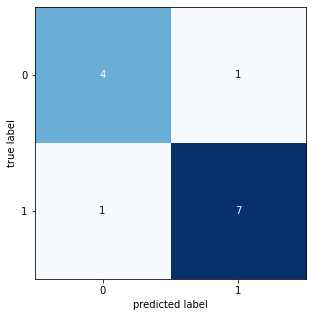

Running Time:  2.744741342999987
gene : [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



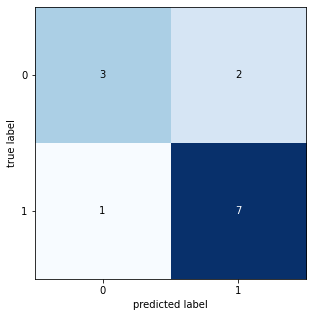

Running Time:  2.7401540380000142
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



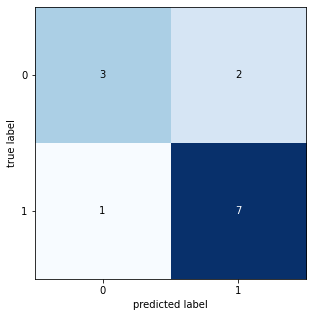

Running Time:  2.6763826530000188
gene : [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



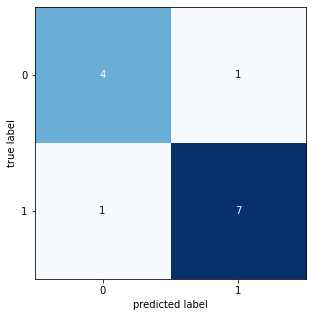

Running Time:  2.6447018389999926
gen terbaik : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 1
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

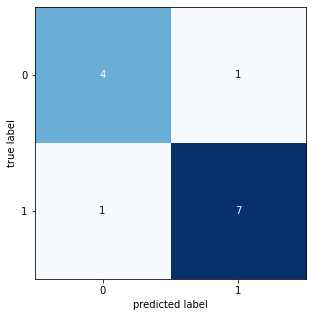

Running Time:  2.795749900999965
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



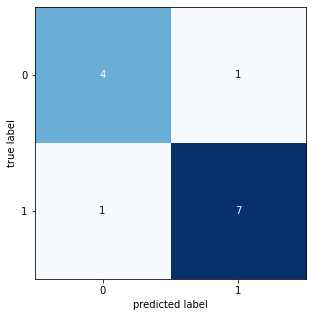

Running Time:  2.865958144999979
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



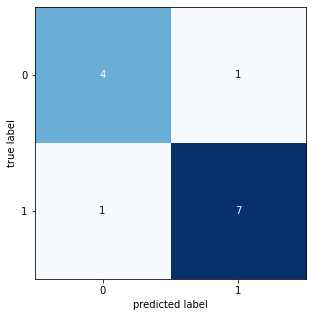

Running Time:  2.6182096789999605
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



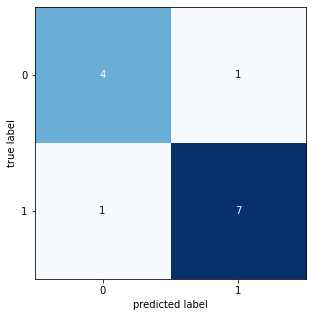

Running Time:  2.954431643000021
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



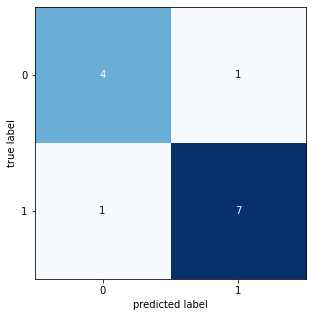

Running Time:  4.20594398999998
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



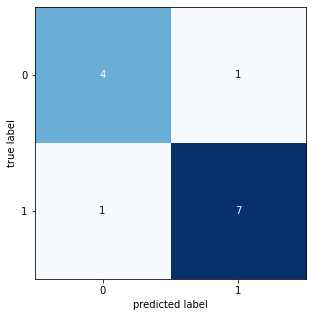

Running Time:  2.9846759510000425
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



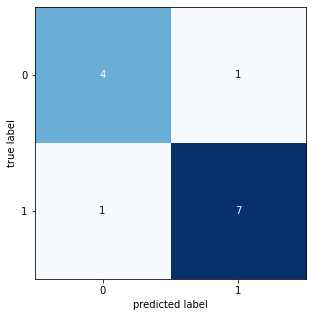

Running Time:  2.8791987629999767
gene : [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



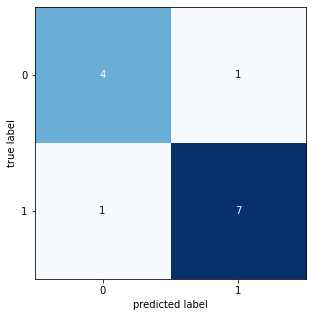

Running Time:  2.7061731750000035
gene : [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



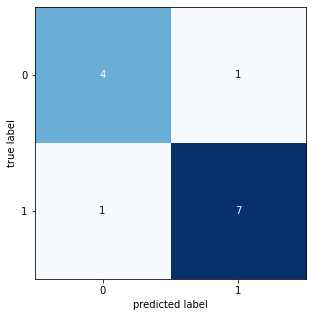

Running Time:  2.762359375000017
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



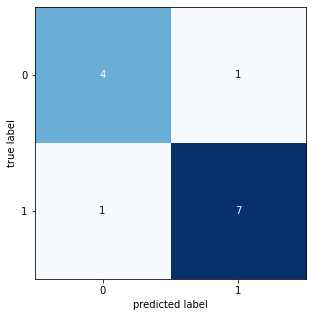

Running Time:  2.6499493569999686
gen terbaik : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 52

Generation : 2
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

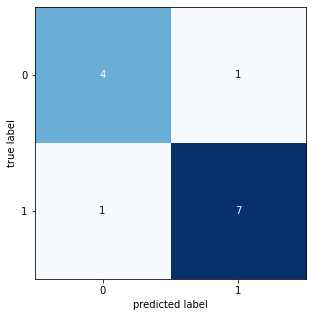

Running Time:  3.0586700740000197
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



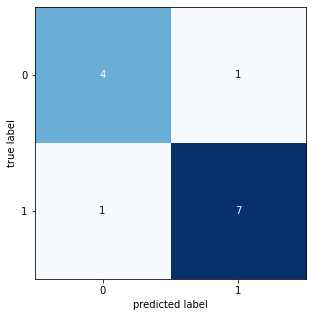

Running Time:  4.118608144000007
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



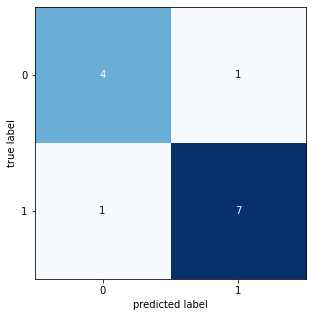

Running Time:  3.89477765099997
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



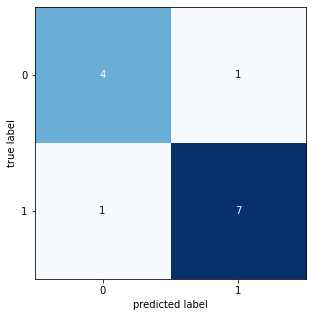

Running Time:  3.337025192999988
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



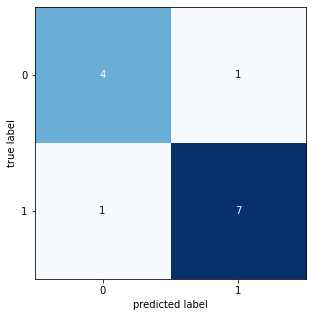

Running Time:  3.674918061000028
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



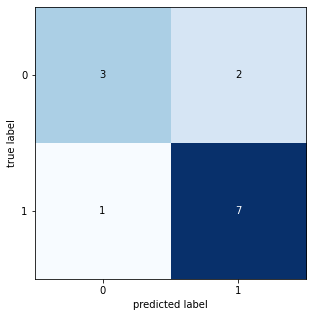

Running Time:  2.9949326160000282
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



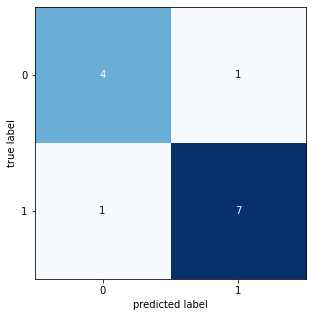

Running Time:  3.0802084419999574
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



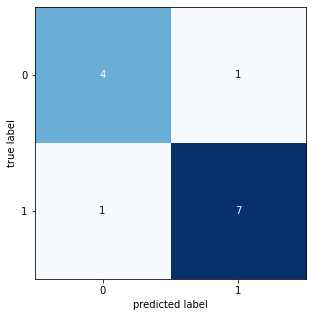

Running Time:  3.269356118000019
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



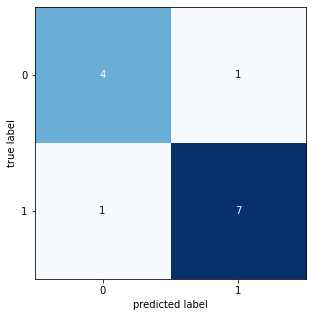

Running Time:  3.723758465000003
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



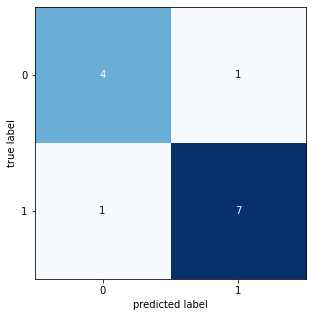

Running Time:  3.191816569000025
gen terbaik : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 54

Generation : 3
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pre

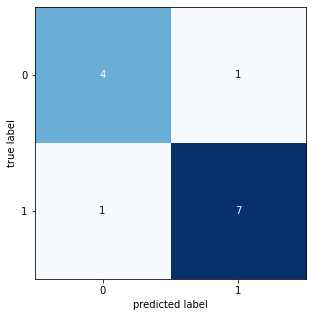

Running Time:  2.8219269420000046
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



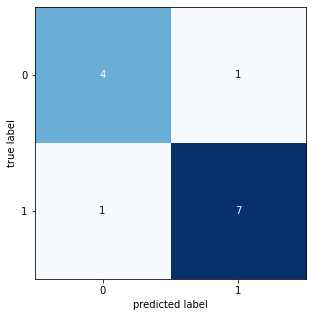

Running Time:  2.948710730000016
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



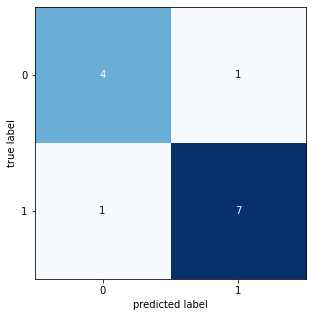

Running Time:  2.6877883349999934
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



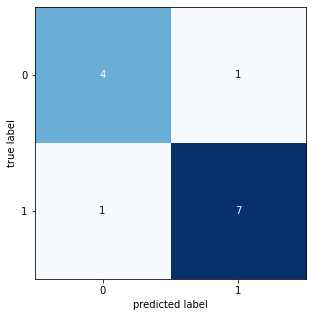

Running Time:  2.653591826999957
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



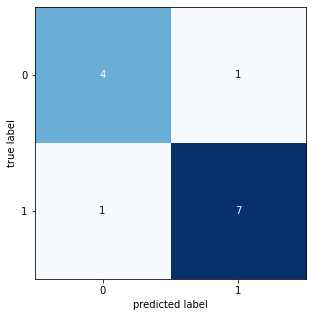

Running Time:  2.984976592999999
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



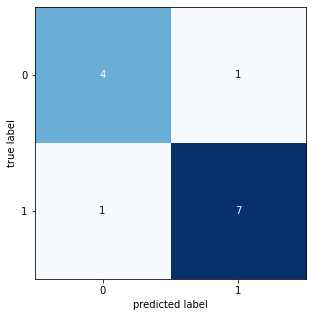

Running Time:  2.7224808470000426
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



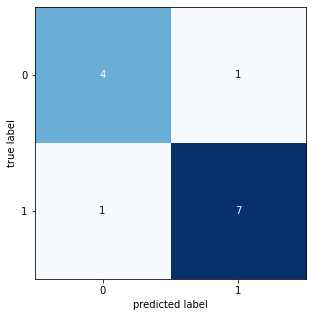

Running Time:  3.0883385839999846
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



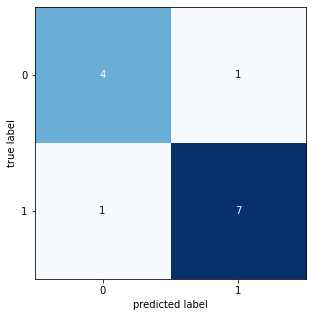

Running Time:  2.913696370000025
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



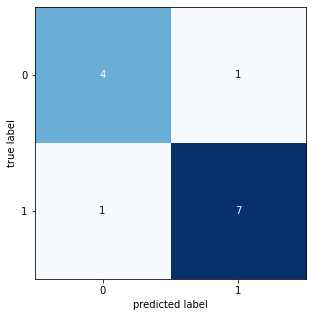

Running Time:  3.004974623999999
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



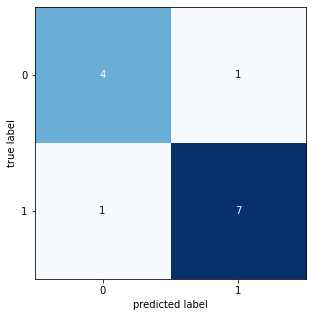

Running Time:  3.2660745780000298
gen terbaik : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 56

Generation : 4
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

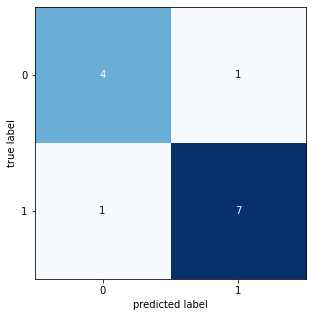

Running Time:  2.829211402999988
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



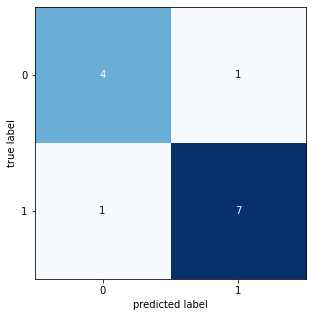

Running Time:  2.8396399669999823
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



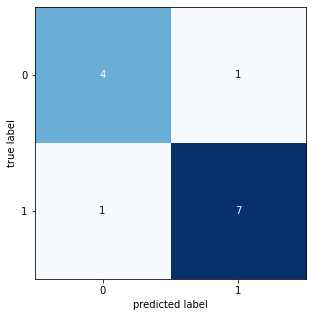

Running Time:  2.9519386789999658
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



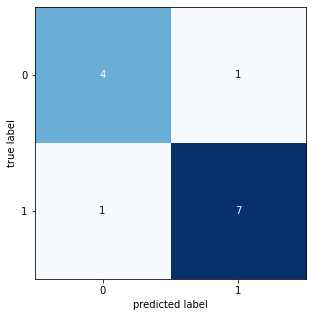

Running Time:  3.230294818999994
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



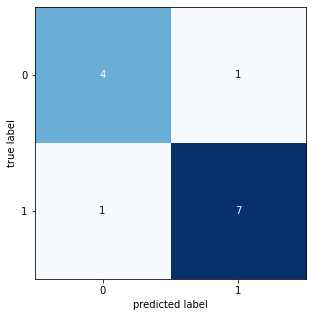

Running Time:  3.069984574999978
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



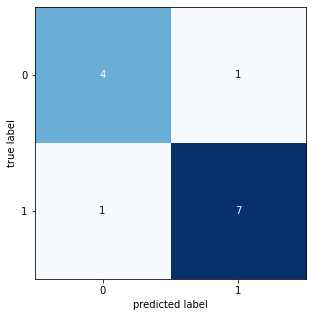

Running Time:  2.89572105000002
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



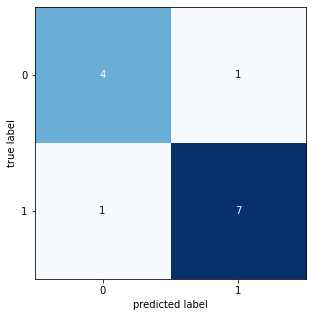

Running Time:  4.1418269079999845
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



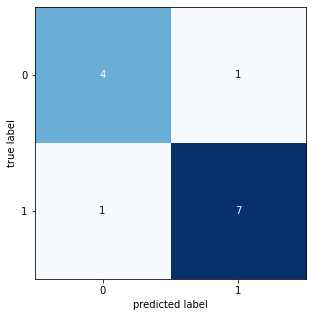

Running Time:  3.0390246000000047
gene : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



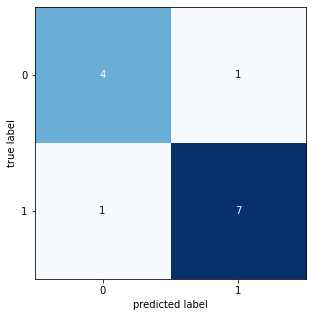

Running Time:  2.7424010909999765
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



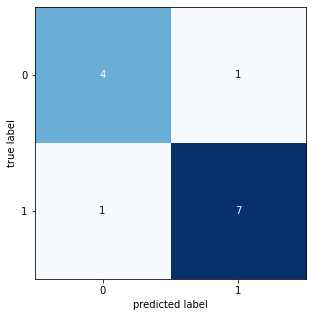

Running Time:  2.729981867000049
gen terbaik : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 60

Running Time:  154.49607169
colon + IG + GA Orde 3
Generation : 0
gene : [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.76923076923076

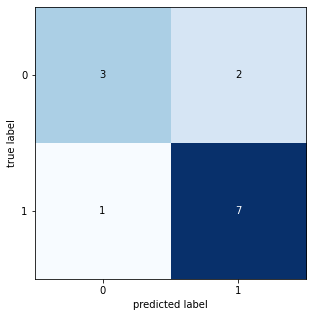

Running Time:  2.754815521000012
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



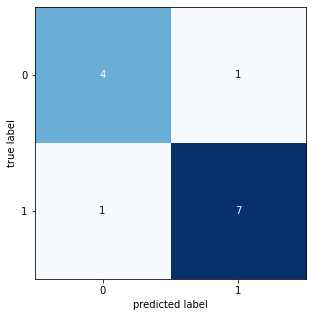

Running Time:  3.235707278999996
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



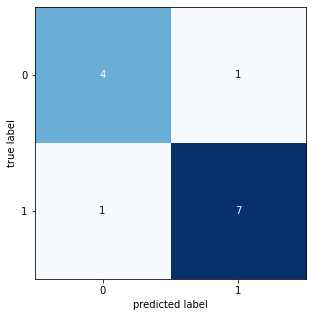

Running Time:  4.495035898000026
gene : [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



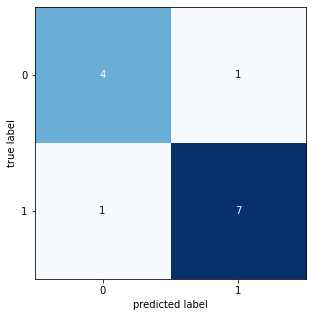

Running Time:  5.384824929000047
gene : [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



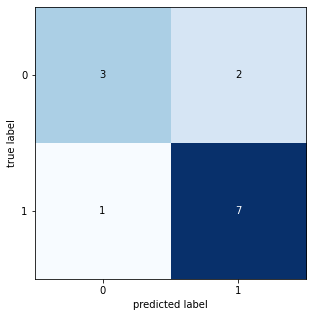

Running Time:  4.271840459000032
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



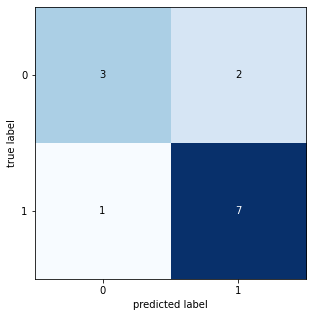

Running Time:  3.608500429000003
gene : [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



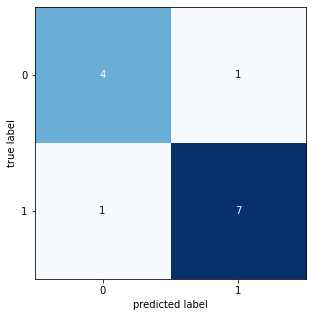

Running Time:  4.098757424999974
gene : [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



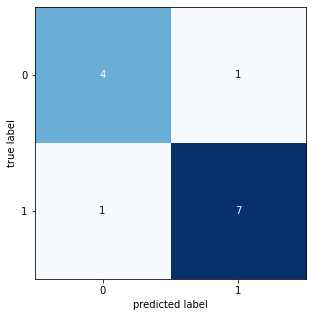

Running Time:  4.120941281
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



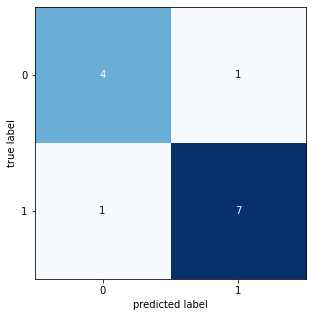

Running Time:  3.8323981069999604
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



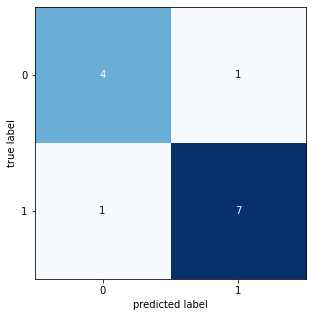

Running Time:  2.8944904890000203
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 44

Generation : 1
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

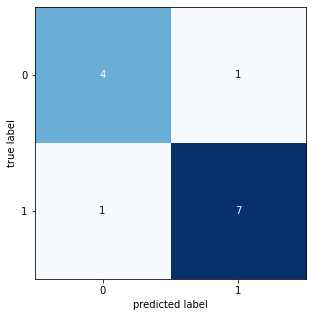

Running Time:  3.0585223530000007
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



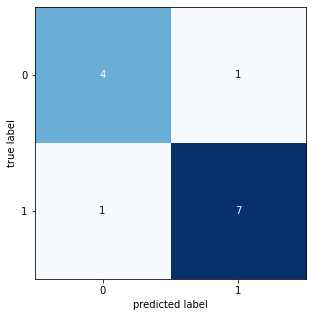

Running Time:  3.5614256269999487
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



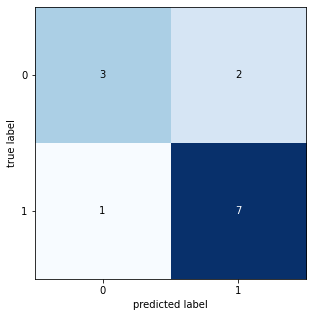

Running Time:  2.9409721330000025
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



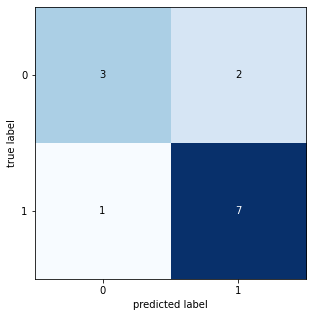

Running Time:  3.152707212999985
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



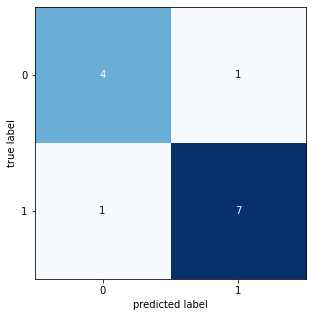

Running Time:  3.211633661999997
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



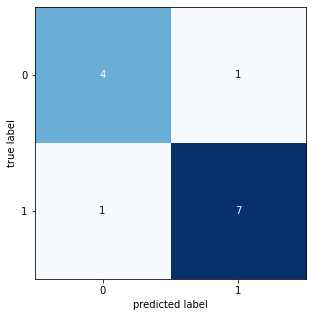

Running Time:  3.1794712230000073
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



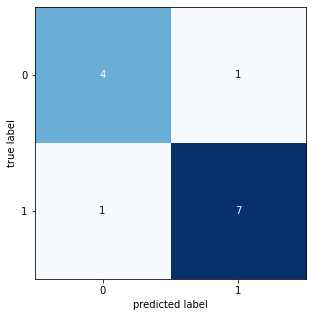

Running Time:  3.5744512460000237
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



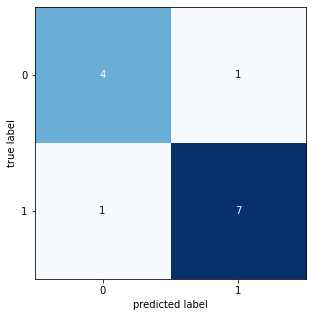

Running Time:  3.358234950999986
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



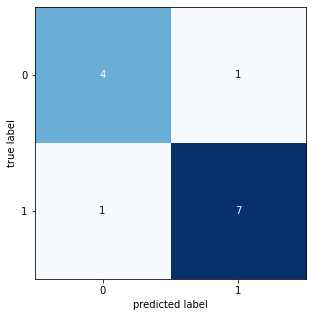

Running Time:  3.365232018000029
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



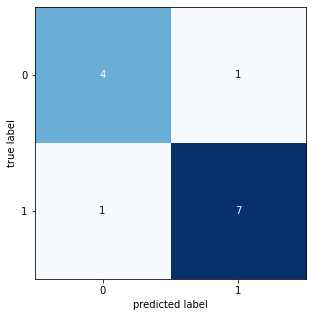

Running Time:  3.0089850479999996
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 52

Generation : 2
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

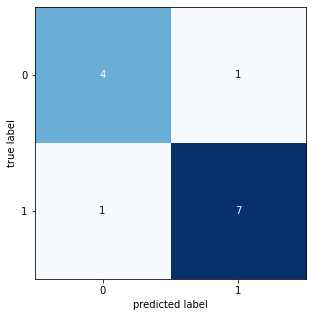

Running Time:  3.3124627820000114
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



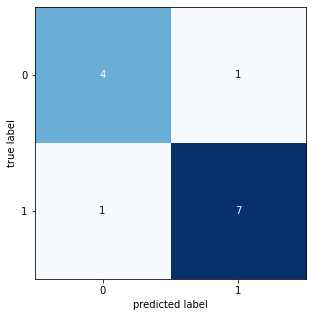

Running Time:  3.2226343199999974
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



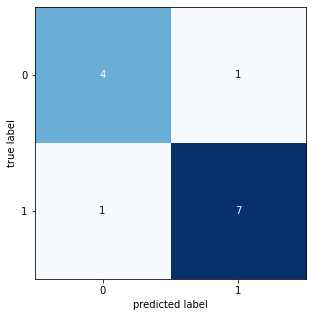

Running Time:  3.0345014419999643
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



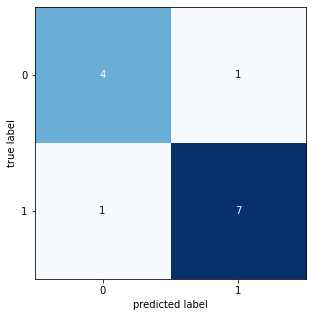

Running Time:  3.4323467870000286
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



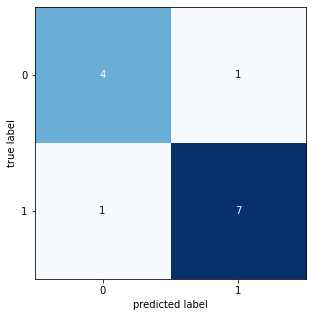

Running Time:  3.4806685800000423
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



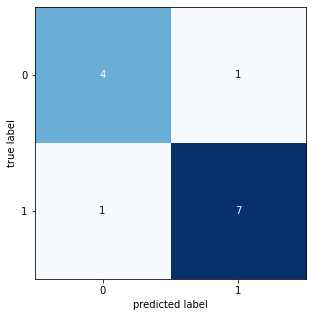

Running Time:  3.290147564999984
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



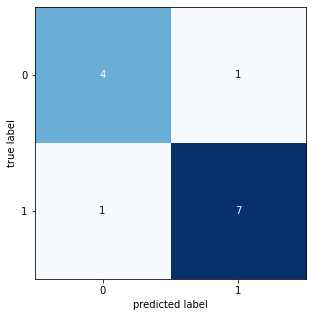

Running Time:  3.233411044000036
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



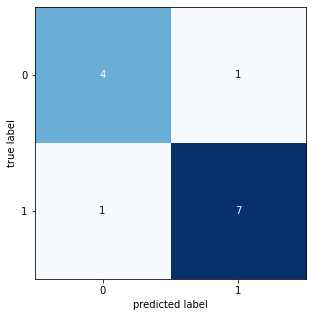

Running Time:  3.3113685130000476
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



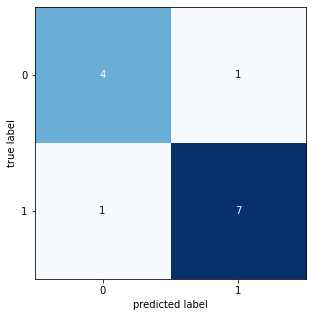

Running Time:  3.628261504999955
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



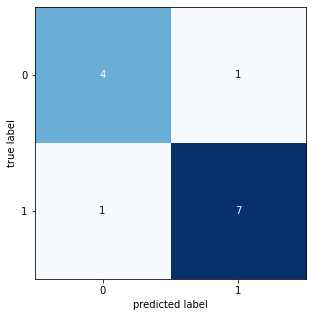

Running Time:  3.053571869999928
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 52

Generation : 3
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pre

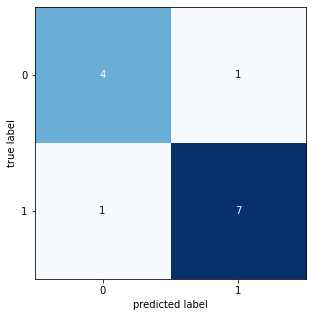

Running Time:  3.2158662809999896
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



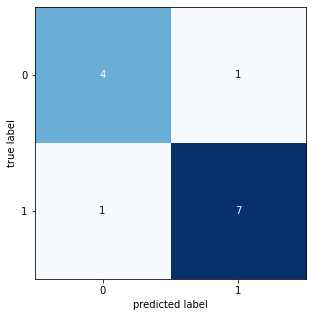

Running Time:  3.429712698000003
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



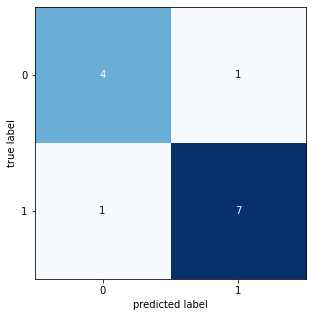

Running Time:  3.1800291880000486
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



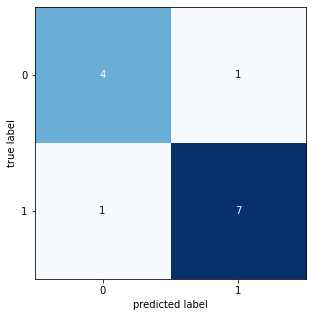

Running Time:  3.3664736670000366
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



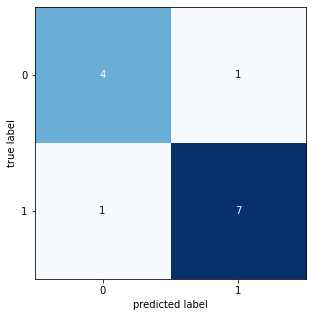

Running Time:  2.9649861500000725
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



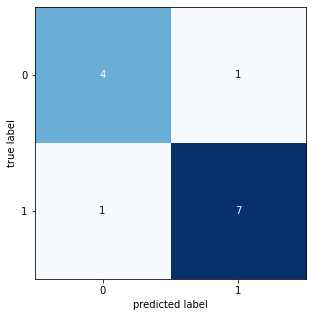

Running Time:  3.0312362149999217
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



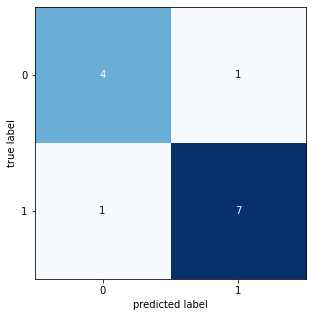

Running Time:  3.038653824999983
gene : [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



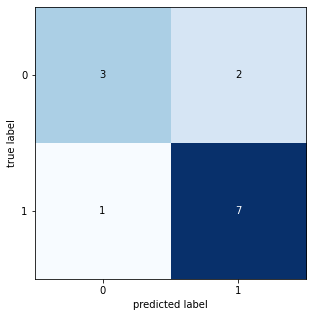

Running Time:  3.1332971389999784
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



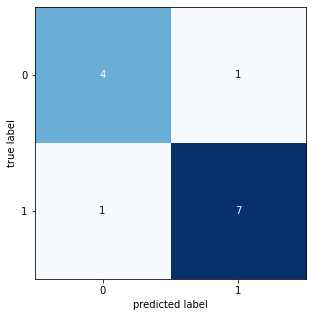

Running Time:  3.5348533439999983
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



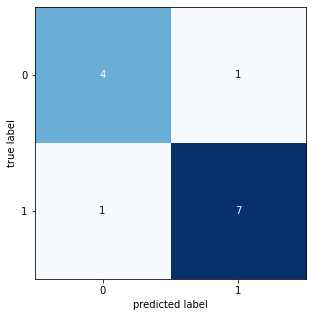

Running Time:  3.316286582000089
gen terbaik : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 51

Generation : 4
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              pre

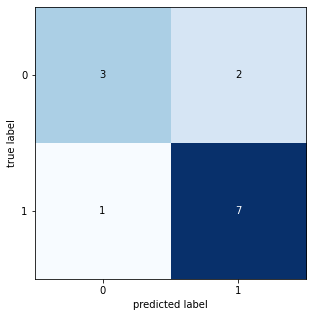

Running Time:  2.8892149920000065
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



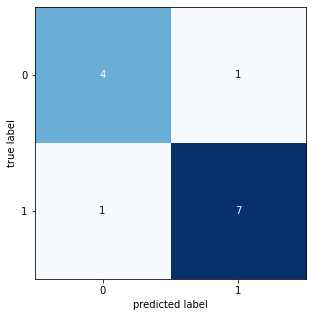

Running Time:  3.4268161640000017
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



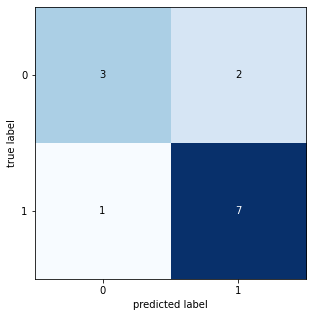

Running Time:  3.7717722360000607
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



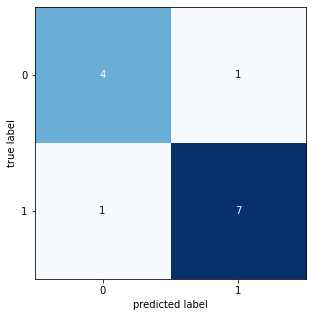

Running Time:  3.211090475999981
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



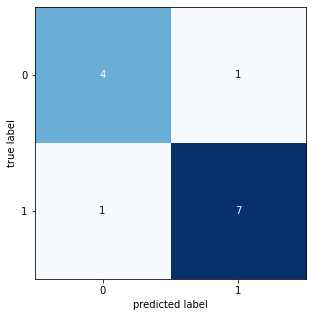

Running Time:  4.016194564999978
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



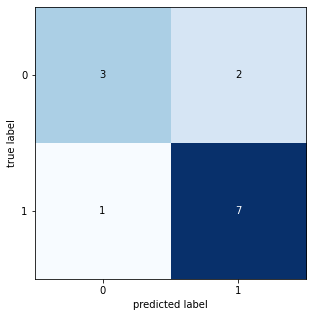

Running Time:  3.0267184350000207
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



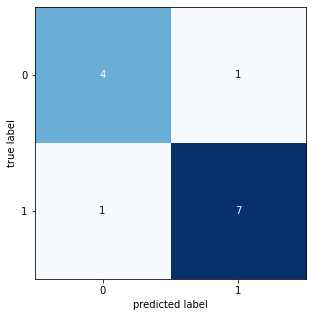

Running Time:  3.7854384839999966
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



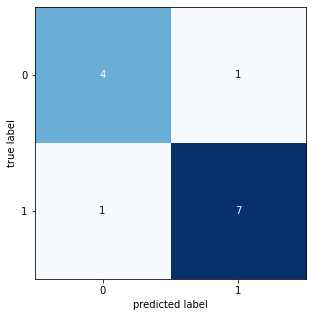

Running Time:  3.5547255890000997
gene : [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



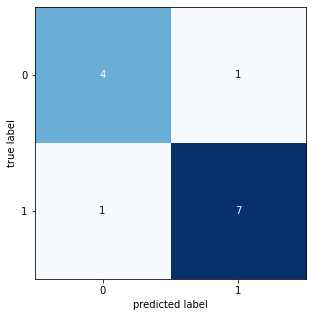

Running Time:  4.226542623
gene : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



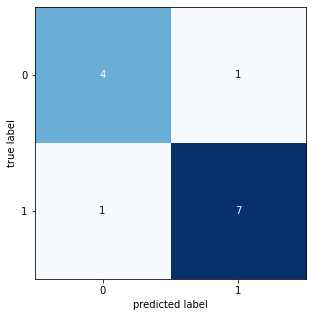

Running Time:  4.33832410399998
gen terbaik : [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 48

Running Time:  176.36438570500007
colon + IG + GA Orde 4
Generation : 0
gene : [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.769230769

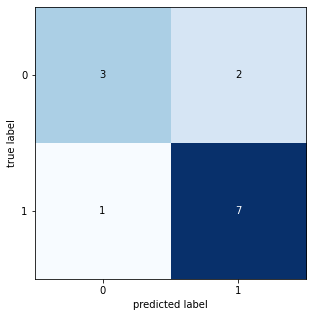

Running Time:  3.052884660000018
gene : [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



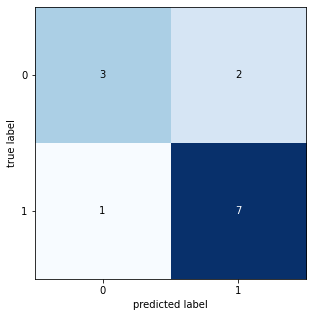

Running Time:  3.454033686999992
gene : [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



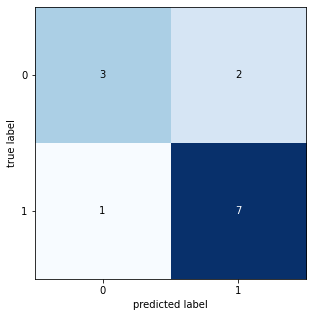

Running Time:  3.5109916370000747
gene : [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



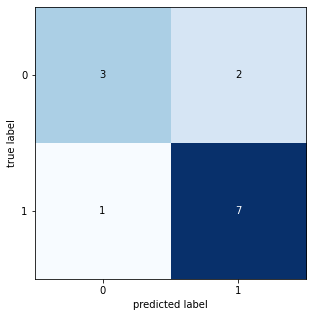

Running Time:  3.7709037480000234
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



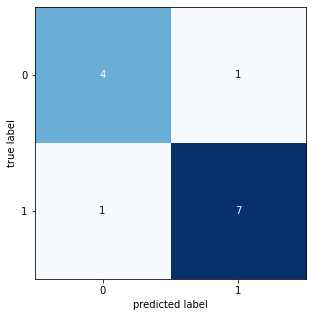

Running Time:  3.4908215259999906
gene : [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7636363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.86      0.75      0.80         8

    accuracy                           0.77        13
   macro avg       0.76      0.78      0.76        13
weighted avg       0.78      0.77      0.77        13



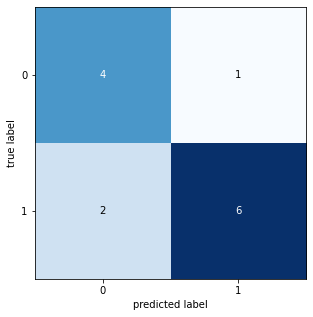

Running Time:  3.2612128480000138
gene : [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



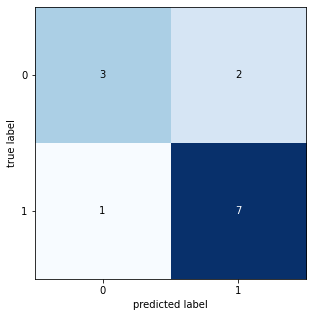

Running Time:  3.4822510229998898
gene : [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



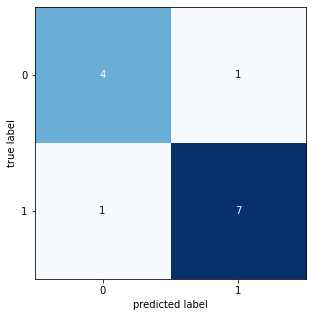

Running Time:  3.5412468329999456
gene : [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.6923076923076923
F1_Score :  0.6388888888888888
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



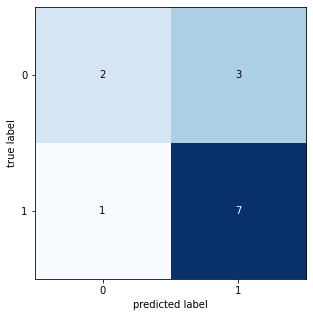

Running Time:  3.1366736229999788
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



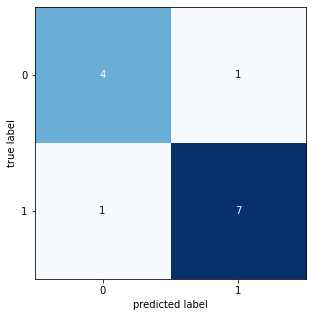

Running Time:  4.7517727000000605
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8375000000000001  || Akurasi terbaik : 0.8461538461538461  || jumlah fitur : 58

Generation : 1
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              pr

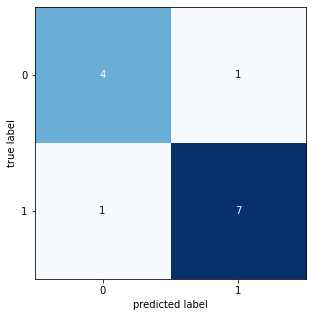

Running Time:  3.7069723949999798
gene : [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



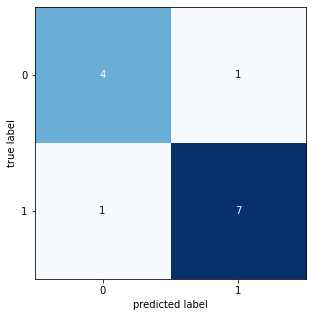

Running Time:  2.839217220000023
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



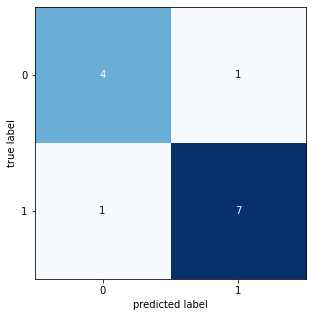

Running Time:  3.022714431000054
gene : [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



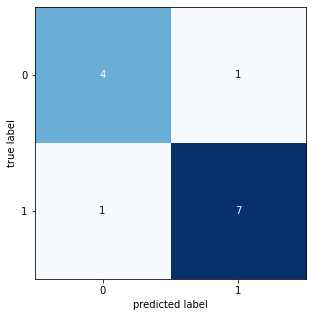

Running Time:  3.171839044999956
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



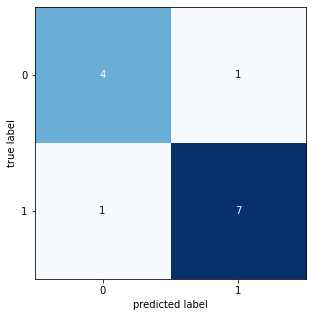

Running Time:  6.096821709999972
gene : [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



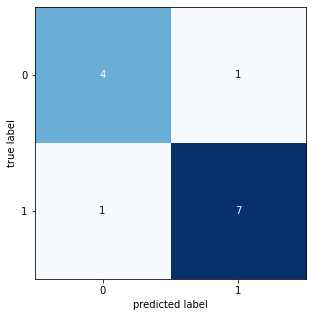

Running Time:  3.5070036980000623
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.89      1.00      0.94         8

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



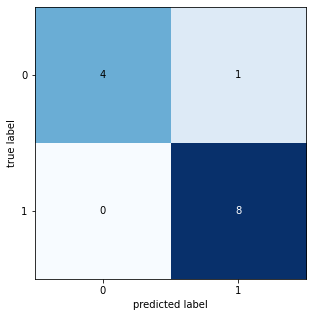

Running Time:  3.71296218100008
gene : [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



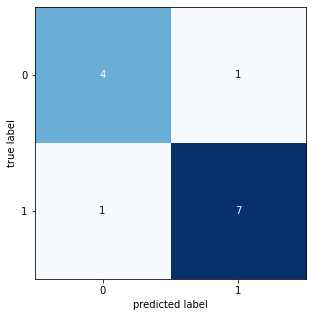

Running Time:  3.0721842320000405
gene : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



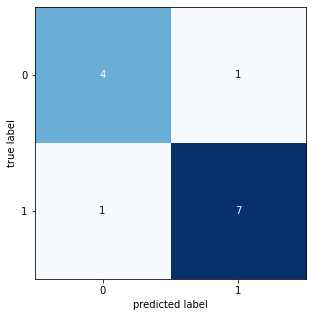

Running Time:  3.446051462000014
gene : [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 0]
Y_Test : [1 0 1 1 0 1 0 1 0 1 0 1 1]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



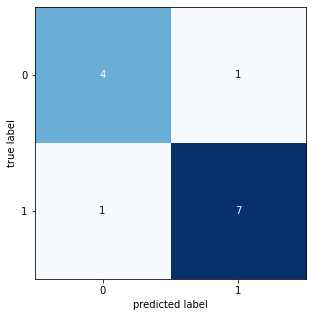

Running Time:  2.9310421129999895
gen terbaik : [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.9150326797385622  || Akurasi terbaik : 0.9230769230769231  || jumlah fitur : 51

Running Time:  72.27700311800004
Train :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test :  [19 25 26 29 32 33 34 36 46 53 54 59]
train:  (50, 101)
test:  (12, 101)
Running Time:  4.803974725000103
colon + IG Orde 2
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
           

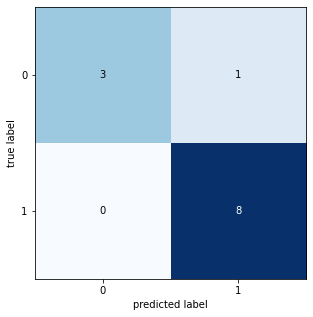

Running Time:  3.048507309999991
colon + IG Orde 3
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



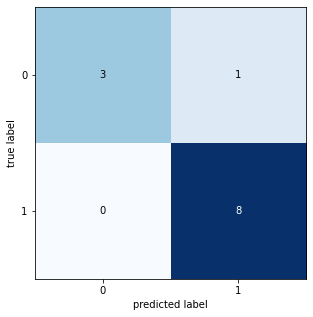

Running Time:  3.8651557449999245
colon + IG Orde 4
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



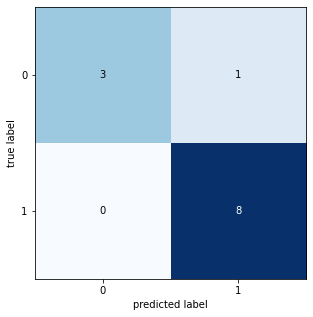

Running Time:  3.563066307999975
colon + IG + GA Orde 2
Generation : 0
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



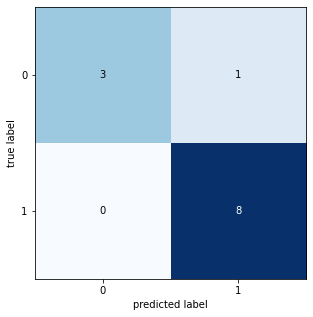

Running Time:  3.8070976459999883
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



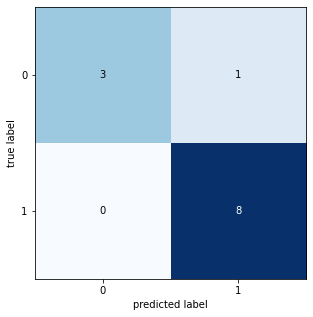

Running Time:  3.6879785930000253
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



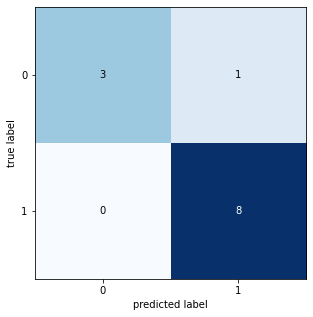

Running Time:  3.875058242000023
gene : [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



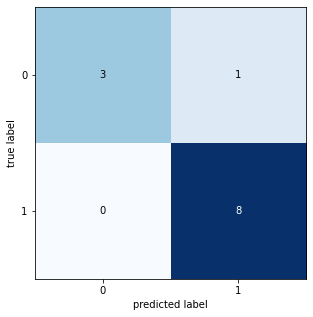

Running Time:  3.5136597329999404
gene : [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



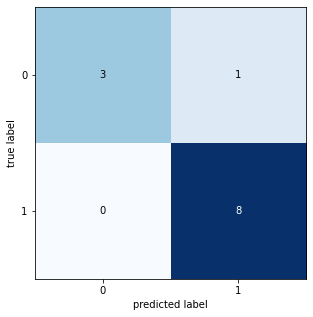

Running Time:  3.6340785730000107
gene : [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



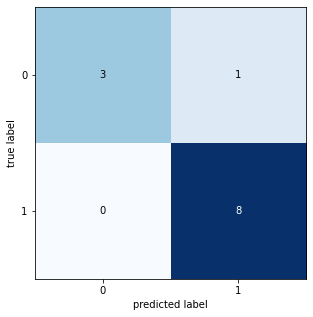

Running Time:  3.0427768869999454
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



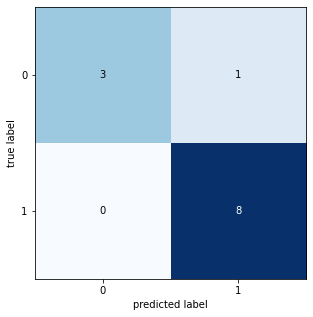

Running Time:  3.1393574129999706
gene : [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



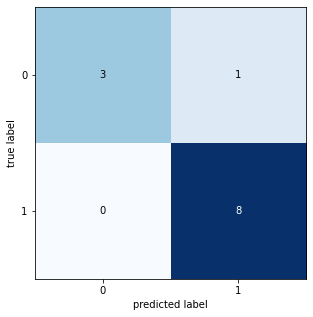

Running Time:  3.0087677950000398
gene : [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



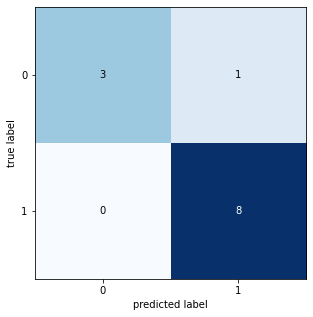

Running Time:  2.8757281179999836
gene : [0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



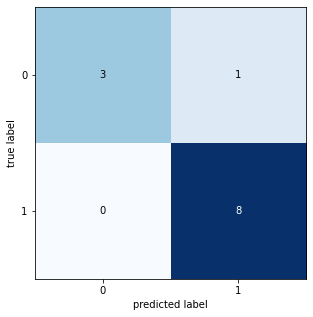

Running Time:  3.0637824030000047
gen terbaik : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 58

Generation : 1
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

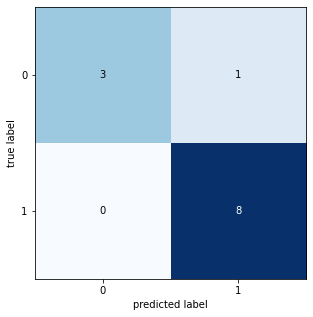

Running Time:  3.1770088089999717
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



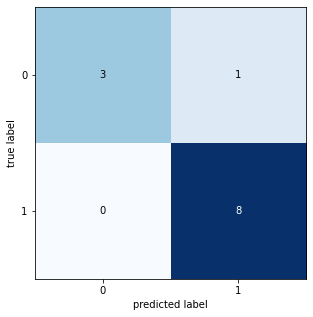

Running Time:  3.0467450639999925
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



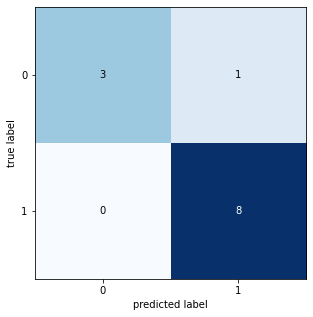

Running Time:  3.244826769999918
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



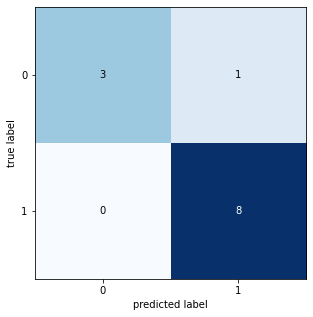

Running Time:  3.115637687000003
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



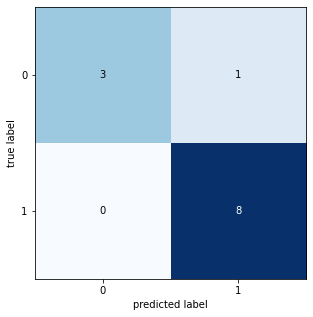

Running Time:  3.1201671870001064
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



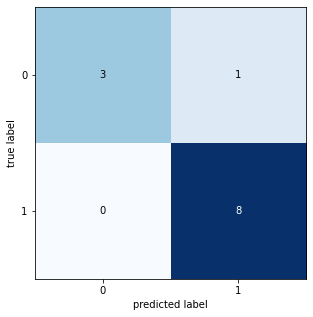

Running Time:  3.5592669030000934
gene : [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



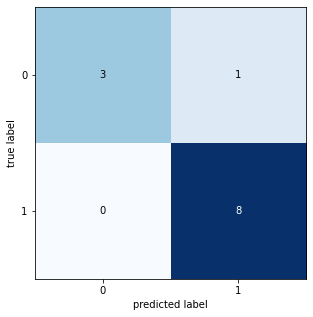

Running Time:  5.766394318000039
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



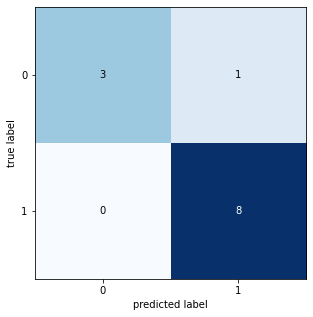

Running Time:  3.394963420999943
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



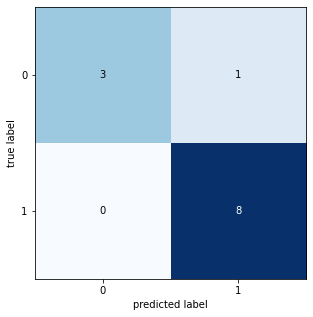

Running Time:  3.7662867909999704
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



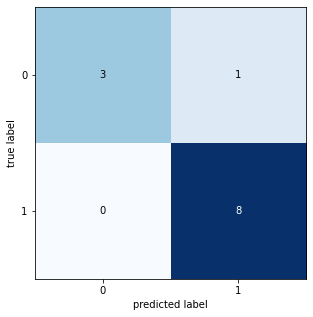

Running Time:  3.165440963999913
gen terbaik : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 53

Generation : 2
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

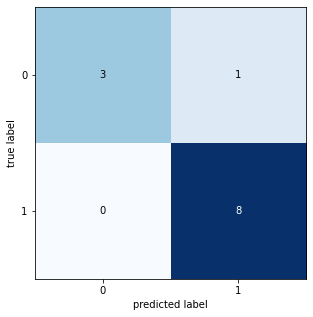

Running Time:  2.952533625000001
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



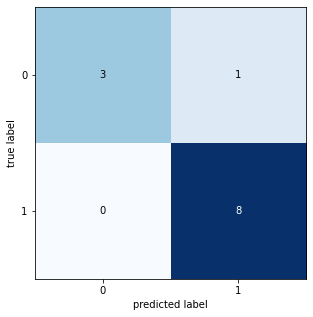

Running Time:  5.841478717999962
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



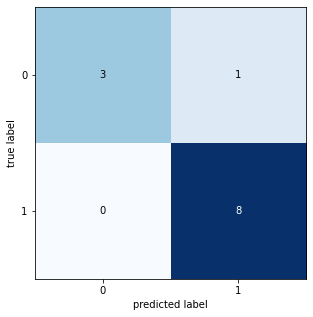

Running Time:  5.910905873000047
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



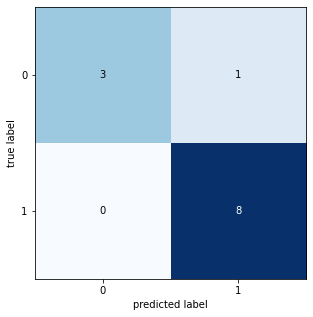

Running Time:  2.841477898999983
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



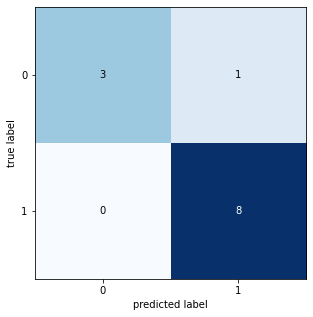

Running Time:  2.7515015320000202
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



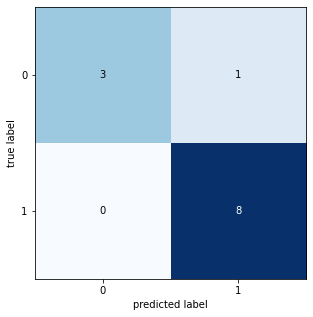

Running Time:  3.091850204000025
gene : [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



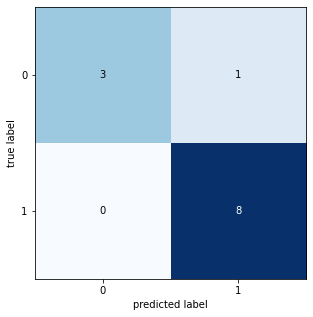

Running Time:  2.796058439000035
gene : [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



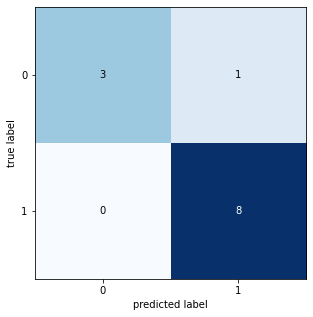

Running Time:  3.0282559799999262
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



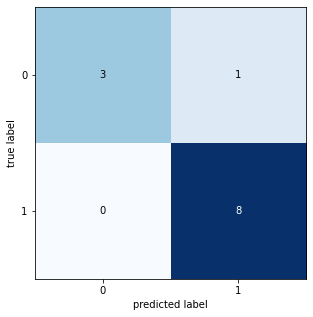

Running Time:  3.275155122000001
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



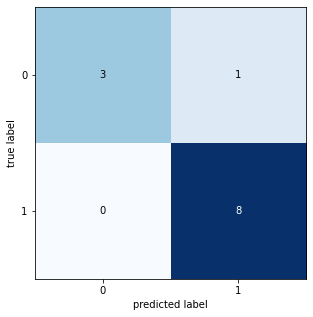

Running Time:  2.868622307999999
gen terbaik : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 54

Generation : 3
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

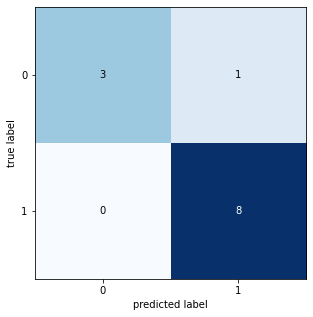

Running Time:  2.9346678250000195
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



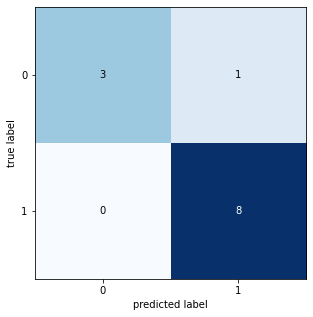

Running Time:  2.9567276850000326
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



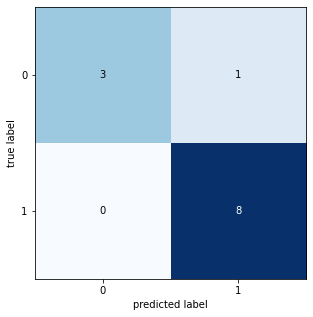

Running Time:  3.31579272099998
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



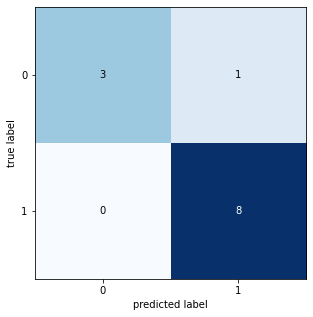

Running Time:  3.5210441750000427
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



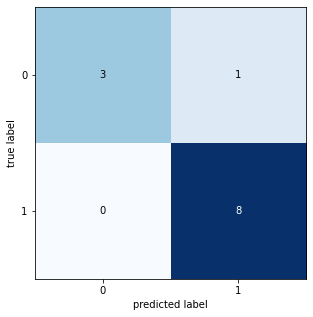

Running Time:  3.234207362999996
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



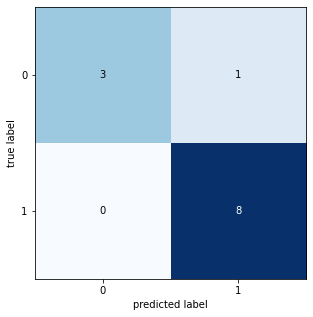

Running Time:  3.286023200000045
gene : [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



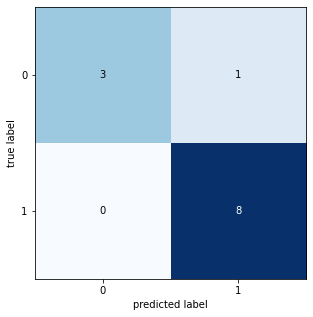

Running Time:  5.556469825000022
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



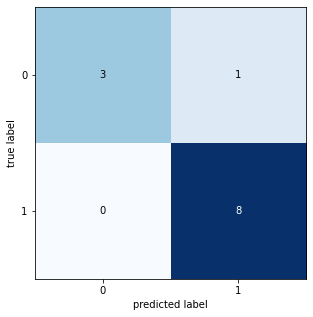

Running Time:  4.288534639999966
gene : [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



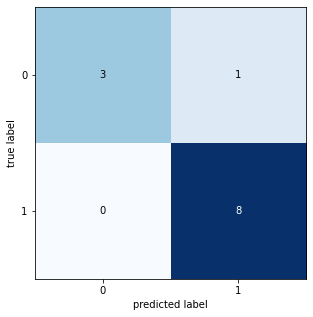

Running Time:  4.382387210999923
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



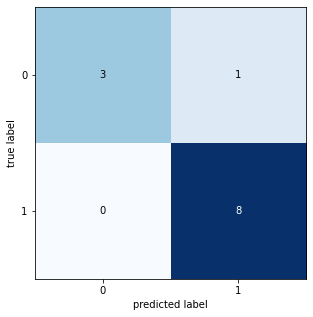

Running Time:  3.6968299699999534
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 55

Generation : 4
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

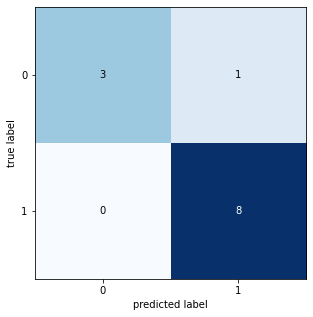

Running Time:  3.7845044619999726
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



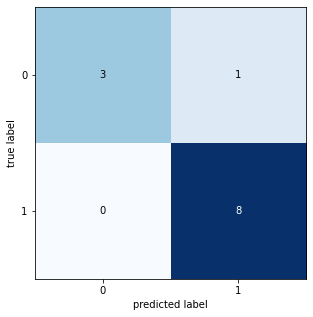

Running Time:  2.921758078000039
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



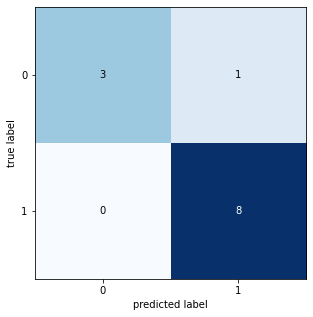

Running Time:  2.9836314670000093
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



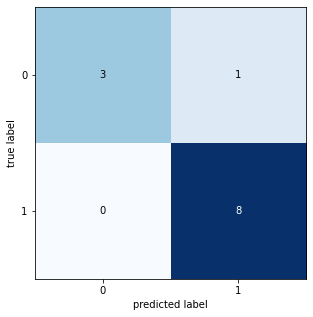

Running Time:  2.8038432390000025
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



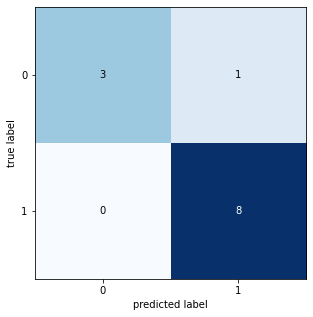

Running Time:  2.777544940000098
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



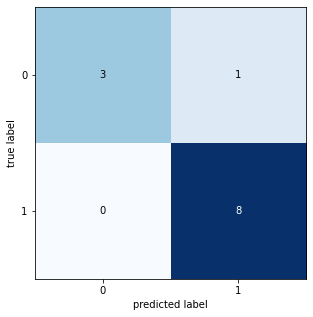

Running Time:  3.5231176830000095
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



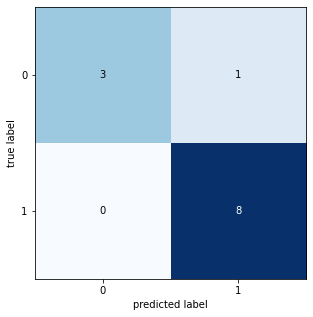

Running Time:  3.663267082999937
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



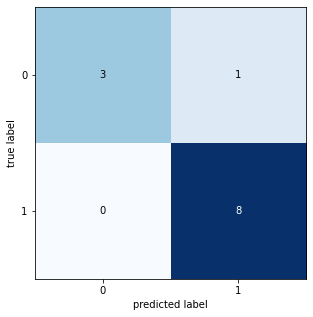

Running Time:  3.1155231740000318
gene : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



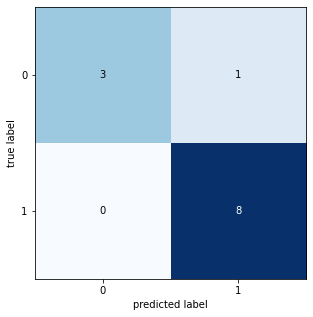

Running Time:  3.8271718799999235
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



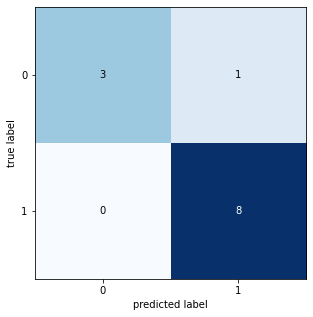

Running Time:  4.317238233000012
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 50

Running Time:  178.363587069
colon + IG + GA Orde 3
Generation : 0
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666

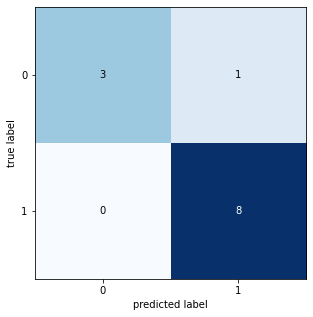

Running Time:  3.1884955799999943
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



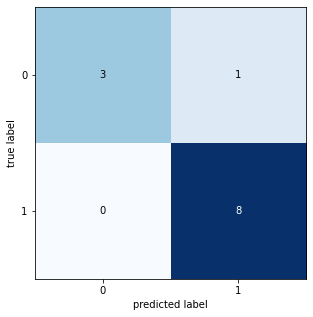

Running Time:  3.144333908999897
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



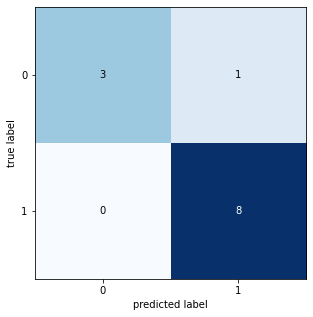

Running Time:  3.3090936930000225
gene : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



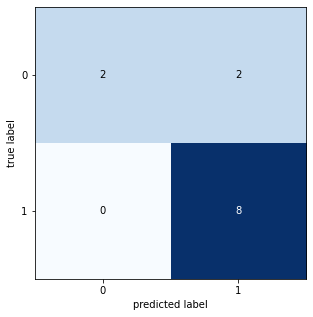

Running Time:  3.8640613170000506
gene : [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



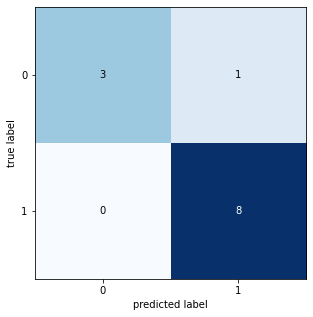

Running Time:  5.9476834600000075
gene : [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



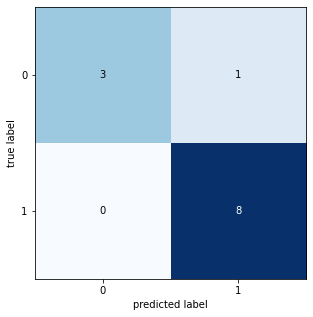

Running Time:  3.3355233059999136
gene : [0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



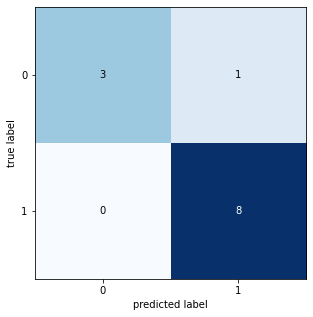

Running Time:  3.271723092000002
gene : [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



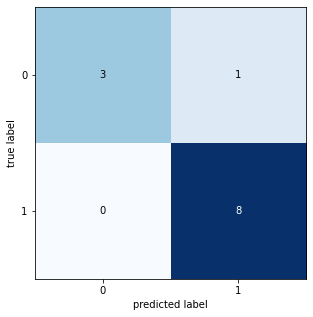

Running Time:  2.918576726000083
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



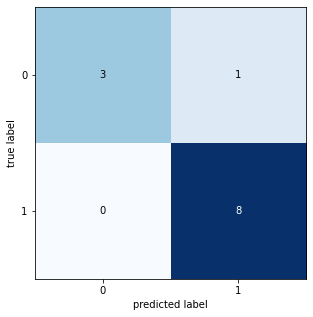

Running Time:  3.0927453759999253
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



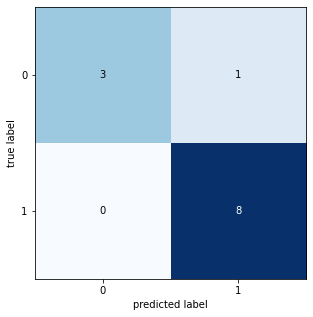

Running Time:  3.207013714000027
gen terbaik : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 56

Generation : 1
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              pre

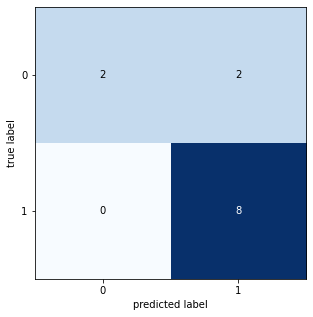

Running Time:  3.666190340999947
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



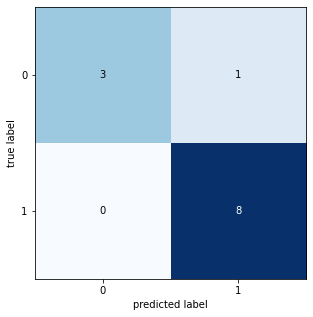

Running Time:  3.3926037809999343
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



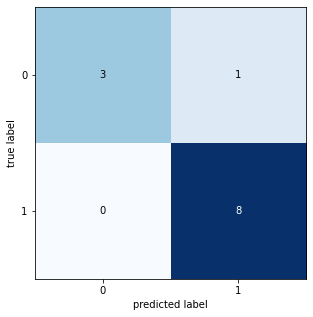

Running Time:  5.2452133889999
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



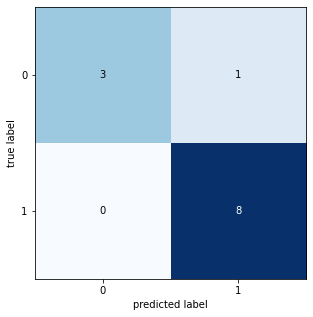

Running Time:  3.1297309109999105
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



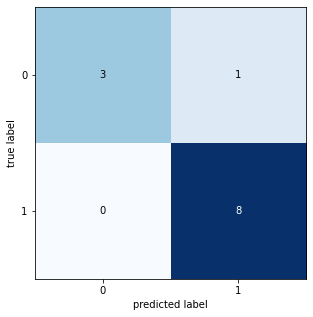

Running Time:  3.237006132000033
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



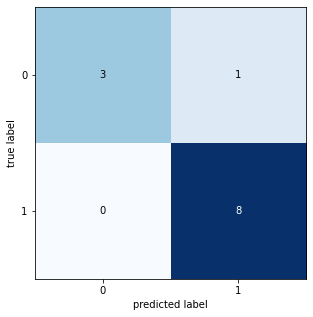

Running Time:  5.90268056299999
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



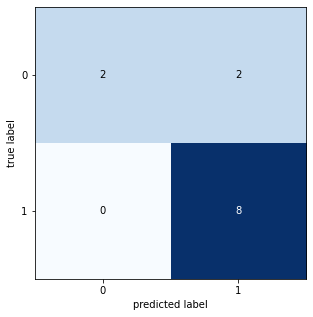

Running Time:  3.3164961930000345
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



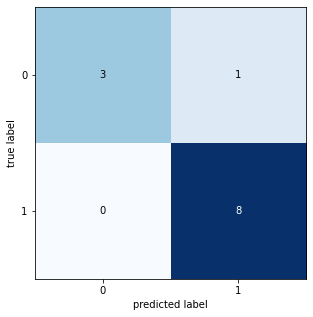

Running Time:  3.2773494729999584
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



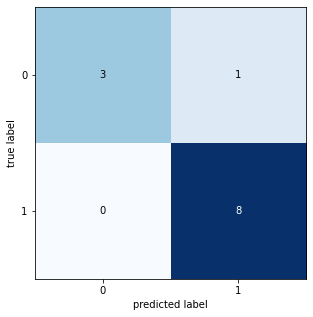

Running Time:  5.6151269639999555
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



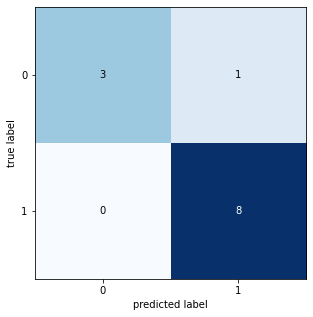

Running Time:  5.807178751999913
gen terbaik : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 51

Generation : 2
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

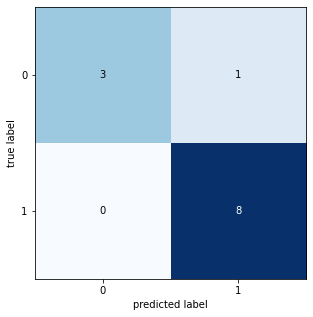

Running Time:  4.529641943999991
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



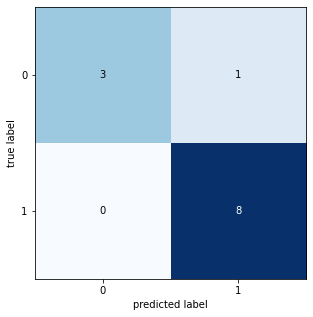

Running Time:  3.3508452940000097
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



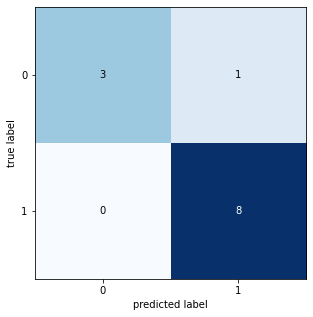

Running Time:  3.6380427959999224
gene : [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



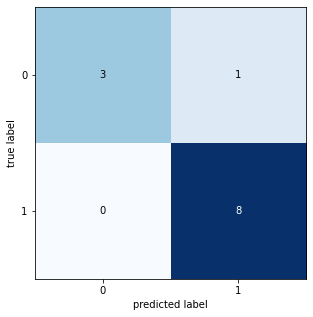

Running Time:  2.9256501130000743
gene : [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



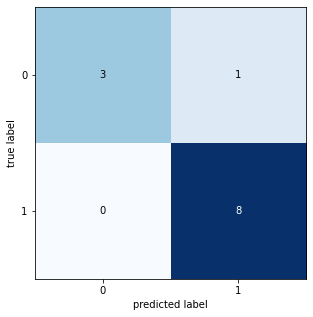

Running Time:  3.2716334730000654
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.80      1.00      0.89         8

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



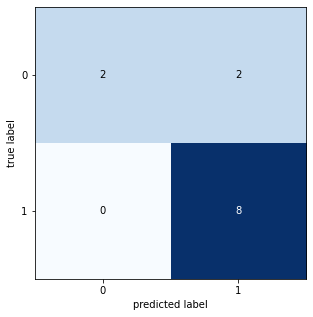

Running Time:  3.3572225599999683
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



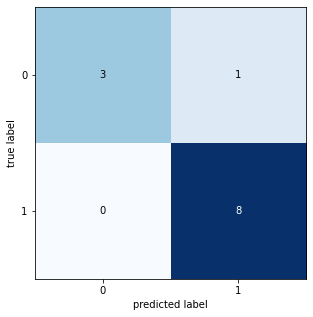

Running Time:  3.6382267579999734
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



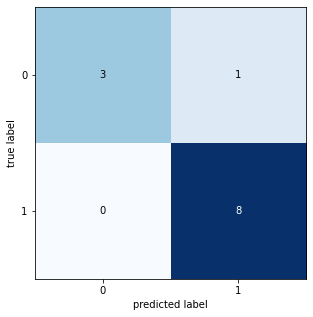

Running Time:  3.58084484099993
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



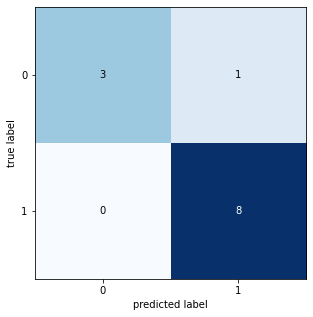

Running Time:  3.615596670000059
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



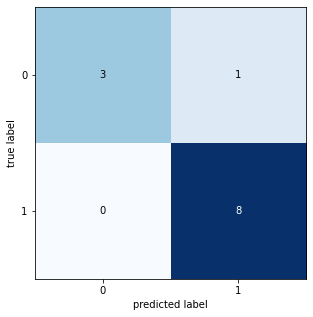

Running Time:  4.840237794000018
gen terbaik : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 56

Generation : 3
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

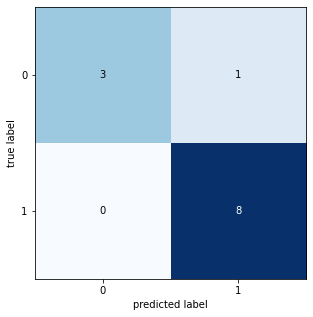

Running Time:  3.456351275999964
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



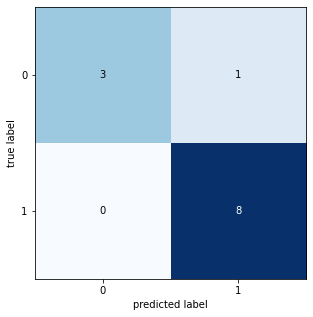

Running Time:  3.1632212649999474
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



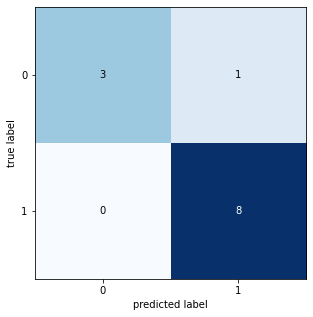

Running Time:  3.2072050450000233
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



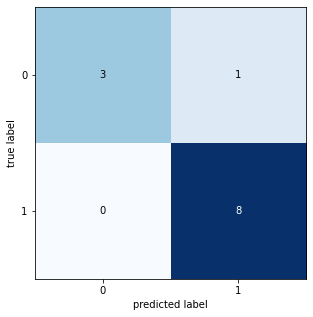

Running Time:  2.981423606000021
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



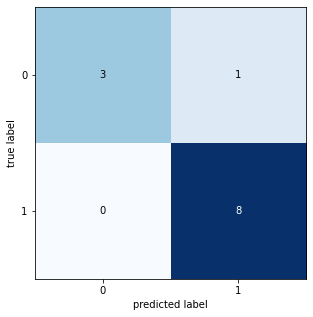

Running Time:  3.034802809000098
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



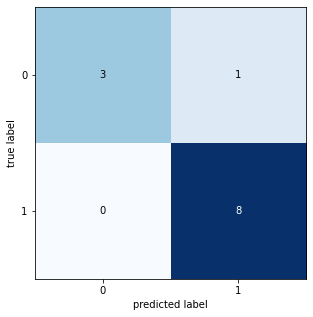

Running Time:  3.2782440579999275
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



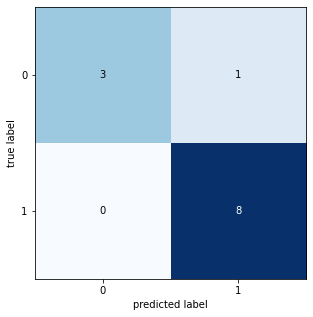

Running Time:  3.24221199800013
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



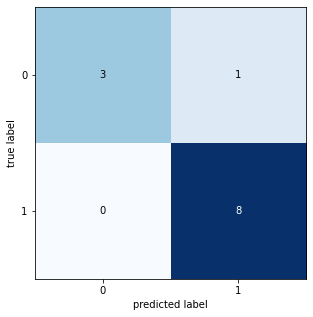

Running Time:  2.9280375460000414
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



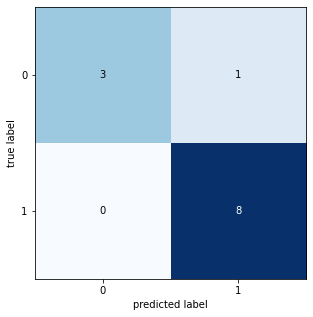

Running Time:  3.0849026979999508
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



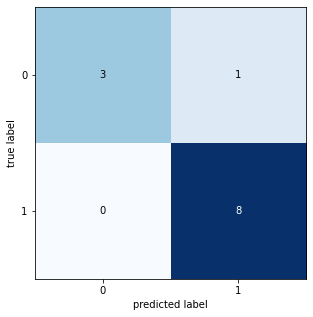

Running Time:  3.4268745439999293
gen terbaik : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 52

Generation : 4
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

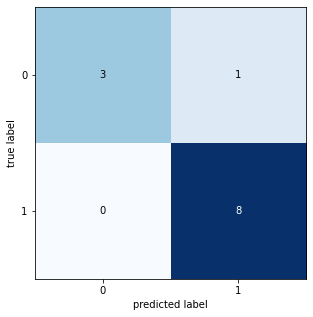

Running Time:  5.757739238000113
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



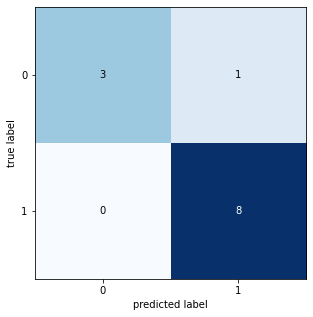

Running Time:  3.577139033000094
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



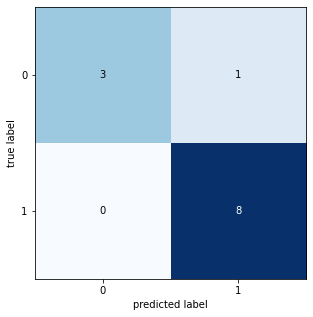

Running Time:  3.50074824599983
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



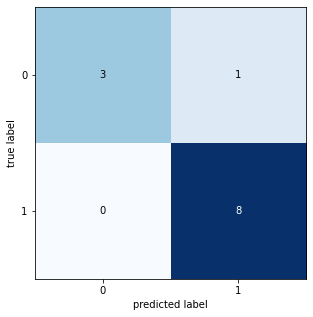

Running Time:  3.654992493000009
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



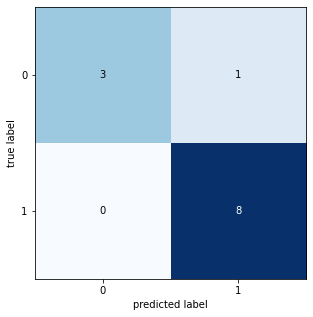

Running Time:  5.261655216000008
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



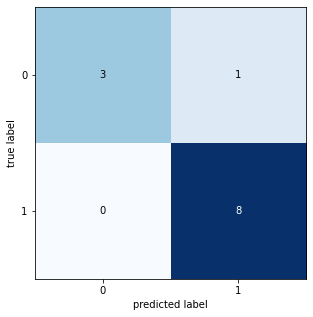

Running Time:  3.505893600000036
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



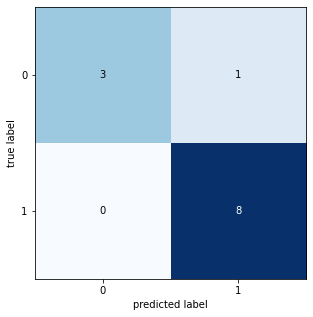

Running Time:  2.7542088079999303
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



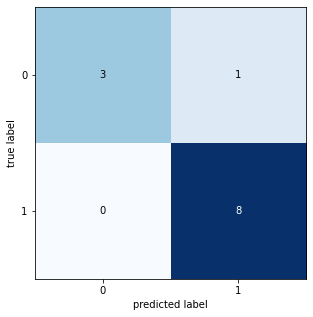

Running Time:  2.7413531409999905
gene : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



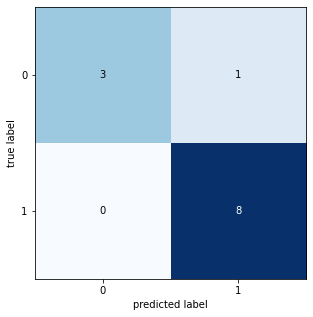

Running Time:  3.244401082999957
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



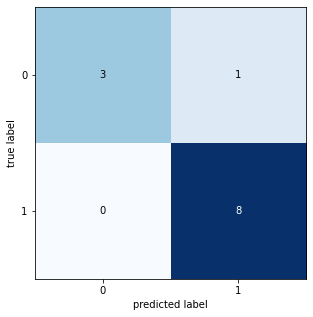

Running Time:  3.1206977189999634
gen terbaik : [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 55

Running Time:  186.9303704639999
colon + IG + GA Orde 4
Generation : 0
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.91666666

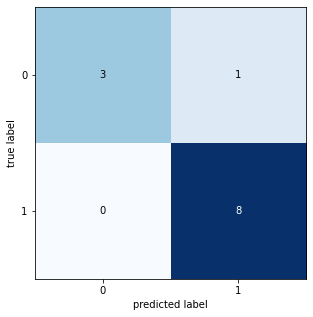

Running Time:  3.8854313199999524
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



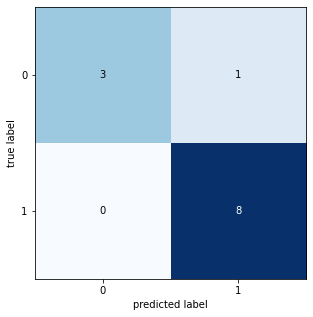

Running Time:  5.764738492000106
gene : [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



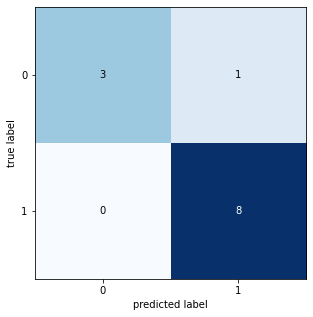

Running Time:  4.223062094999932
gene : [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



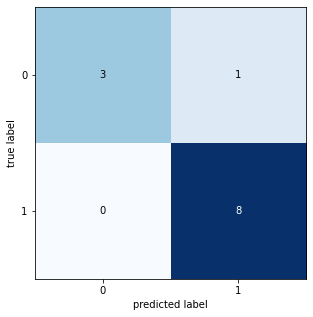

Running Time:  3.799494657999958
gene : [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



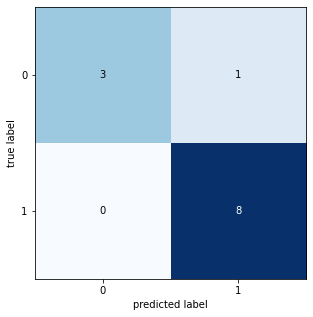

Running Time:  3.502232956999933
gene : [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



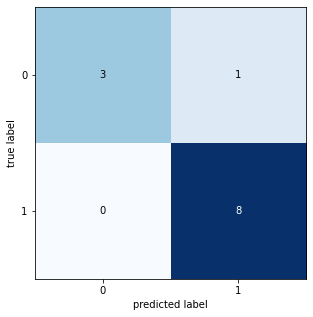

Running Time:  3.2045274710001195
gene : [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



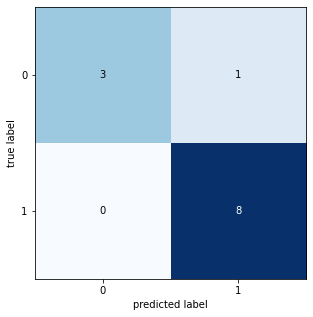

Running Time:  3.3072592910000367
gene : [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



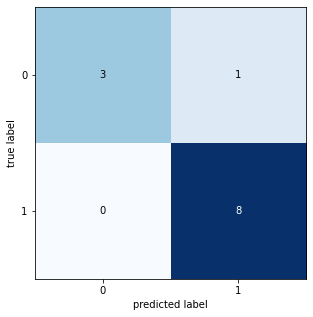

Running Time:  4.396862908999992
gene : [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



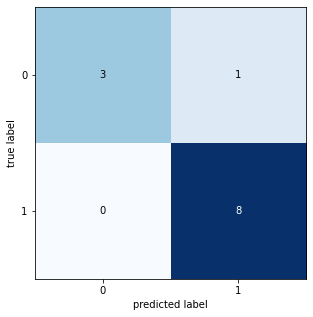

Running Time:  3.617879807999998
gene : [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



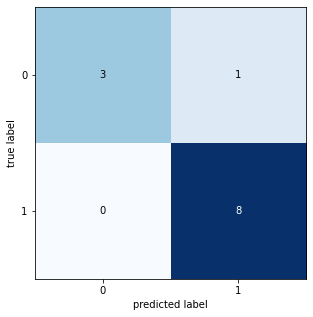

Running Time:  3.8493346489999567
gen terbaik : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 50

Generation : 1
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

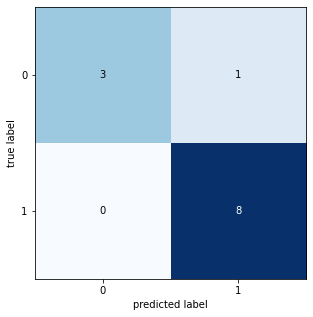

Running Time:  3.300312371000018
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



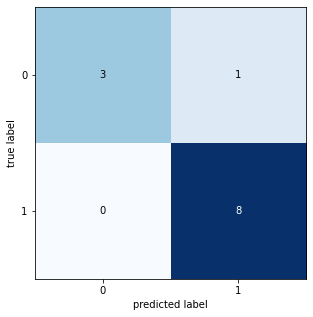

Running Time:  3.0243385999999646
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



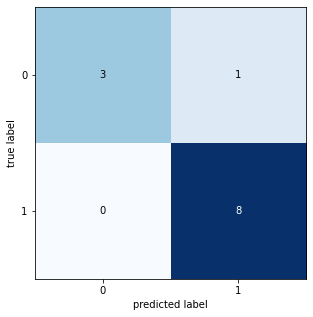

Running Time:  3.829691946000139
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



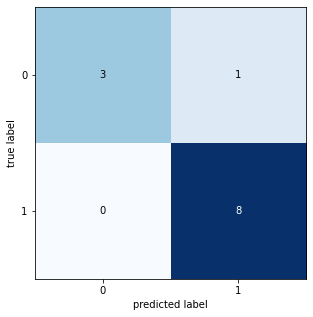

Running Time:  3.1249240470001496
gene : [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



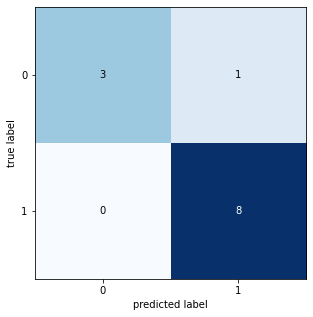

Running Time:  3.181095038000194
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



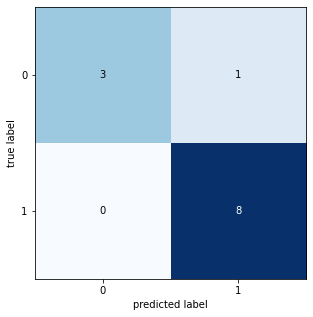

Running Time:  3.376782162999916
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



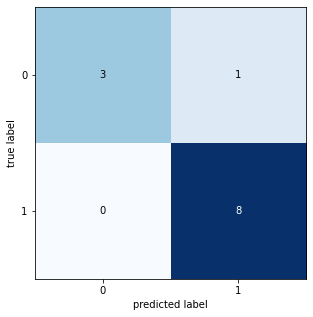

Running Time:  3.0232880559999558
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



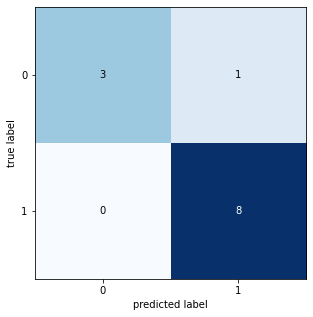

Running Time:  3.3990090239999518
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



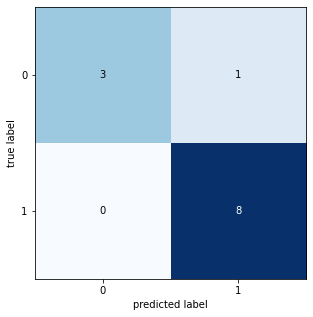

Running Time:  3.138943715999858
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



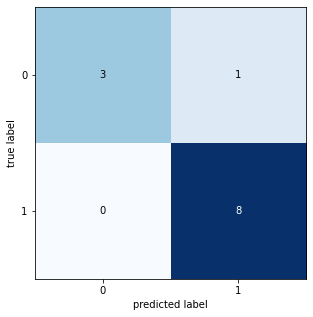

Running Time:  3.0417599660001997
gen terbaik : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 56

Generation : 2
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pr

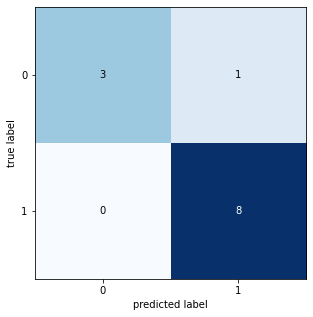

Running Time:  3.44999546300005
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



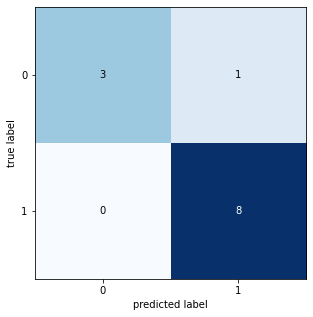

Running Time:  5.300029280999979
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



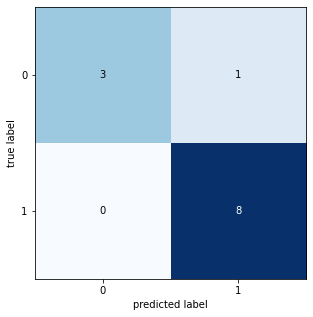

Running Time:  3.9886188779998974
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



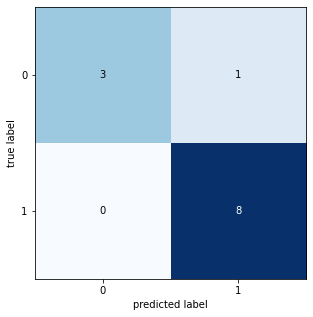

Running Time:  3.6762815550000596
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



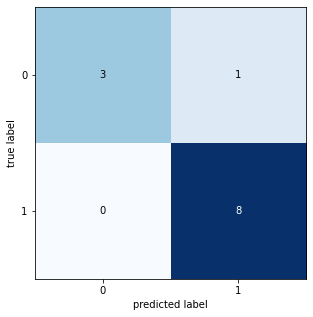

Running Time:  3.114576355999816
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



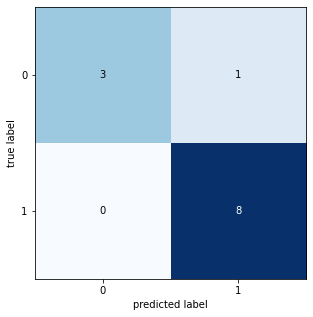

Running Time:  3.2422233489999144
gene : [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



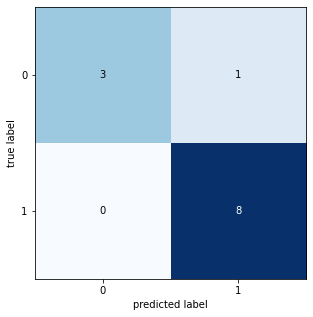

Running Time:  3.93895482899984
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



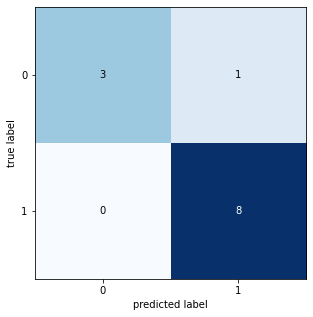

Running Time:  3.4462854329999573
gene : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



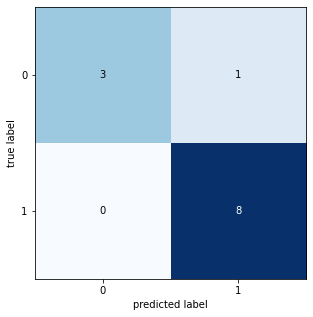

Running Time:  3.492156582000007
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



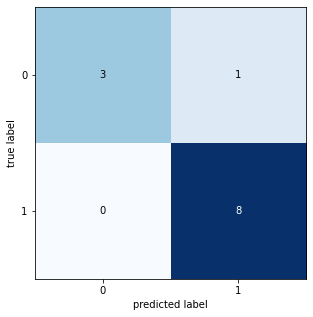

Running Time:  3.265354727000158
gen terbaik : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 56

Generation : 3
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

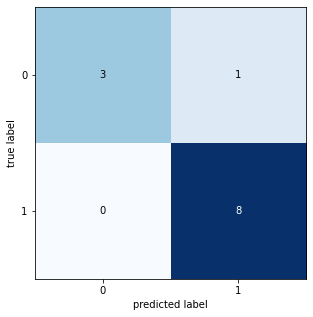

Running Time:  3.8343508549999115
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



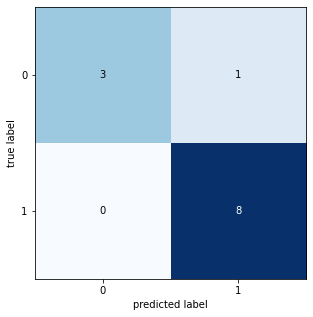

Running Time:  4.100825927999949
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



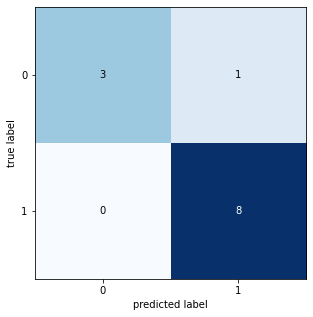

Running Time:  3.3602720559999852
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



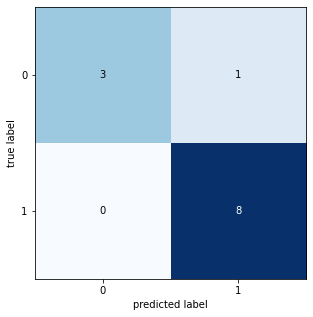

Running Time:  3.6882689560000017
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



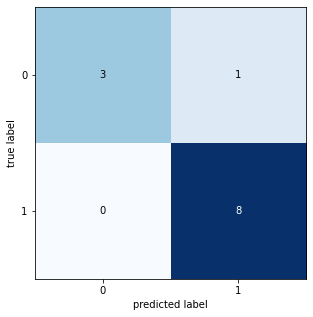

Running Time:  3.5396364460000314
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



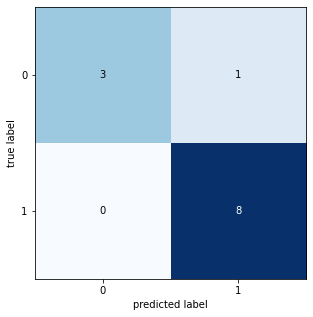

Running Time:  3.246014567999964
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



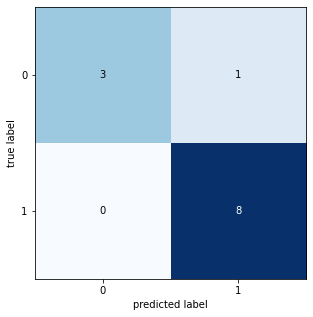

Running Time:  3.7457258649999403
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



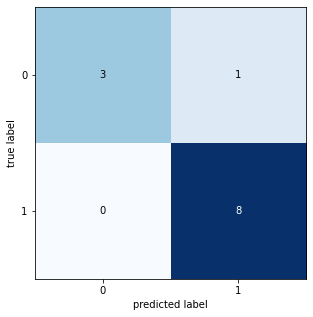

Running Time:  3.5342474160001984
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



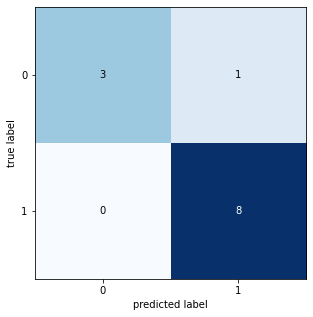

Running Time:  4.5817401920000975
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



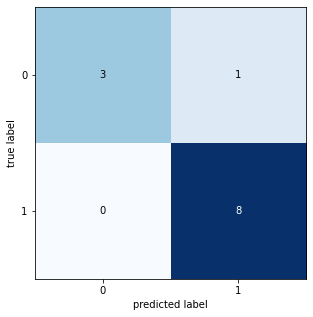

Running Time:  4.374803551000014
gen terbaik : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 54

Generation : 4
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              pre

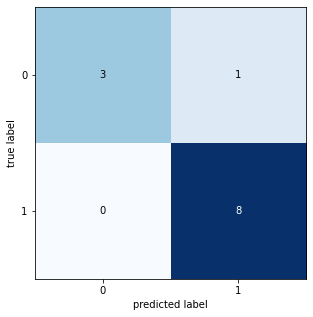

Running Time:  3.2989142660001107
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



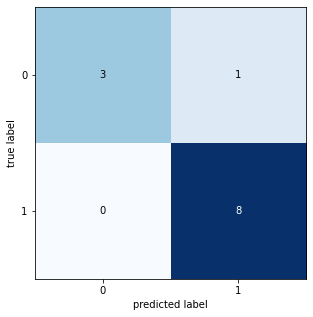

Running Time:  3.3071166839999933
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



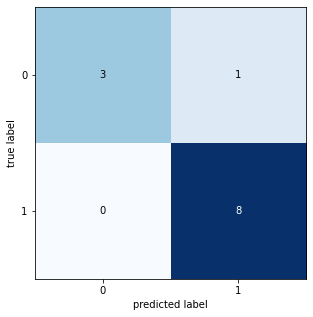

Running Time:  4.042578649999996
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



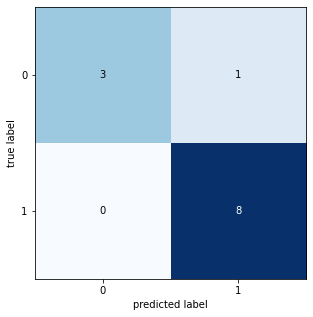

Running Time:  3.206452810999963
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



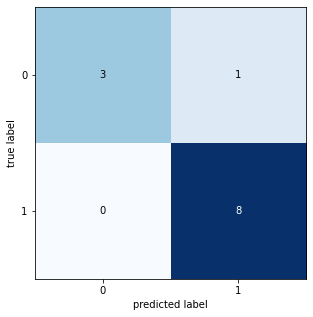

Running Time:  4.65874424399999
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



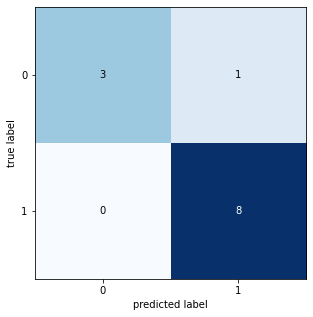

Running Time:  4.4839321029999155
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



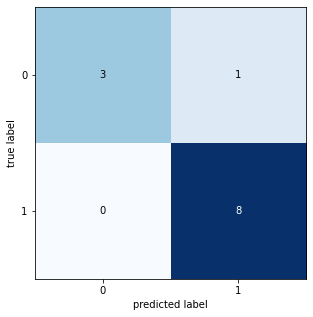

Running Time:  3.5196317120000913
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



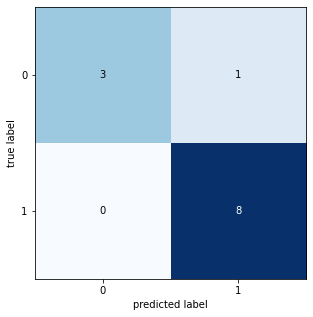

Running Time:  3.5055687179999495
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



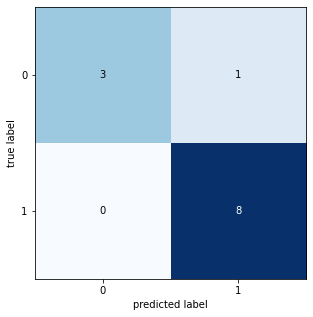

Running Time:  4.005230092000147
gene : [0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 0]
Y_Test : [0 1 1 1 1 1 1 1 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



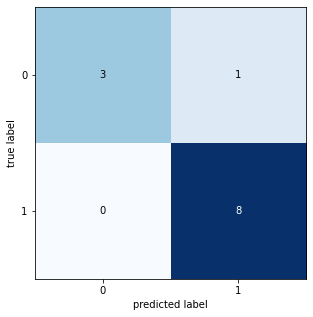

Running Time:  4.169961786000158
gen terbaik : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.8991596638655461  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 54

Running Time:  188.43663978099994
Train :  [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test :  [ 2  6  7 11 13 14 16 45 49 51 52 55]
train:  (50, 101)
test:  (12, 101)
Running Time:  7.283005702000082
colon + IG Orde 2
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
           

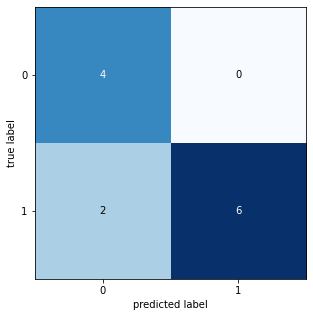

Running Time:  4.017833061999909
colon + IG Orde 3
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



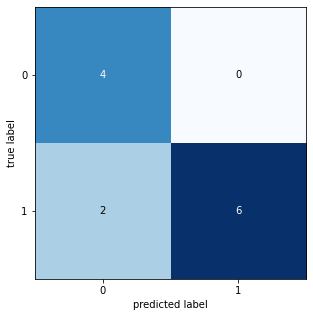

Running Time:  4.103740044000006
colon + IG Orde 4
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



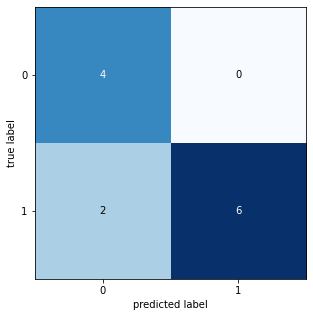

Running Time:  4.465645042000006
colon + IG + GA Orde 2
Generation : 0
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



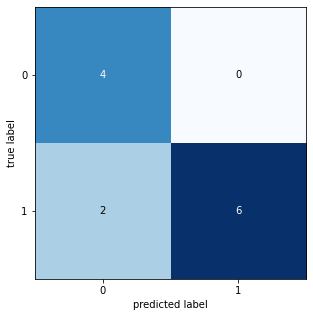

Running Time:  5.063904066000077
gene : [0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



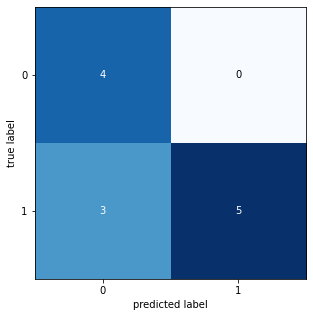

Running Time:  5.728667933999986
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



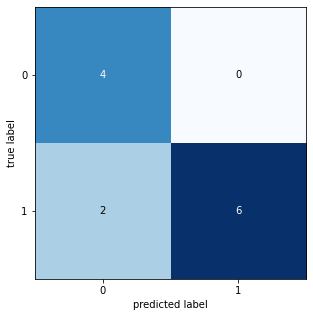

Running Time:  3.7380382310000186
gene : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



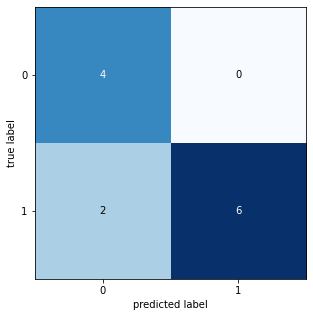

Running Time:  4.008231926000008
gene : [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



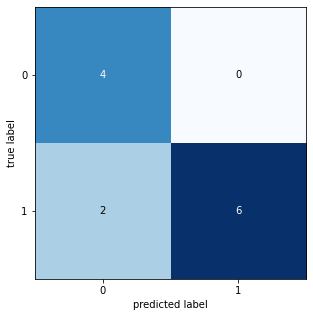

Running Time:  3.2705071789998783
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



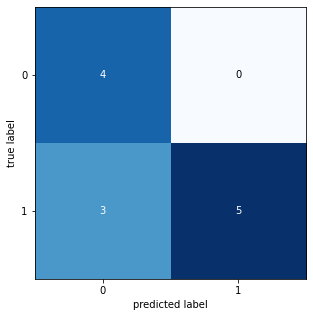

Running Time:  3.1101825970001755
gene : [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



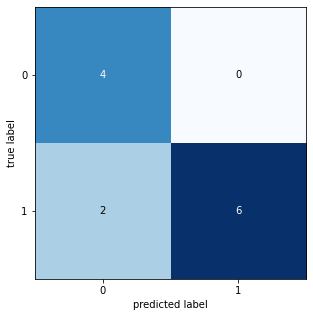

Running Time:  2.9434959549998894
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



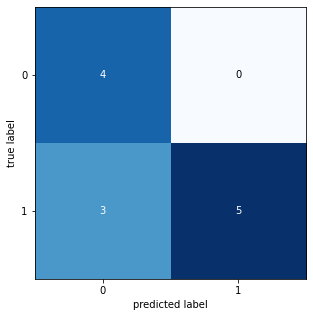

Running Time:  3.4242548720001196
gene : [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



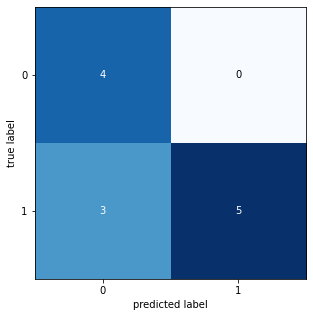

Running Time:  5.254501741000013
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



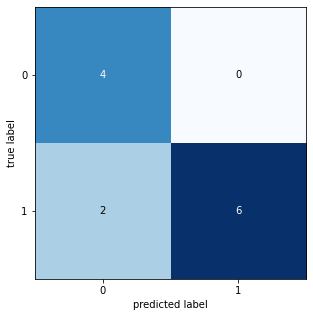

Running Time:  3.55190595199997
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 46

Generation : 1
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              prec

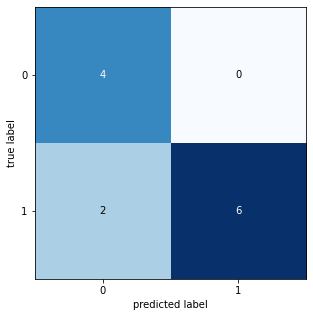

Running Time:  3.7753865990000577
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



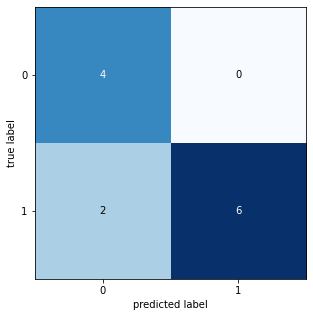

Running Time:  3.22677746699992
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



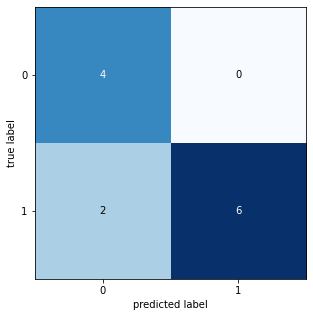

Running Time:  3.2064100180000423
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



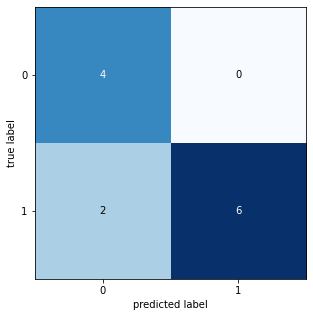

Running Time:  3.031284180000057
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



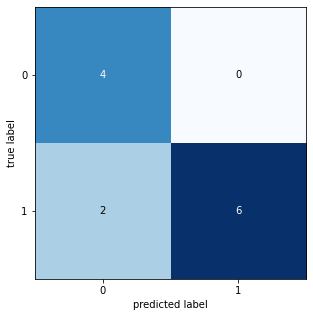

Running Time:  3.5936555719999888
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



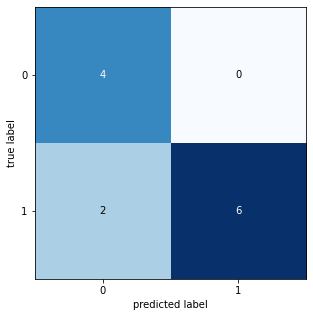

Running Time:  3.0544740210000327
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



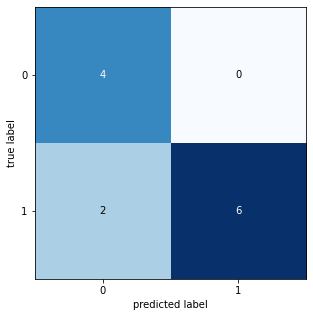

Running Time:  3.1006156539999665
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



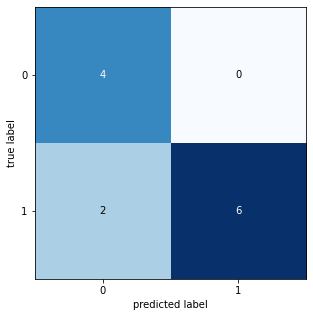

Running Time:  2.974425649000068
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



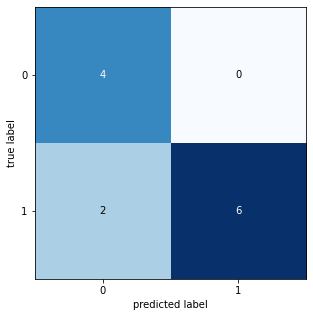

Running Time:  2.805328120000013
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



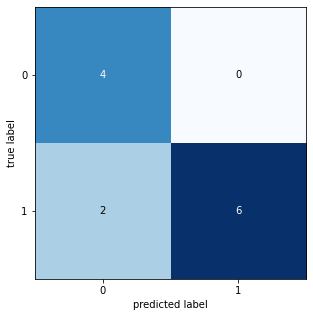

Running Time:  2.8014220390000446
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 46

Generation : 2
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

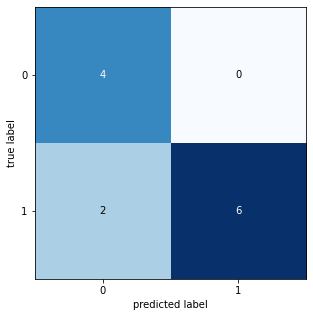

Running Time:  2.9523899099999653
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



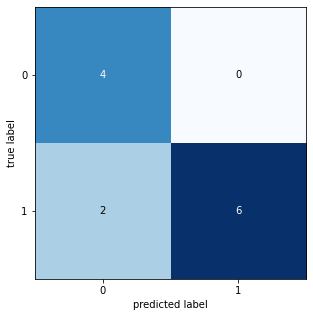

Running Time:  3.1052609819998906
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



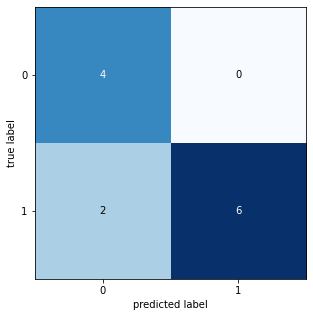

Running Time:  3.455055252999955
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



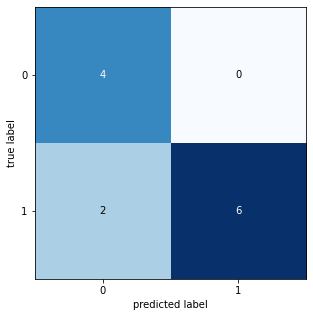

Running Time:  3.2522981019999406
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



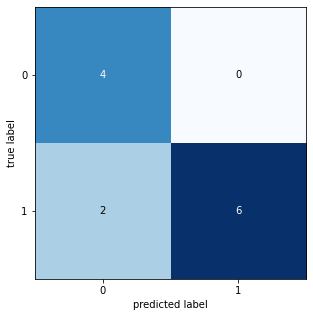

Running Time:  3.642298844999914
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



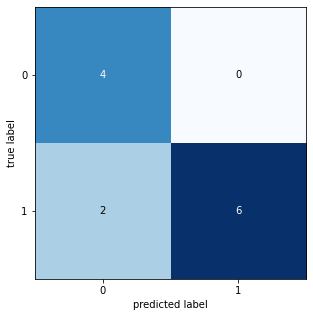

Running Time:  3.442128430000139
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



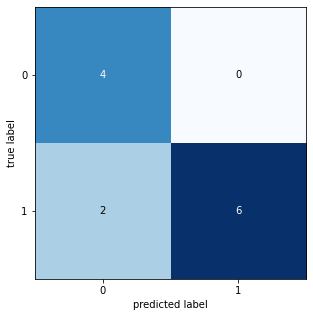

Running Time:  3.2197927809997964
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



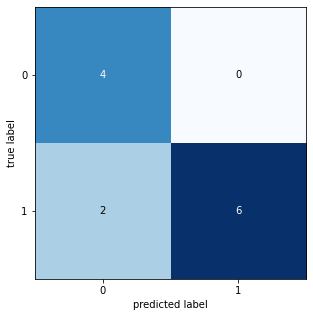

Running Time:  2.9664179240000976
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



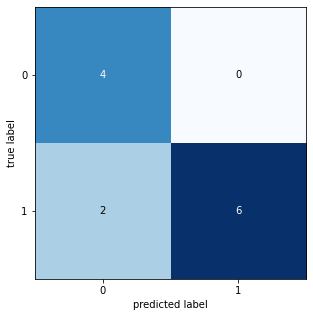

Running Time:  2.99453526100001
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



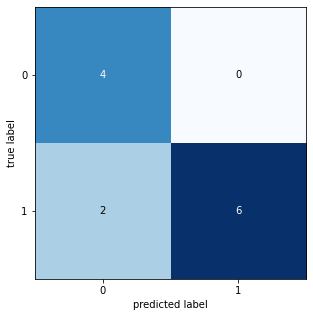

Running Time:  3.3848061329999837
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 47

Generation : 3
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

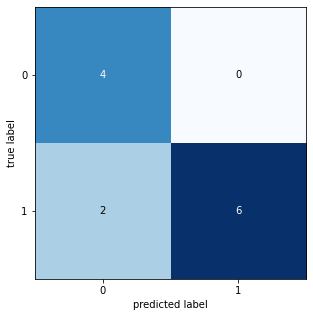

Running Time:  2.920088855000131
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



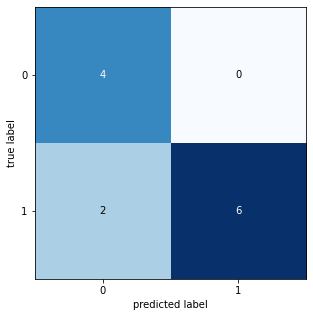

Running Time:  2.918999103000033
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



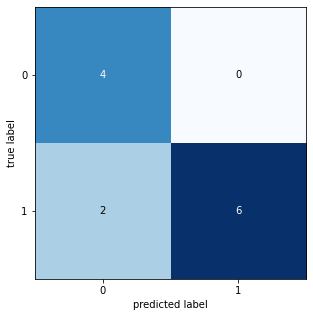

Running Time:  3.0720006930000636
gene : [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



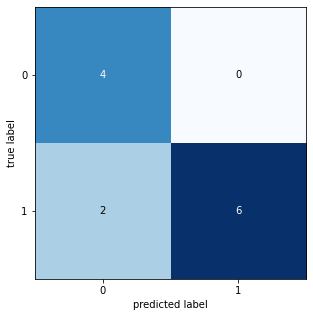

Running Time:  2.98303542199983
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



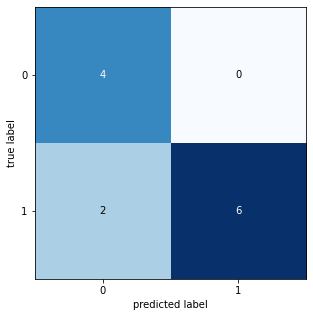

Running Time:  2.9928708229999756
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



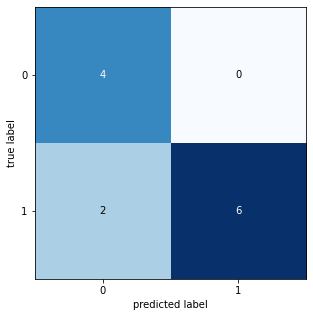

Running Time:  3.1192062580000766
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



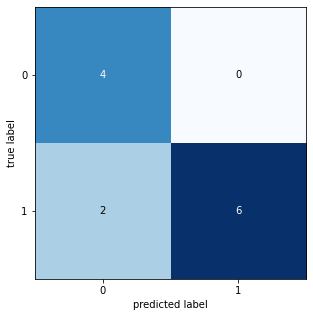

Running Time:  3.169945971999823
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



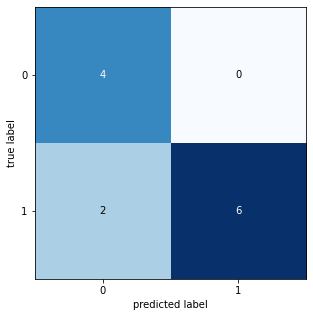

Running Time:  3.297145695999916
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



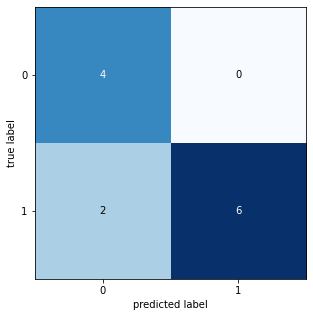

Running Time:  2.834053972999982
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



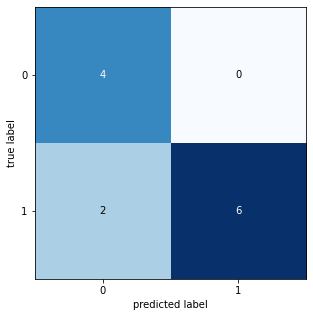

Running Time:  3.272002496999903
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 47

Generation : 4
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

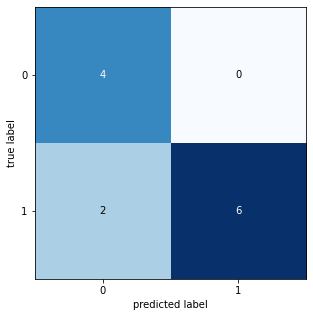

Running Time:  3.0299660940002013
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



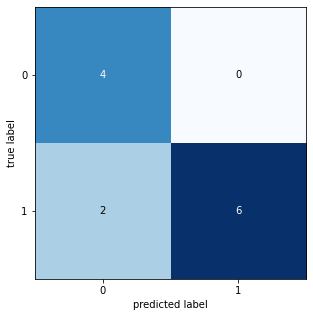

Running Time:  3.131201859000157
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



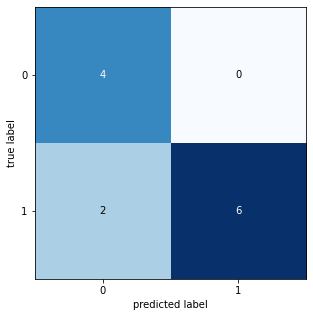

Running Time:  3.0610005140001704
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



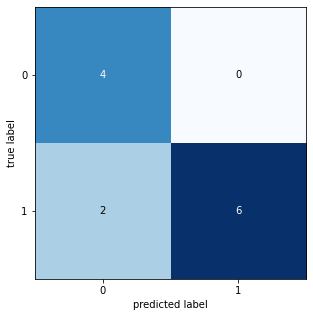

Running Time:  3.1614795959999356
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



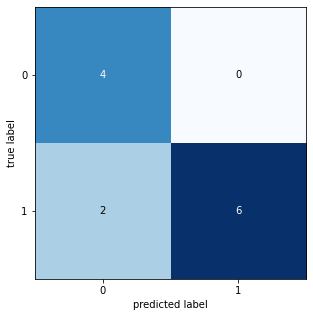

Running Time:  3.26999525500014
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.62      0.77         8

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



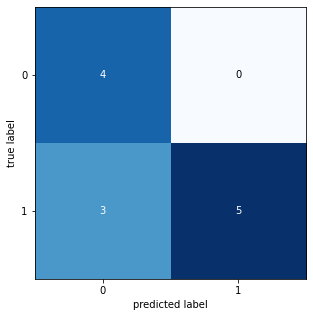

Running Time:  3.1876707460000944
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



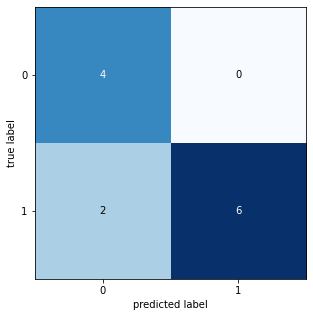

Running Time:  3.8128625340000326
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



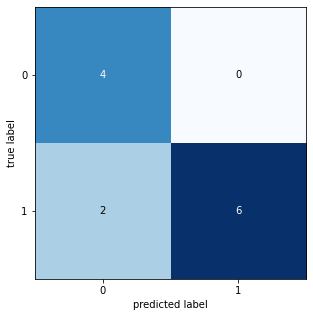

Running Time:  3.191118465000045
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



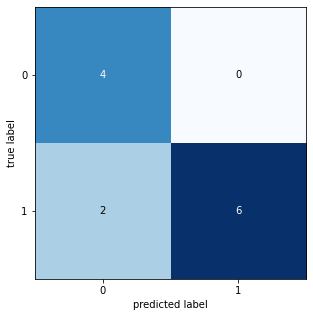

Running Time:  3.211857597000062
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



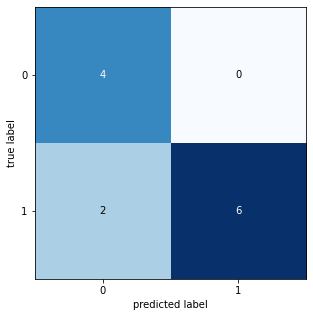

Running Time:  3.14178538200008
gen terbaik : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 48

Running Time:  170.36043158200005
colon + IG + GA Orde 3
Generation : 0
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.833333333

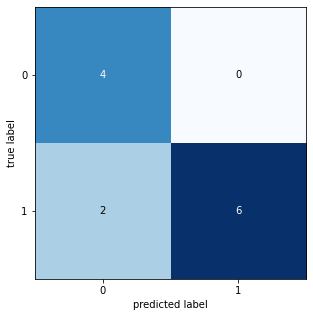

Running Time:  3.262346602999969
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



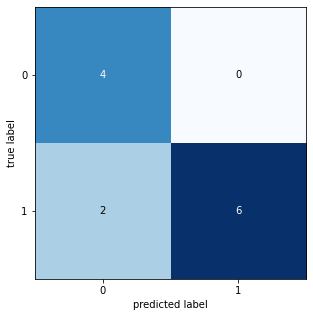

Running Time:  3.1109053919999496
gene : [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



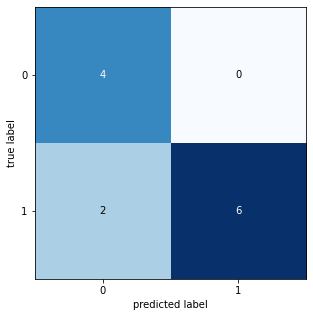

Running Time:  2.963477279000017
gene : [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



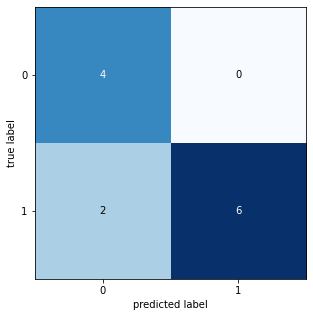

Running Time:  3.178044022999984
gene : [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



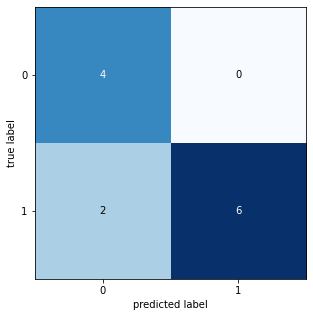

Running Time:  3.191982297000095
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



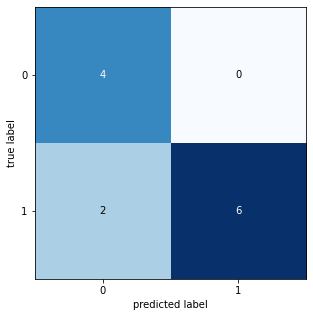

Running Time:  2.948950087999947
gene : [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



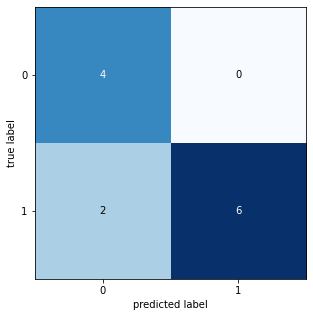

Running Time:  3.0552125099998193
gene : [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



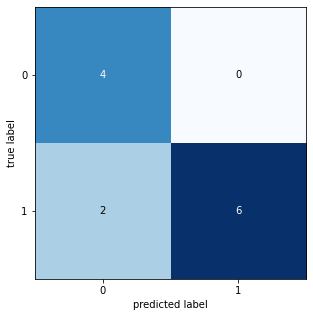

Running Time:  3.080978397999843
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



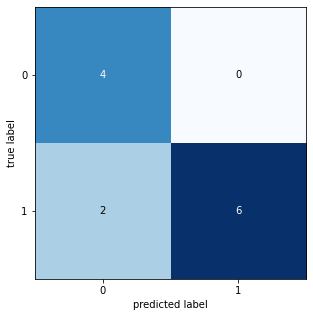

Running Time:  3.05222542599995
gene : [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



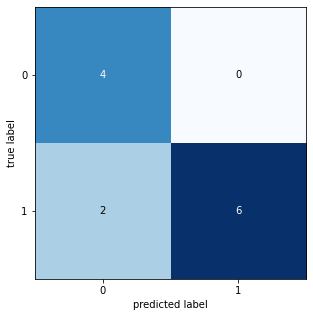

Running Time:  3.437363215000005
gen terbaik : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 52

Generation : 1
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

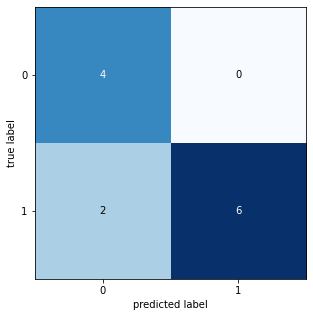

Running Time:  3.4673710409999785
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



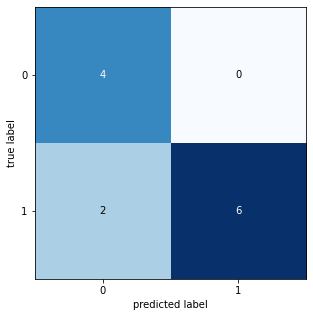

Running Time:  3.465319736000083
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



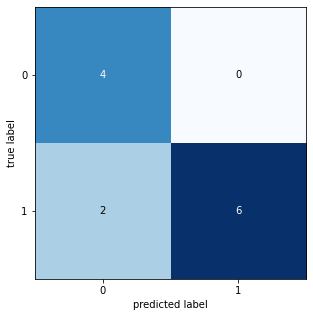

Running Time:  3.35090018599999
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



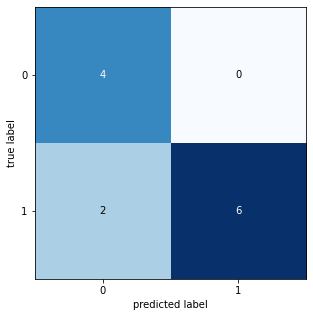

Running Time:  3.4634833620000336
gene : [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



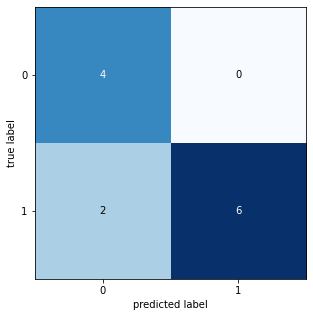

Running Time:  3.204530158999887
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



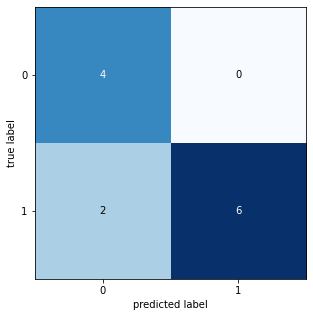

Running Time:  3.07416619300011
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



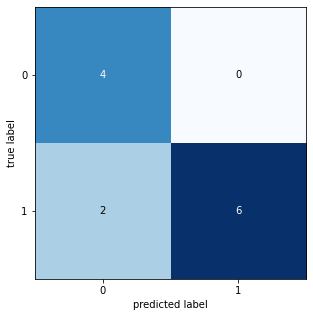

Running Time:  2.945243906000087
gene : [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



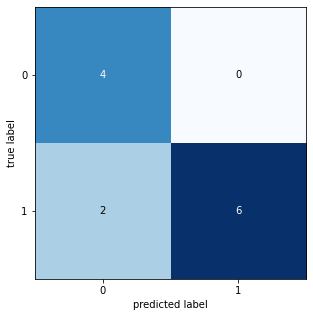

Running Time:  3.3605812470000274
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



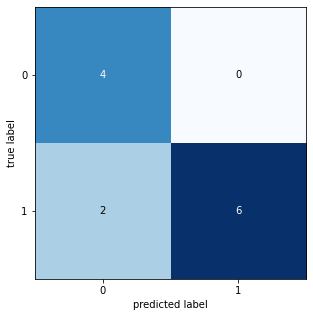

Running Time:  3.0427392200001577
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



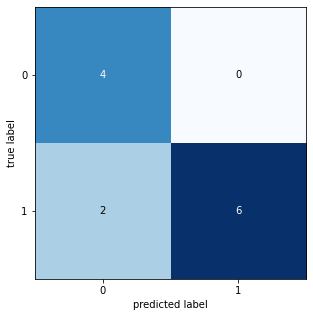

Running Time:  3.213856871999951
gen terbaik : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 52

Generation : 2
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

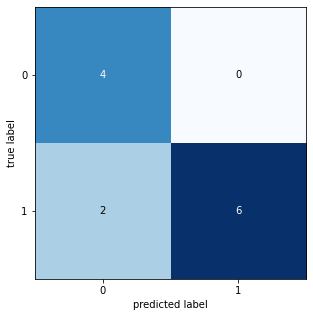

Running Time:  3.1173645230001057
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



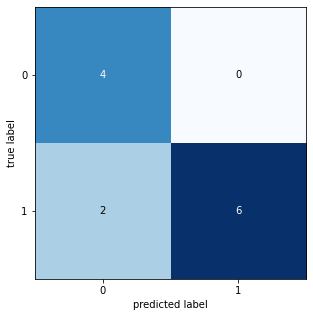

Running Time:  3.2304717810000056
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



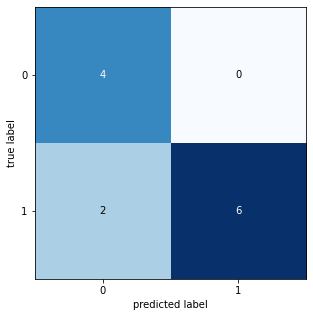

Running Time:  3.048471000000063
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



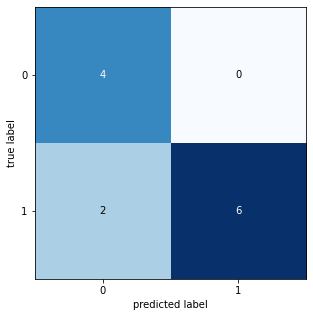

Running Time:  3.0266823510000904
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



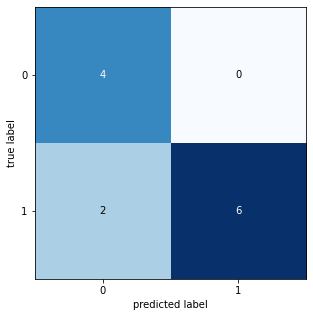

Running Time:  3.7011555569999928
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



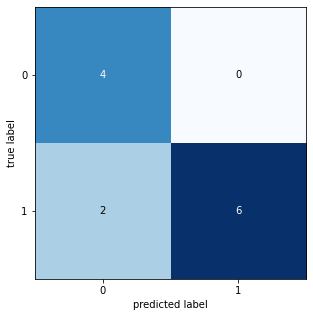

Running Time:  3.1882709399999385
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



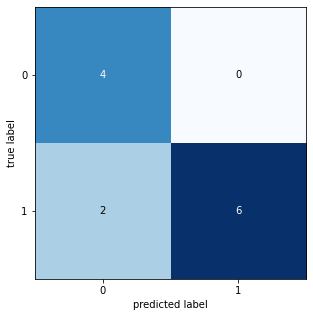

Running Time:  2.9538891950001016
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



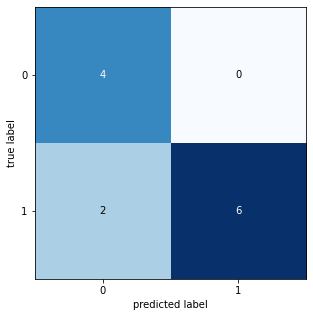

Running Time:  2.715460837999899
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



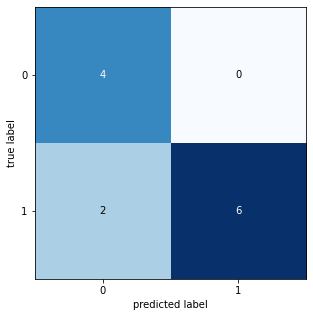

Running Time:  2.748846158999868
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



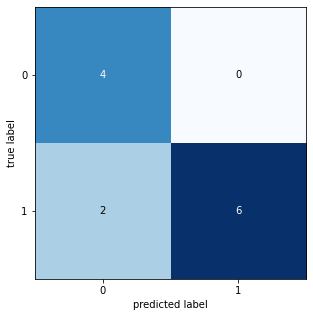

Running Time:  2.8501930939999056
gen terbaik : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 52

Generation : 3
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

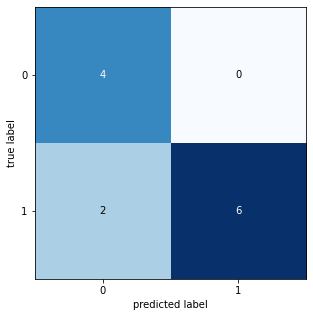

Running Time:  2.8815823800000544
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



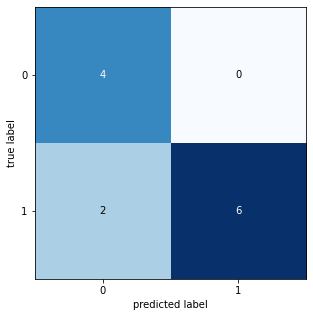

Running Time:  3.249718557000051
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



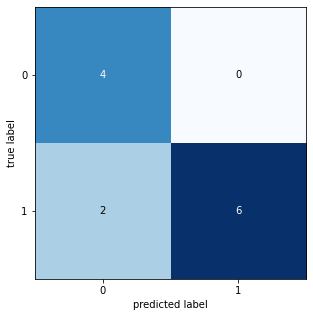

Running Time:  3.4017084249999243
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



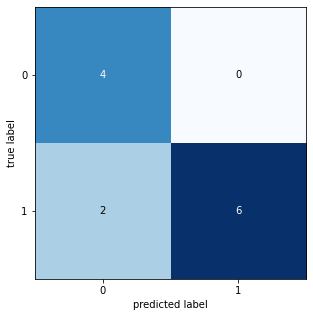

Running Time:  3.7225628480000523
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



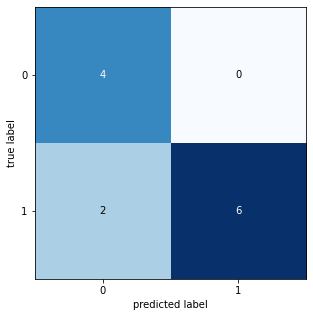

Running Time:  3.3362462609998147
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



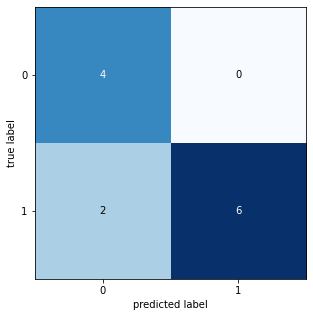

Running Time:  3.206637919999821
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



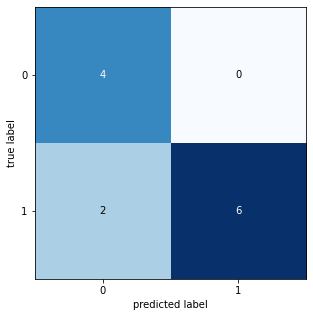

Running Time:  3.372274528000162
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



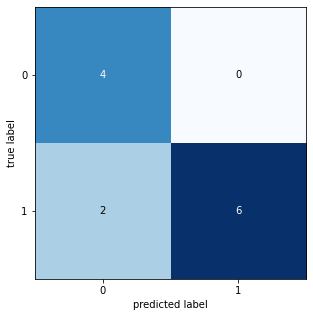

Running Time:  3.512219863999917
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



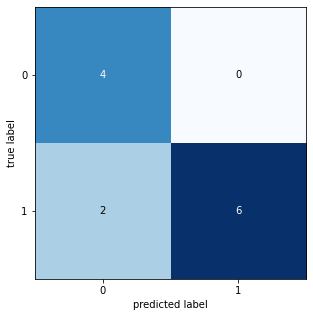

Running Time:  2.8240361360001316
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



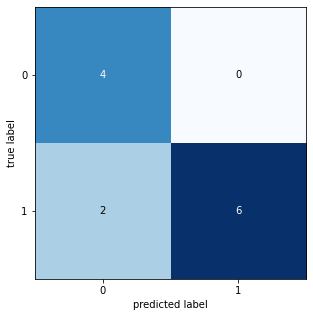

Running Time:  5.660497162000183
gen terbaik : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 51

Generation : 4
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

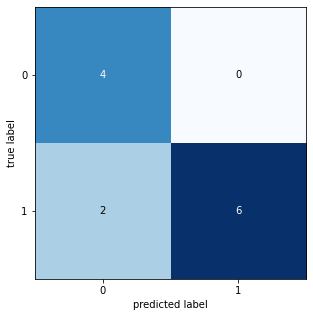

Running Time:  2.8313561180000306
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



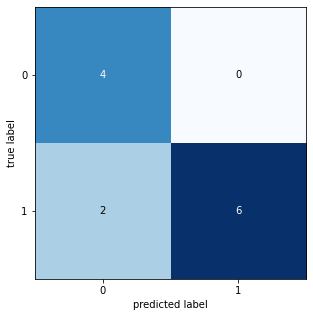

Running Time:  2.8286502200000996
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



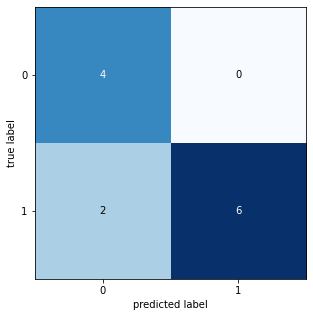

Running Time:  3.1858730409999225
gene : [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



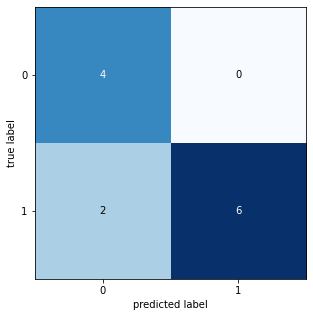

Running Time:  3.0613045499999316
gene : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



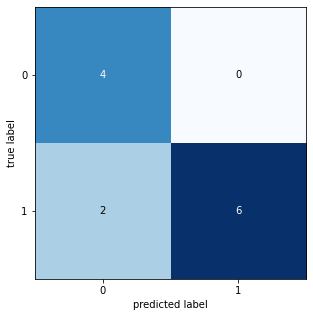

Running Time:  2.892157000999987
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



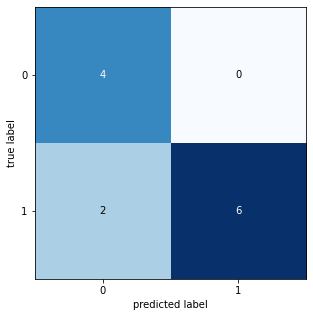

Running Time:  2.8580590779999966
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



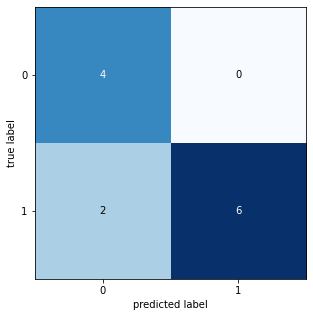

Running Time:  2.7901095180000084
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



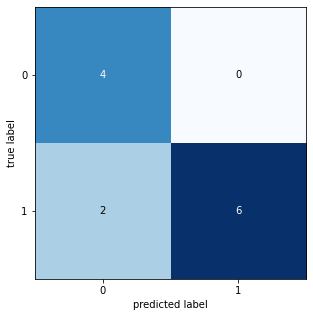

Running Time:  3.1895858810000846
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



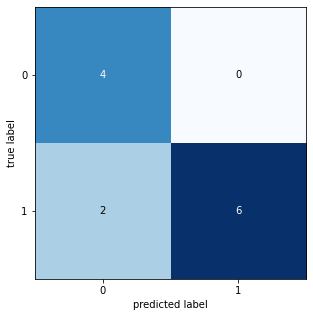

Running Time:  2.974052461999918
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



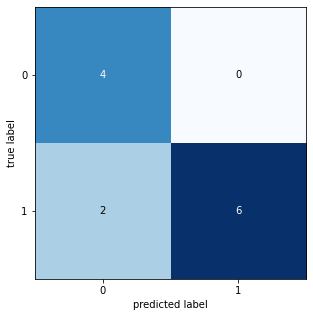

Running Time:  2.8834048160001657
gen terbaik : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 51

Running Time:  162.17794128800006
colon + IG + GA Orde 4
Generation : 0
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333

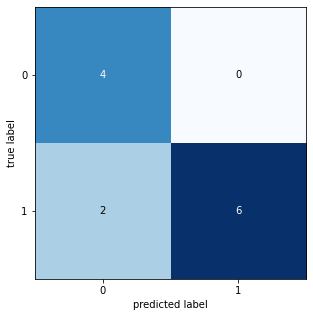

Running Time:  2.8199197810001806
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



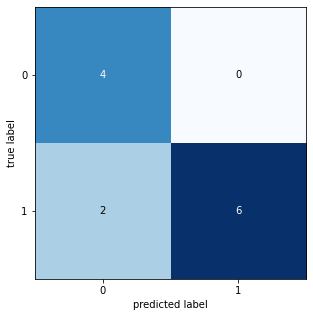

Running Time:  2.779403918000071
gene : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



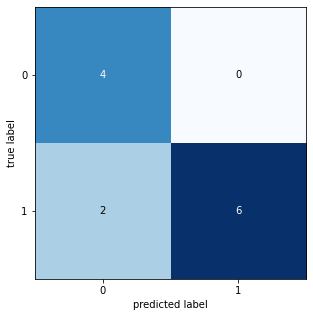

Running Time:  2.7595608700000867
gene : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



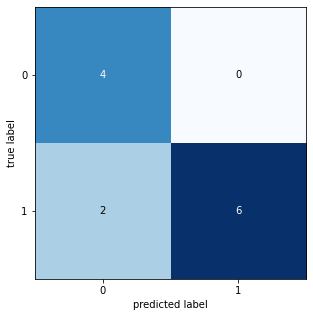

Running Time:  2.73544306399981
gene : [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



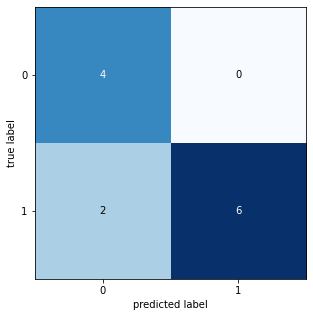

Running Time:  3.1932354749999377
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



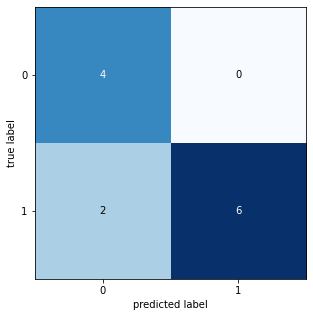

Running Time:  2.925149426999951
gene : [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



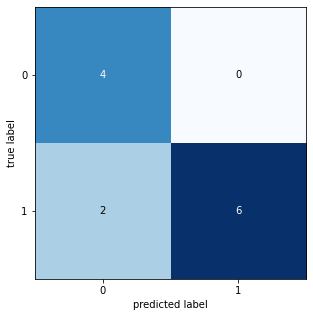

Running Time:  3.0678608260000146
gene : [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



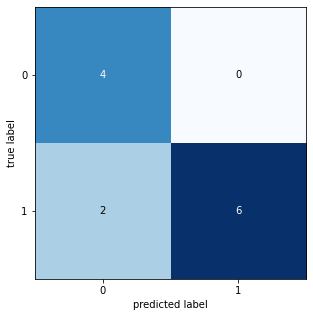

Running Time:  2.7376481589999457
gene : [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



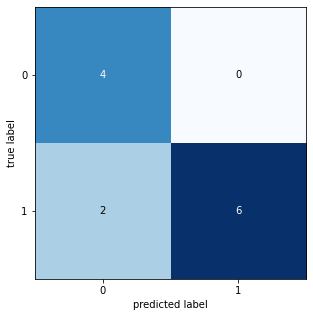

Running Time:  3.1299933209998017
gene : [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



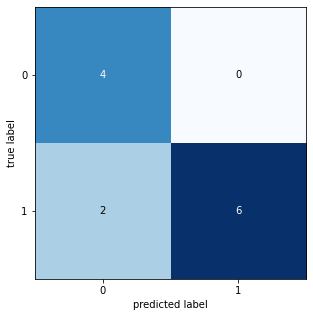

Running Time:  3.0514279710000665
gen terbaik : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 50

Generation : 1
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

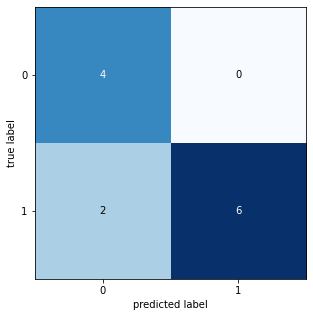

Running Time:  3.072662702000116
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



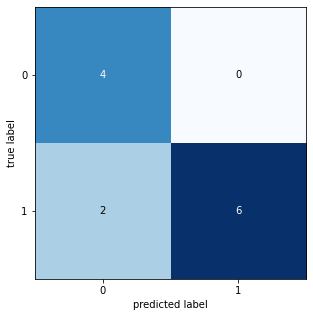

Running Time:  3.5015393399999084
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



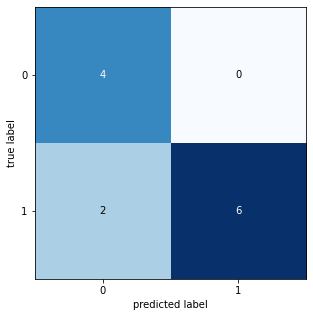

Running Time:  3.0553423390001626
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



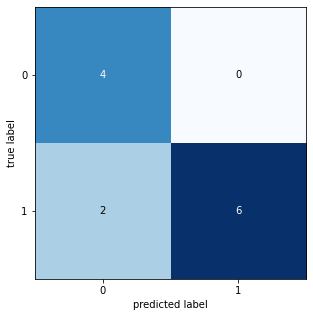

Running Time:  3.0459899150000638
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



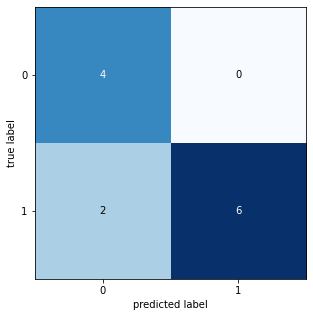

Running Time:  2.8424872819998654
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



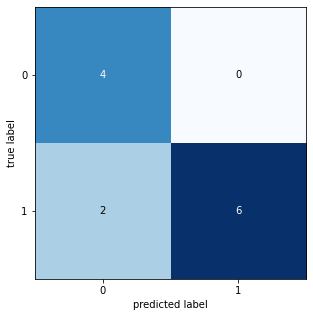

Running Time:  2.86931695699991
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



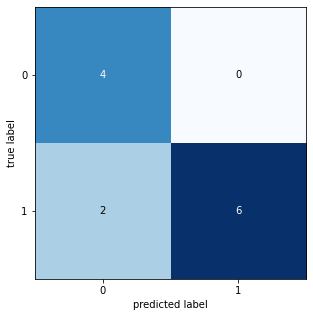

Running Time:  2.769606989000067
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



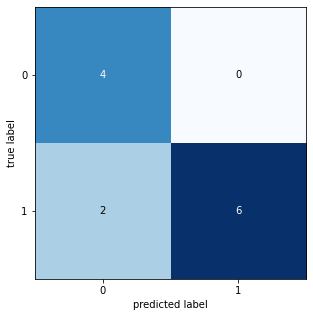

Running Time:  2.8768824169999334
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



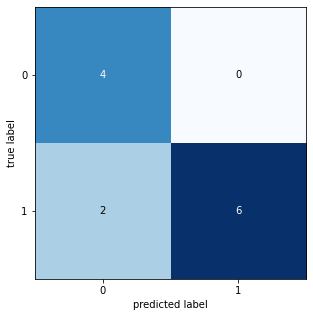

Running Time:  2.7410942059998433
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



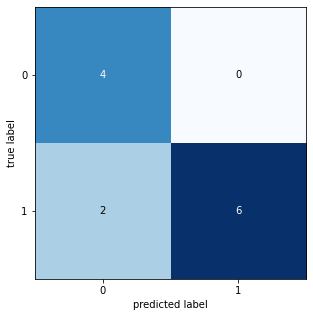

Running Time:  3.2184144249999918
gen terbaik : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 49

Generation : 2
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

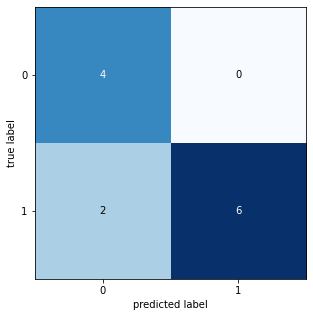

Running Time:  2.877426176999961
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



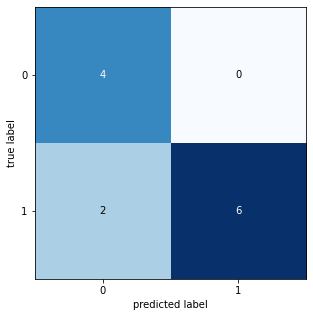

Running Time:  2.997393921000139
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



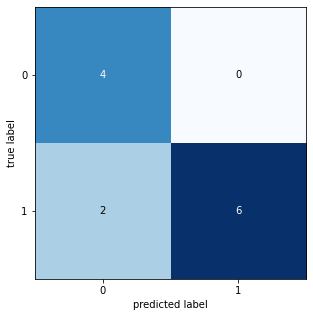

Running Time:  3.11482675000002
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



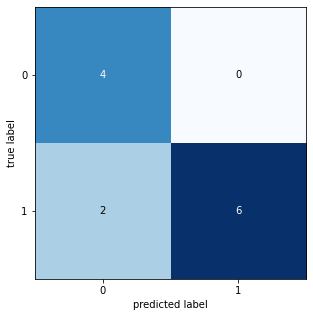

Running Time:  3.042345614000169
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



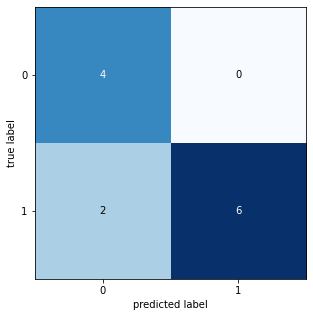

Running Time:  5.202846020999914
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



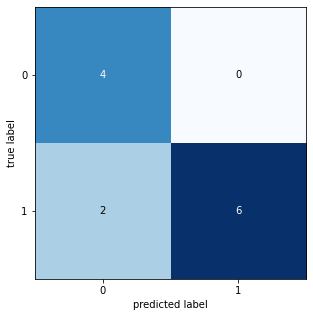

Running Time:  3.6186844039998505
gene : [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



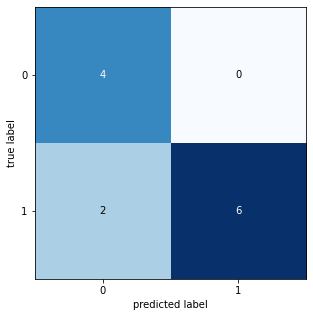

Running Time:  4.094905524000069
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



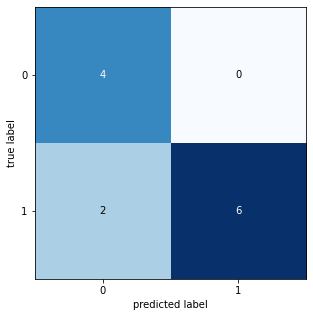

Running Time:  4.006371547000072
gene : [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



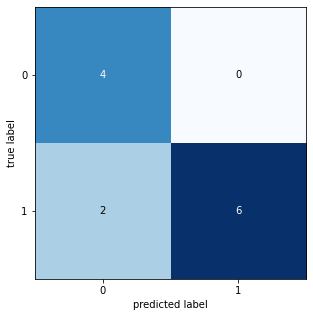

Running Time:  3.514043150000134
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



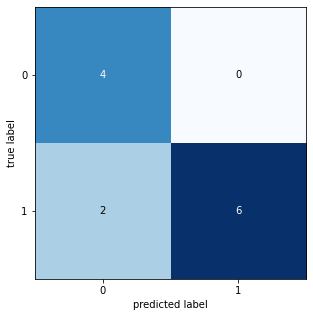

Running Time:  2.861662163999881
gen terbaik : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 55

Generation : 3
gene : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pre

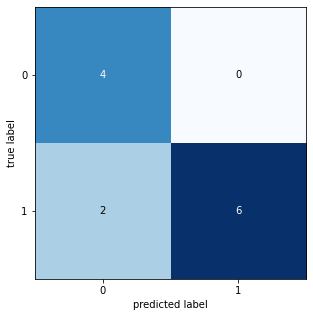

Running Time:  2.7546382440000343
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



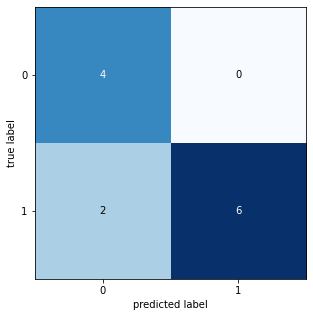

Running Time:  3.0774824939999235
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



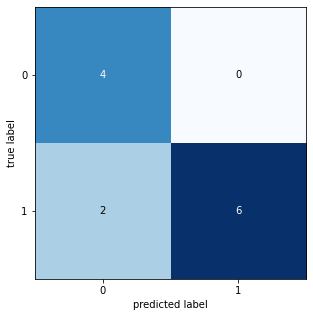

Running Time:  5.814930628999946
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



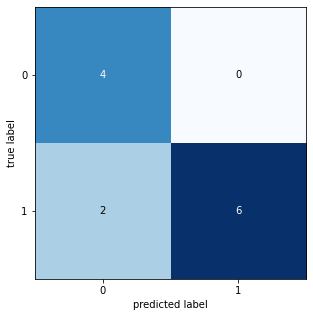

Running Time:  3.0481008770000244
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



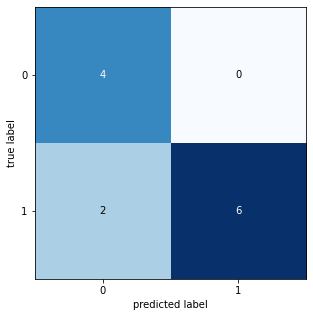

Running Time:  3.560035611000103
gene : [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



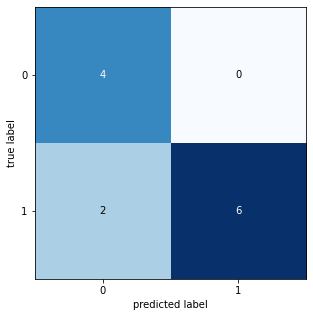

Running Time:  2.866933673999938
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



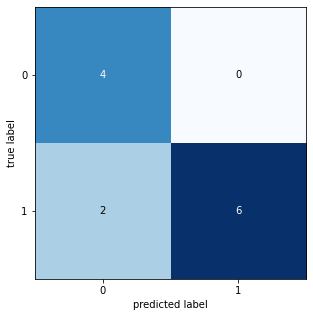

Running Time:  5.783408650999945
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



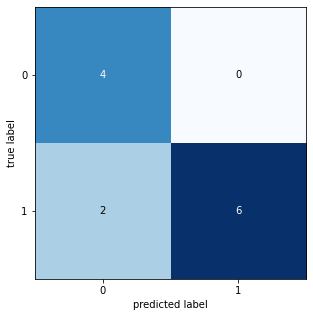

Running Time:  3.1557228789999954
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



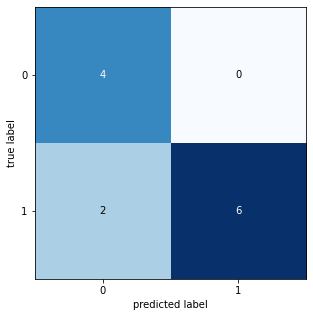

Running Time:  2.756419347000019
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



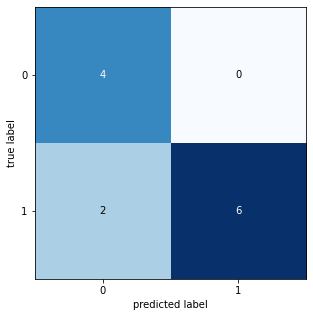

Running Time:  2.9497407530000146
gen terbaik : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 51

Generation : 4
gene : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              pr

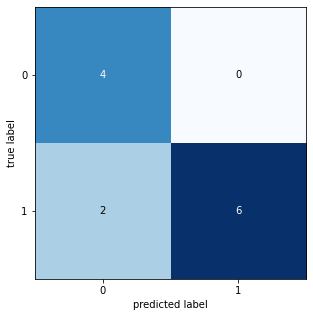

Running Time:  2.968893194999964
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



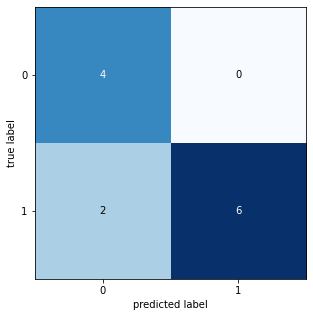

Running Time:  3.6762538269999823
gene : [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



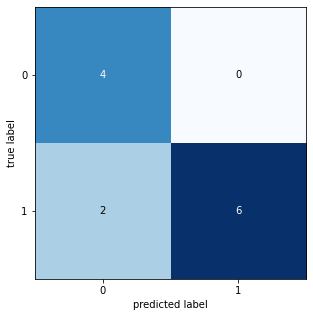

Running Time:  3.559093879000102
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



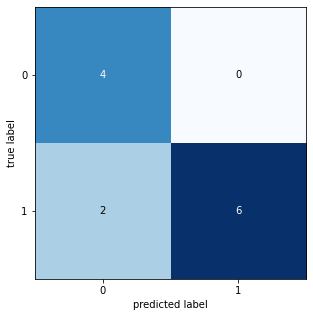

Running Time:  3.3538664720001634
gene : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



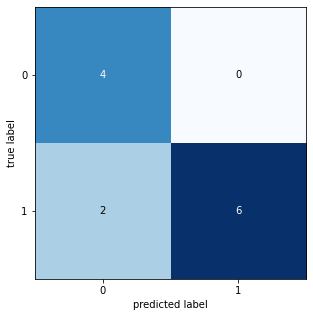

Running Time:  3.357887222000045
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



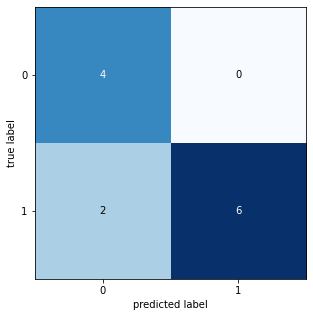

Running Time:  4.2677884750000885
gene : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



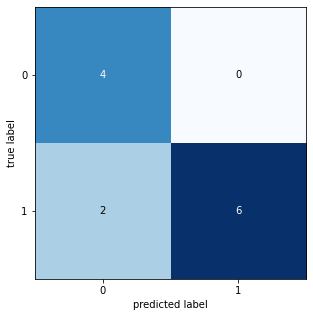

Running Time:  2.815085267000086
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



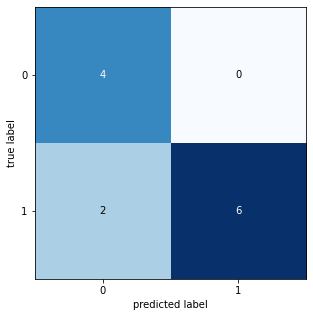

Running Time:  3.168016620999879
gene : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



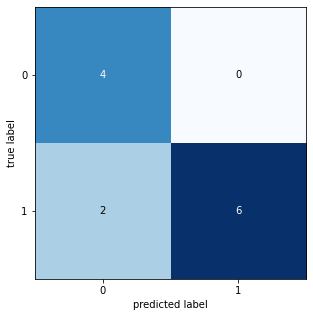

Running Time:  3.8688252540000576
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 1 0]
Y_Test : [1 1 0 0 0 1 1 1 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



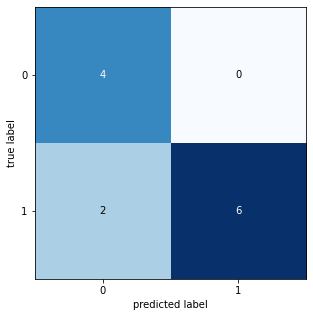

Running Time:  3.6498865360001673
gen terbaik : [1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8285714285714285  || Akurasi terbaik : 0.8333333333333334  || jumlah fitur : 51

Running Time:  167.87168644899998
Train :  [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test :  [ 1  4  5 17 27 31 37 40 43 48 58 61]
train:  (50, 101)
test:  (12, 101)
Running Time:  4.195254445000046
colon + IG Orde 2
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
          

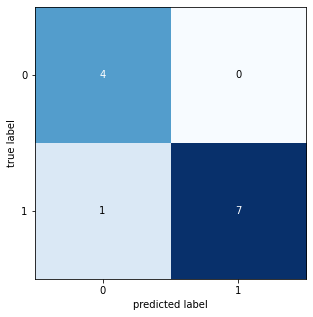

Running Time:  2.78775368599986
colon + IG Orde 3
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



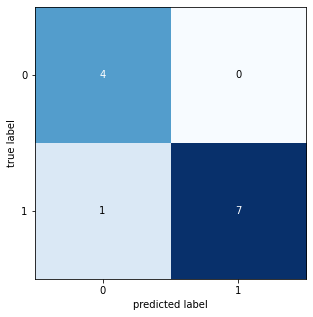

Running Time:  2.818183868999995
colon + IG Orde 4
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



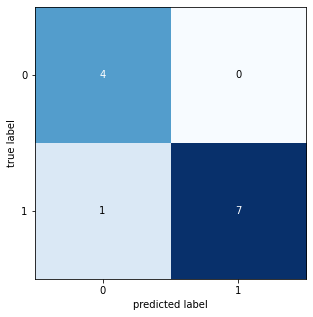

Running Time:  3.2542745850000756
colon + IG + GA Orde 2
Generation : 0
gene : [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



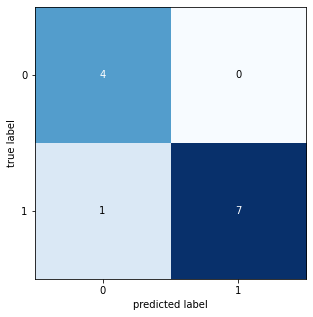

Running Time:  3.3652147959999184
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



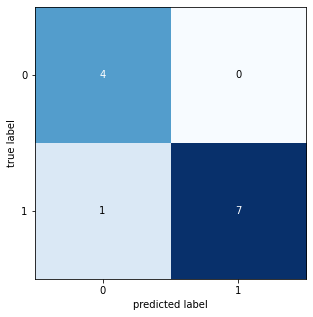

Running Time:  3.318158146999849
gene : [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



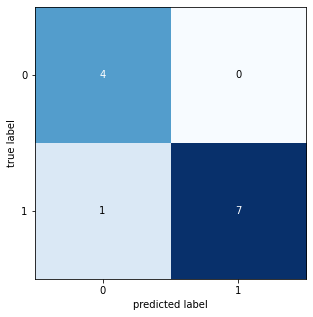

Running Time:  4.3100136999998995
gene : [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



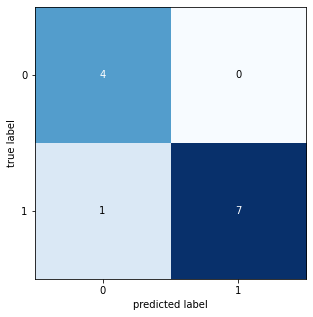

Running Time:  4.32008836
gene : [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



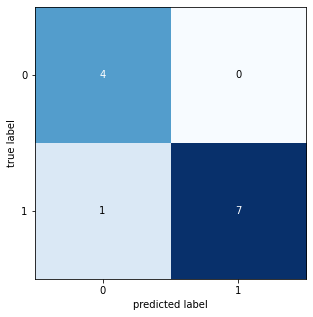

Running Time:  3.4004792460000317
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



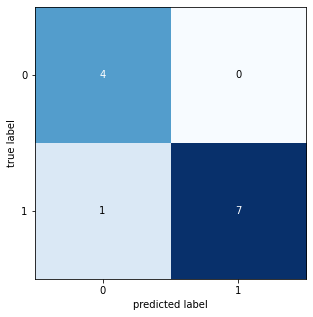

Running Time:  3.4109420140000566
gene : [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



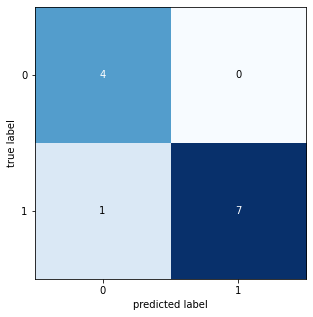

Running Time:  3.2956290179999996
gene : [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



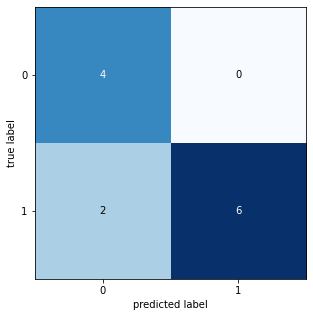

Running Time:  3.2045496859998366
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



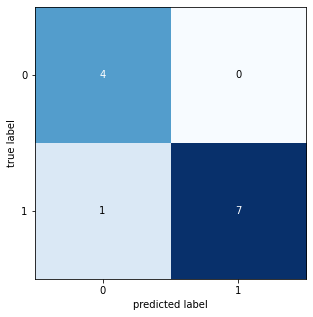

Running Time:  2.875735883000061
gene : [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



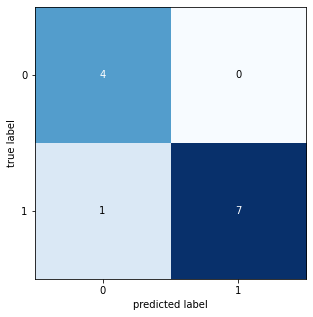

Running Time:  2.7395231259999946
gen terbaik : [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 52

Running Time:  35.07025601600003
colon + IG + GA Orde 3
Generation : 0
gene : [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.91666666

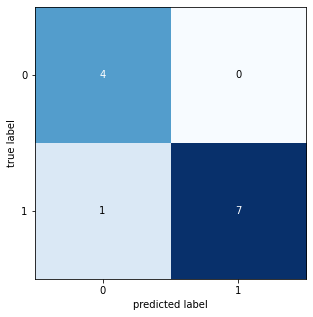

Running Time:  2.909221382999931
gene : [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



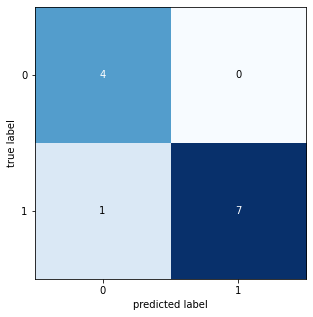

Running Time:  3.2319782489998943
gene : [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



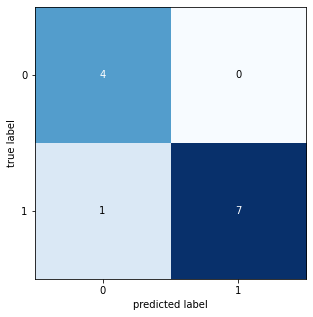

Running Time:  2.8155223229998683
gene : [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



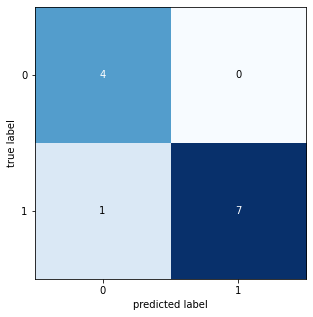

Running Time:  2.780724687999964
gene : [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



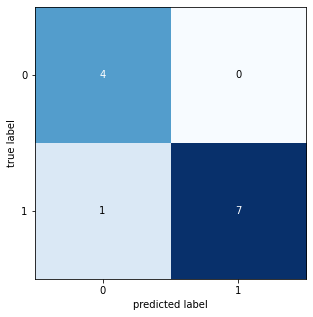

Running Time:  3.0253037719999156
gene : [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



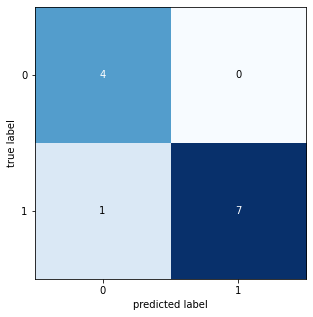

Running Time:  3.0448286069999995
gene : [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



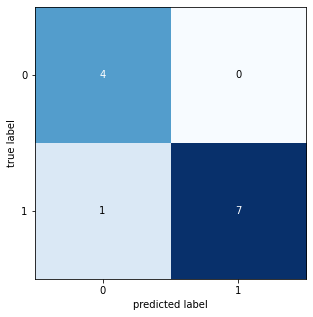

Running Time:  2.876883082999939
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



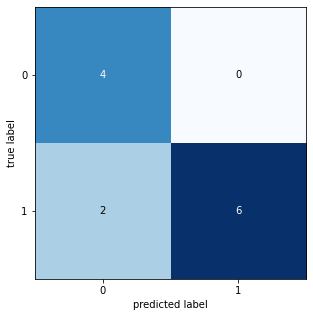

Running Time:  3.067655315000138
gene : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



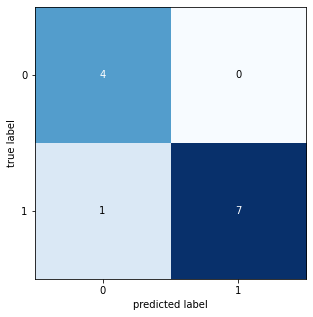

Running Time:  3.030887105999909
gene : [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



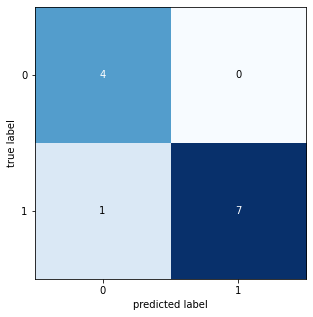

Running Time:  3.2175198050001654
gen terbaik : [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 51

Running Time:  30.683829709000065
colon + IG + GA Orde 4
Generation : 0
gene : [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666

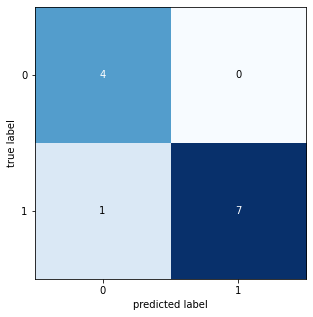

Running Time:  3.286023888000045
gene : [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



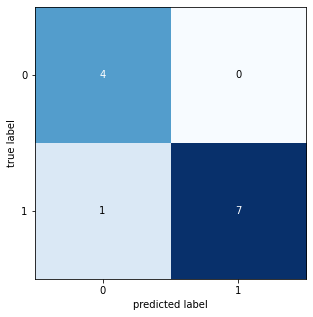

Running Time:  2.9111761490000845
gene : [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



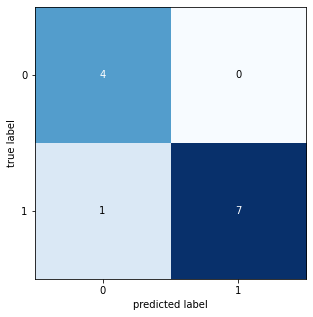

Running Time:  2.9678385559998333
gene : [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



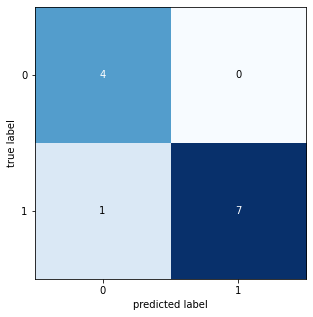

Running Time:  3.095083898999974
gene : [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



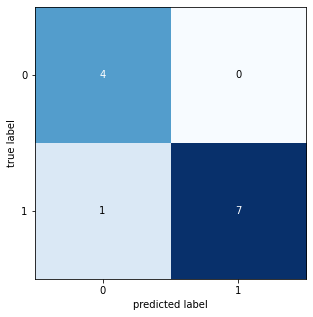

Running Time:  3.123999453000124
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



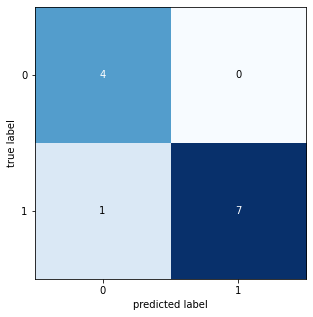

Running Time:  3.232511972000111
gene : [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



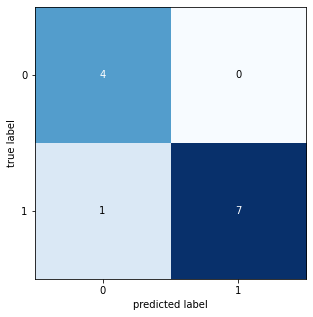

Running Time:  3.223092736999888
gene : [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



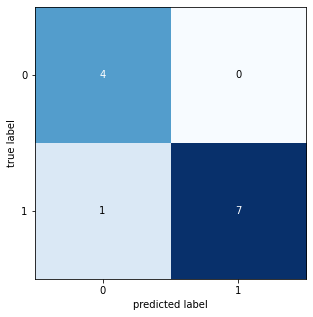

Running Time:  3.2343785780001326
gene : [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.75      0.86         8

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



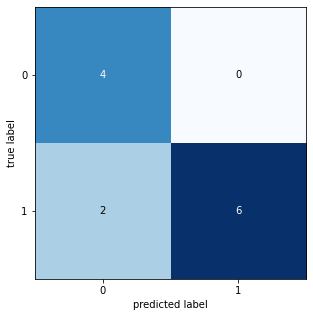

Running Time:  2.915199453000014
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]
Y_Train : [1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 0 1]
Y_Test : [0 1 0 0 1 1 1 1 1 1 1 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



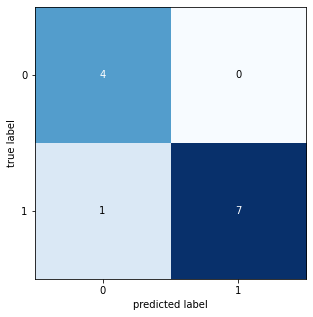

Running Time:  2.972702374000164
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.9111111111111112  || Akurasi terbaik : 0.9166666666666666  || jumlah fitur : 53

Running Time:  31.78680091199999
Avg accuracy colon cancer + IG orde 2 :  0.841025641025641
Avg F1 score colon cancer + IG orde 2 :  0.8086017740429506
Avg running time colon cancer + IG orde 2 :  8.111424341400006
Avg accuracy colon cancer + IG orde 3 :  0.841025641025641
Avg F1 score colon cancer + IG orde 3 :  0.8086017740429506
Avg running time colon cancer + IG orde 3 :  8.195797038000032
Avg accuracy colon cancer + IG orde 4 :  0.841025641025641
Avg F1 score colon cancer + IG orde 4 :  0.818141432011401
Avg running time colon cancer + IG

In [9]:
start = timeit.default_timer()
akurasi_IG_2,f1_IG_2,rt_IG_2 = [],[],[]
akurasi_IG_3,f1_IG_3,rt_IG_3 = [],[],[]
akurasi_IG_4,f1_IG_4,rt_IG_4 = [],[],[]

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = [],[],[],[]
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = [],[],[],[]
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = [],[],[],[]

#Melakukan proses K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
kf.get_n_splits(data_new_colon)
X = data_new_colon.copy().iloc[:, 0:len(data_new_colon.columns)-1].values
Y = data_new_colon.copy().iloc[:, len(data_new_colon.columns)-1].values
for train_index, test_index in kf.split(X,Y):
    print("Train : ", train_index, "Test : ", test_index)
    data_train, data_test, y_train, y_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index]), Y[train_index], Y[test_index]
    data_train['label'] = y_train
    data_test['label'] = y_test
    data_train, data_test, rt_ig = InformationGain(data_train.copy(), data_test.copy())
    print("colon + IG Orde 2")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 2)
    akurasi_IG_2.append(acc)
    f1_IG_2.append(f1)
    rt_IG_2.append(rt+rt_ig)
    print("colon + IG Orde 3")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 3)
    akurasi_IG_3.append(acc)
    f1_IG_3.append(f1)
    rt_IG_3.append(rt+rt_ig)
    print("colon + IG Orde 4")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "colon cancer", 4)
    akurasi_IG_4.append(acc)
    f1_IG_4.append(f1)
    rt_IG_4.append(rt+rt_ig)
    
    print("colon + IG + GA Orde 2")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 2)
    akurasi_IG_GA_2.append(acc)
    f1_IG_GA_2.append(f1)
    fitur_IG_GA_2.append(fitur)
    rt_IG_GA_2.append(rt+rt_ig)
    print("colon + IG + GA Orde 3")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 3)
    akurasi_IG_GA_3.append(acc)
    f1_IG_GA_3.append(f1)
    fitur_IG_GA_3.append(fitur)
    rt_IG_GA_3.append(rt+rt_ig)
    print("colon + IG + GA Orde 4")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 4)
    akurasi_IG_GA_4.append(acc)
    f1_IG_GA_4.append(f1)
    fitur_IG_GA_4.append(fitur)
    rt_IG_GA_4.append(rt+rt_ig)
    
akurasi_IG_2,f1_IG_2,rt_IG_2 = np.array(akurasi_IG_2),np.array(f1_IG_2),np.array(rt_IG_2)
akurasi_IG_3,f1_IG_3,rt_IG_3 = np.array(akurasi_IG_3),np.array(f1_IG_3),np.array(rt_IG_3)
akurasi_IG_4,f1_IG_4,rt_IG_4 = np.array(akurasi_IG_4),np.array(f1_IG_4),np.array(rt_IG_4)

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = np.array(akurasi_IG_GA_2),np.array(f1_IG_GA_2),np.array(fitur_IG_GA_2),np.array(rt_IG_GA_2)
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = np.array(akurasi_IG_GA_3),np.array(f1_IG_GA_3),np.array(fitur_IG_GA_3),np.array(rt_IG_GA_3)
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = np.array(akurasi_IG_GA_4),np.array(f1_IG_GA_4),np.array(fitur_IG_GA_4),np.array(rt_IG_GA_4)

#Print Result
print('===============================================================================================================================================================================================================')
print('Avg accuracy colon cancer + IG orde 2 : ', akurasi_IG_2.mean())
print('Avg F1 score colon cancer + IG orde 2 : ', f1_IG_2.mean())
print('Avg running time colon cancer + IG orde 2 : ', rt_IG_2.mean())
print('Avg accuracy colon cancer + IG orde 3 : ', akurasi_IG_3.mean())
print('Avg F1 score colon cancer + IG orde 3 : ', f1_IG_3.mean())
print('Avg running time colon cancer + IG orde 3 : ', rt_IG_3.mean())
print('Avg accuracy colon cancer + IG orde 4 : ', akurasi_IG_4.mean())
print('Avg F1 score colon cancer + IG orde 4 : ', f1_IG_4.mean())
print('Avg running time colon cancer + IG orde 4 : ', rt_IG_4.mean())
print('===============================================================================================================================================================================================================')
print('Avg accuracy colon cancer + IG + GA orde 2 : ', akurasi_IG_GA_2.mean())
print('Avg F1 score colon cancer + IG + GA orde 2 : ', f1_IG_GA_2.mean())
print('Avg Features colon cancer + IG + GA orde 2 : ', fitur_IG_GA_2.mean())
print('Avg running time colon cancer + IG + GA orde 2 : ', rt_IG_GA_2.mean())
print('Avg accuracy colon cancer + IG + GA orde 3 : ', akurasi_IG_GA_3.mean())
print('Avg F1 score colon cancer + IG + GA orde 3 : ', f1_IG_GA_3.mean())
print('Avg Features colon cancer + IG + GA orde 3 : ', fitur_IG_GA_3.mean())
print('Avg running time colon cancer + IG + GA orde 3 : ', rt_IG_GA_3.mean())
print('Avg accuracy colon cancer + IG + GA orde 4 : ', akurasi_IG_GA_4.mean())
print('Avg F1 score colon cancer + IG + GA orde 4 : ', f1_IG_GA_4.mean())
print('Avg Features colon cancer + IG + GA orde 4 : ', fitur_IG_GA_4.mean())
print('Avg running time colon cancer + IG + GA orde 4 : ', rt_IG_GA_4.mean())
print()
stop = timeit.default_timer()
print("Overall Running Time : ", stop-start)